In [1]:
import voxcell
import numpy
import json
import os
from matplotlib import pyplot as plt
from voxel_maps import coordinates_to_image



In [30]:
flatmap_for_pixel_positions = "./diffusion_embedding_thalamic_flatmap_plus_isocortex_v2.nrrd"
aff_flatmap_to_visualize = "./per_region_diffusion_flatmap_afferent.nrrd"

region_atlas = "./annotation_100.nrrd"
hierarchy_fn = "../hierarchy.json"

somatomotor = ["SSp-ll", "SSp-ul", "SSp-n", "SSp-m", "SSp-tr", "SSp-bfd",
                        "SSp-un", "SSs", "MOp", "MOs"]
cortex_regions = ["FRP","MOs","ACAd","ACAv","PL","ILA","ORBl","ORBm","ORBvl",
                             "AId","AIv","AIp","GU","VISC",
                             "SSs","SSp-bfd","SSp-tr","SSp-ll","SSp-ul","SSp-un","SSp-n","SSp-m","MOp",
                             "VISal","VISl","VISp","VISpl","VISli","VISpor","VISrl",
                             "VISa","VISam","VISpm","RSPagl","RSPd","RSPv",
                             "AUDd","AUDp","AUDpo","AUDv","TEa","PERI","ECT"]

pxl = voxcell.VoxelData.load_nrrd(flatmap_for_pixel_positions)
aff_viz = voxcell.VoxelData.load_nrrd(aff_flatmap_to_visualize)
aff_viz.raw[numpy.isnan(aff_viz.raw) | (aff_viz.raw < 0)] = -1

ann = voxcell.VoxelData.load_nrrd(region_atlas)
hier = voxcell.Hierarchy.load_json(hierarchy_fn)


/home/reimann/venvs/mcm/lib/python3.8/site-packages/voxcell/utils/deprecate.py:23: VoxcellDeprecationWarning: Deprecated. Please use RegionMap instead. Will be removed in v2.8.0.
  warnings.warn(msg, VoxcellDeprecationWarning)


In [1]:
def viz_as_image(pxl, viz, viz_type='image', ax=None, lst_regions=None):
    mask = numpy.all((~numpy.isnan(viz.raw)) & (viz.raw > -1)
                     &(~numpy.isnan(pxl.raw)) & (pxl.raw > -1), axis=3)
    if lst_regions is not None:
        reg_ids = [list(hier.collect("acronym", reg_name, "id")) for reg_name in lst_regions]
        mask = mask & (numpy.in1d(ann.raw.flat, numpy.hstack(reg_ids)).reshape(ann.raw.shape))

    xy = pxl.raw[mask]
    xy = xy - numpy.nanmin(xy, axis=0, keepdims=True)
    ab = viz.raw[mask]
    # Both coordinates between 0 and 1
    ab = (ab - ab.min(axis=0, keepdims=True)) / (ab.max(axis=0, keepdims=True) - ab.min(axis=0, keepdims=True))
    # Sum of coordinates under 1
    ab = ab / (3 * ab.mean(axis=0, keepdims=True))
    # Third coordinate sums it up to exactly 1
    ab = numpy.hstack([ab, 1.0 - ab.sum(axis=1, keepdims=True)])
    
    if ax is None:
        if viz_type == 'image':
            ax = plt.figure().gca()
        elif viz_type == 'double_gradient':
            fig = plt.figure()
            ax = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]

    if viz_type == 'image':
        ax.imshow( coordinates_to_image(ab, xy) )
    elif viz_type == 'double_gradient':
        ax[0].imshow( coordinates_to_image(ab[:, [0]], xy)[:, :, 0] )
        ax[1].imshow( coordinates_to_image(ab[:, [1]], xy)[:, :, 0] )

/home/reimann/venvs/mcm/lib/python3.8/site-packages/voxel_maps/voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with R

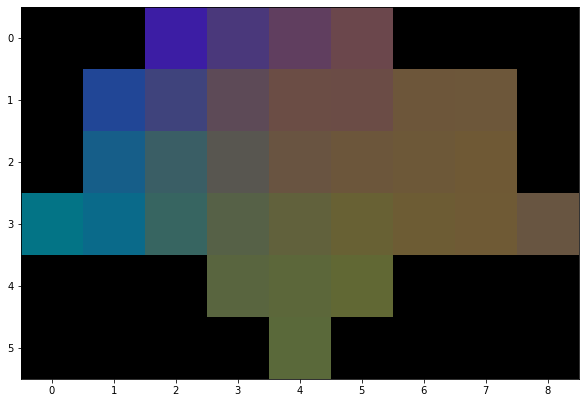

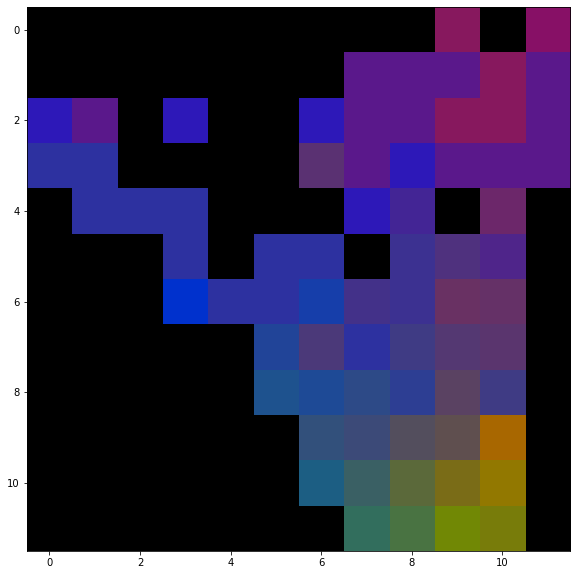

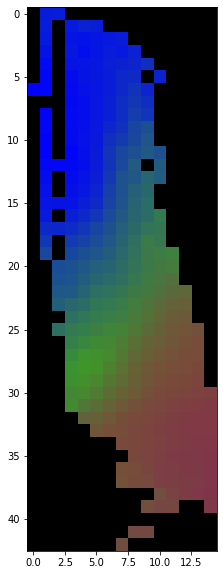

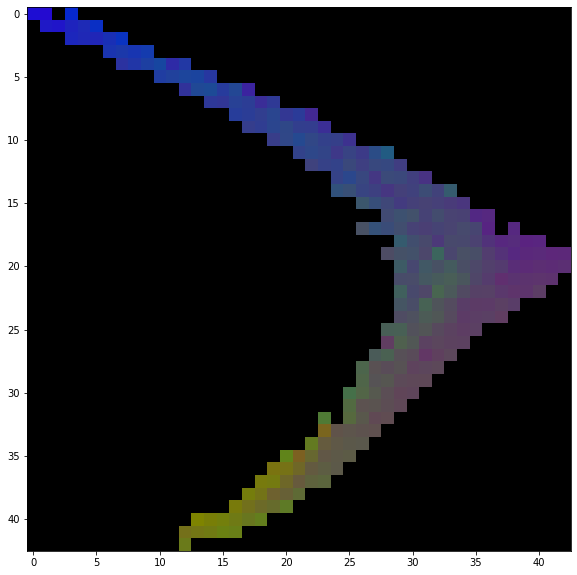

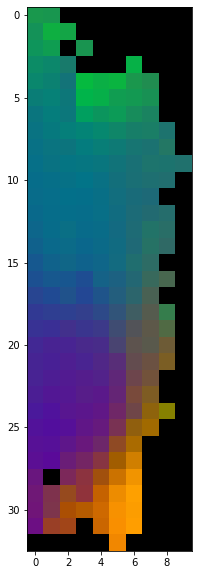

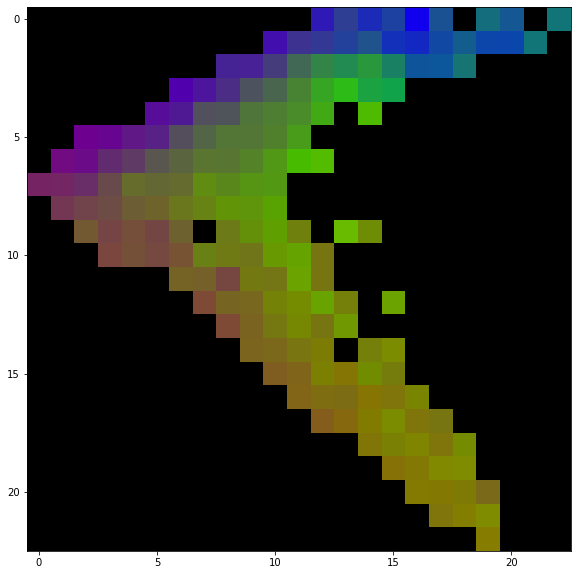

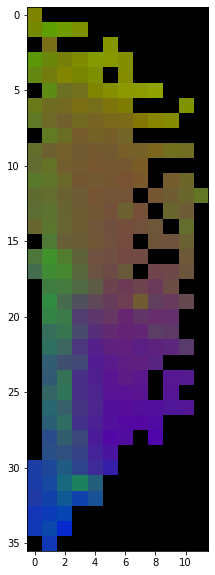

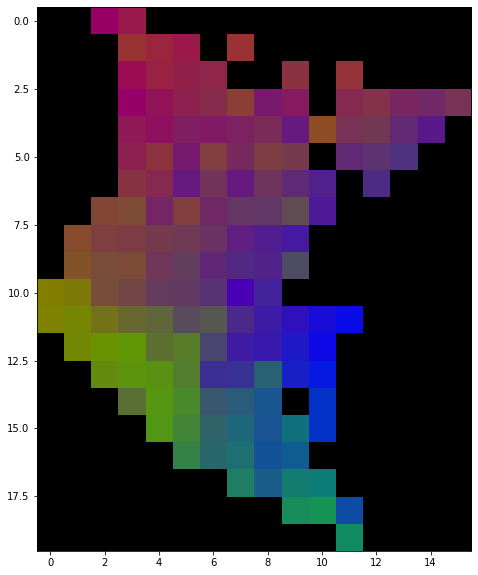

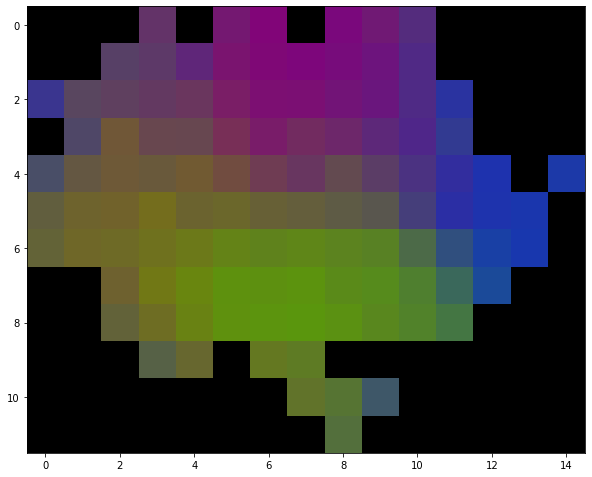

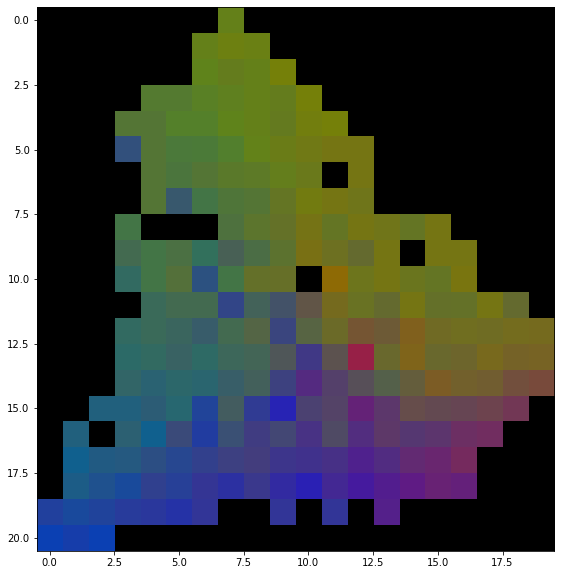

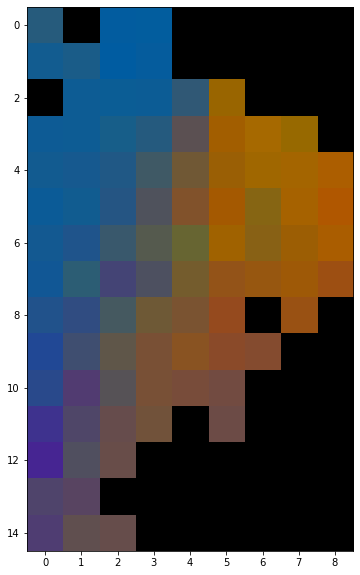

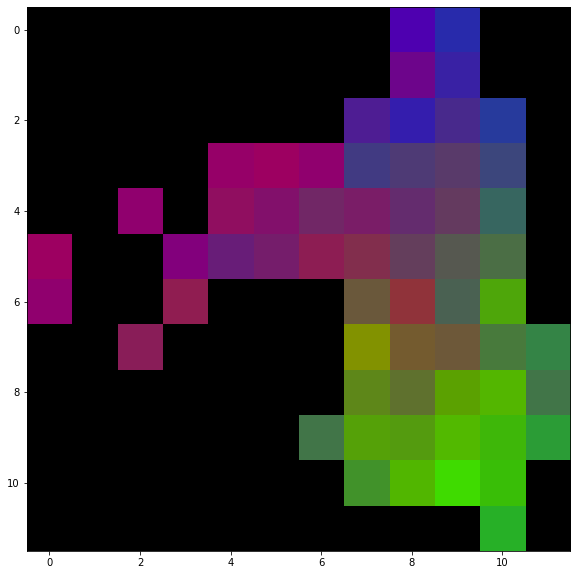

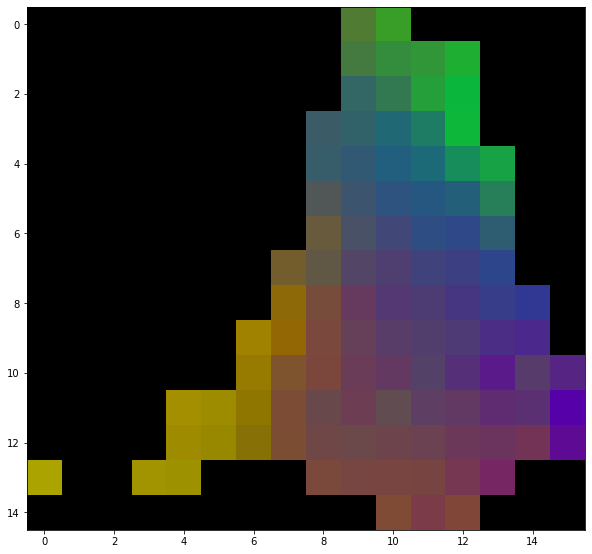

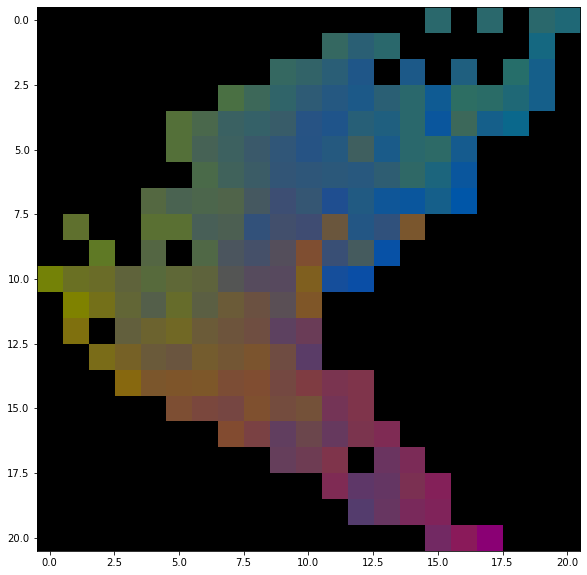

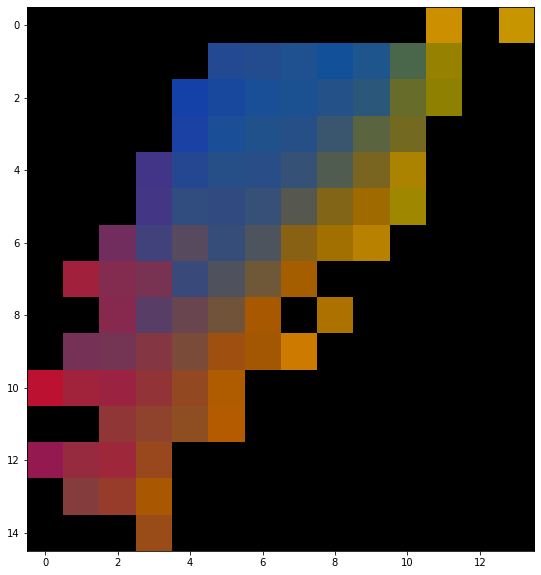

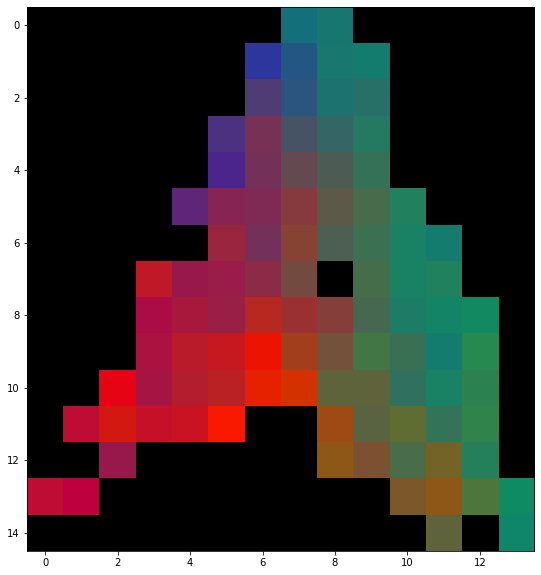

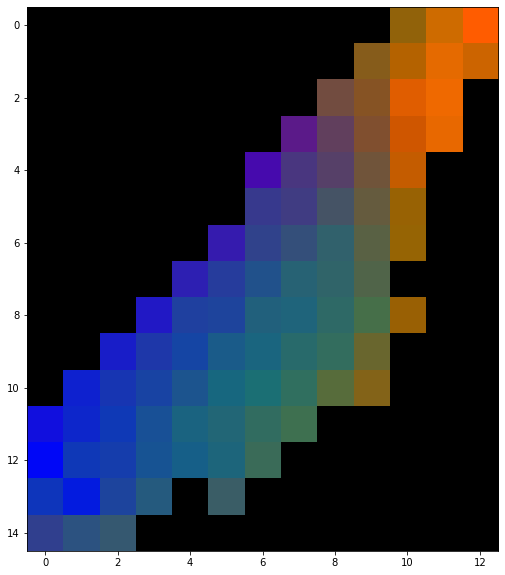

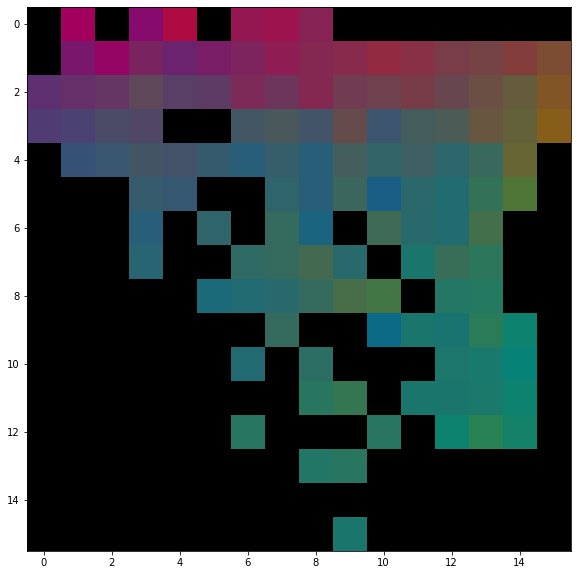

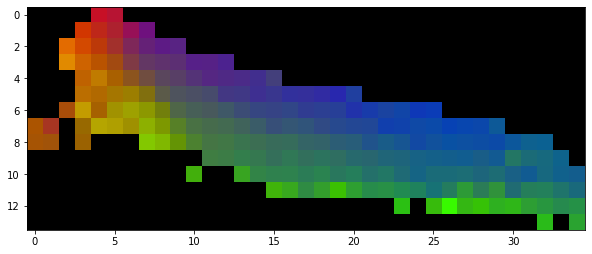

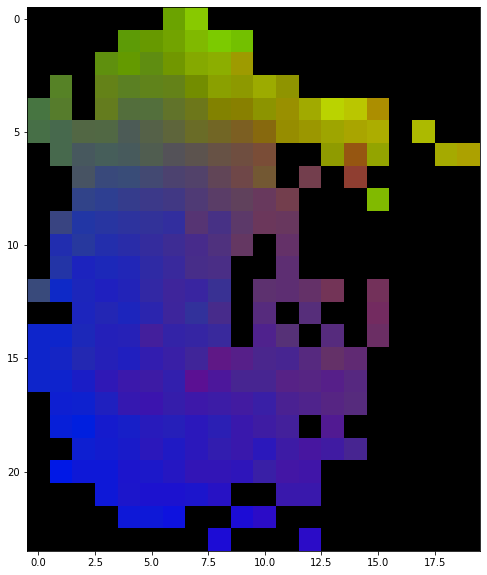

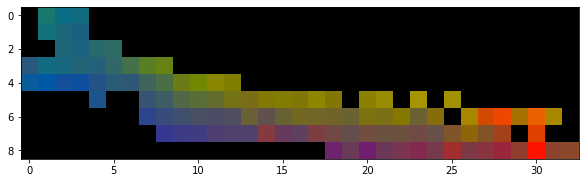

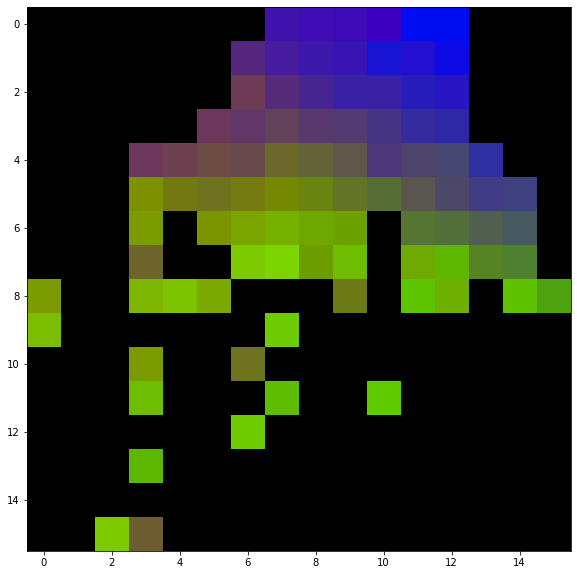

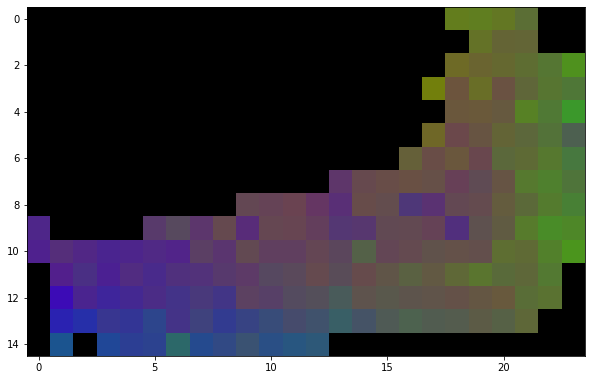

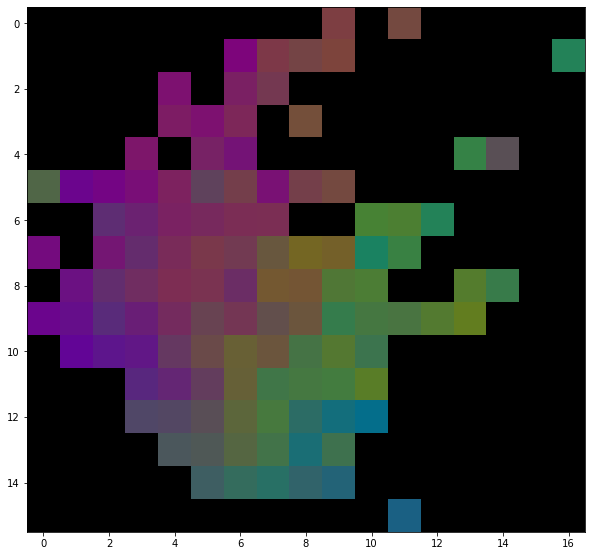

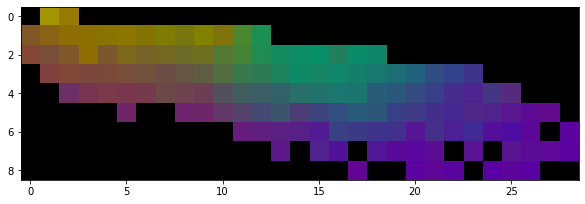

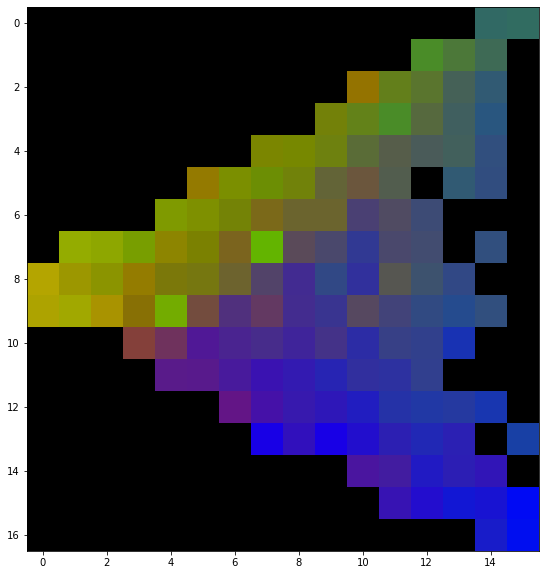

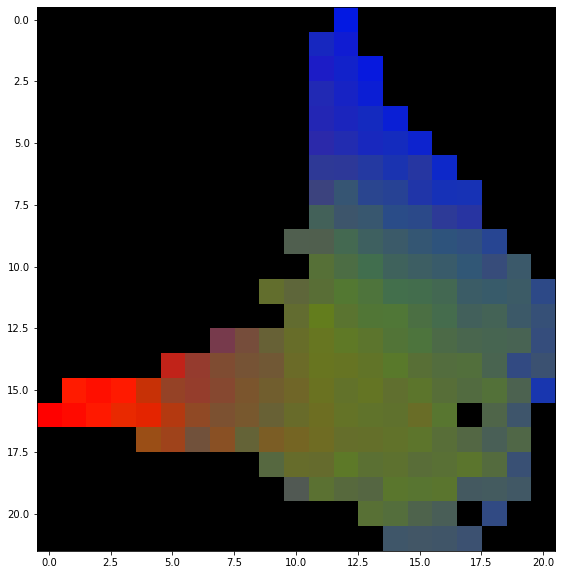

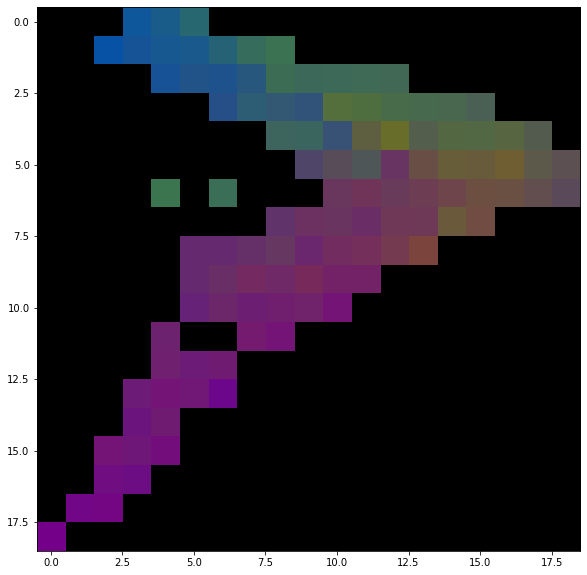

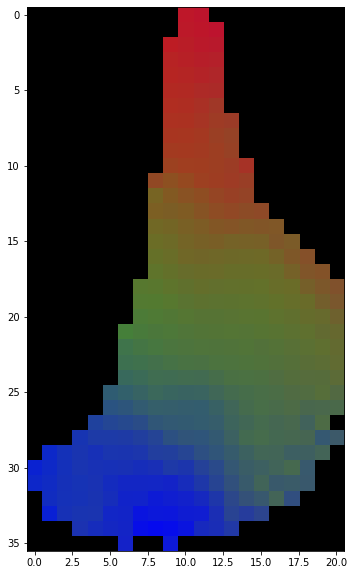

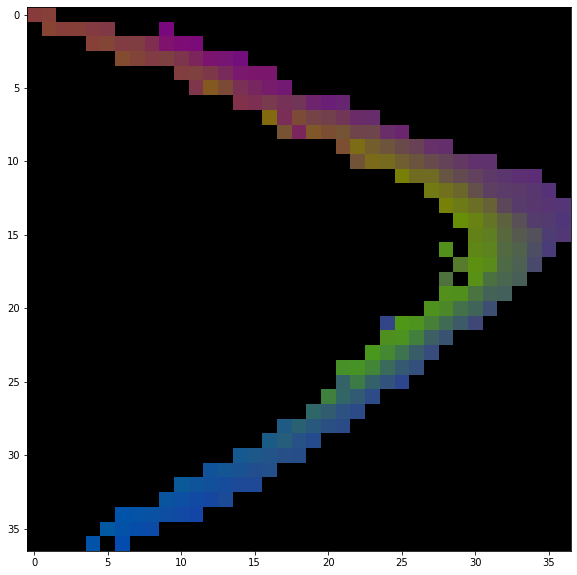

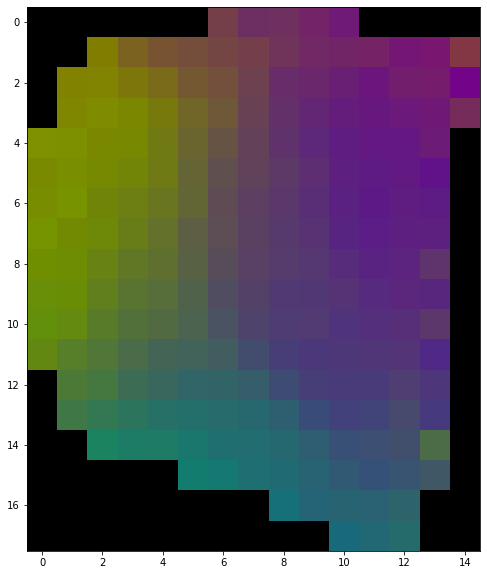

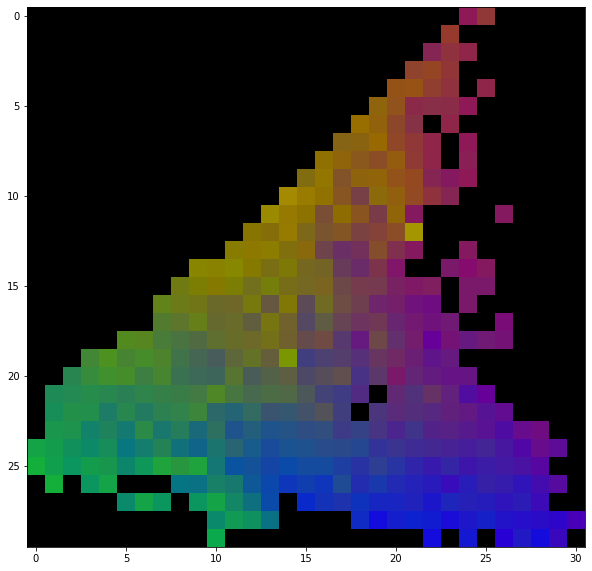

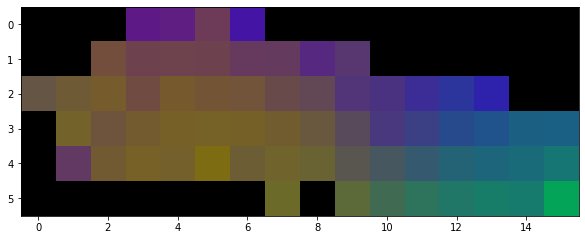

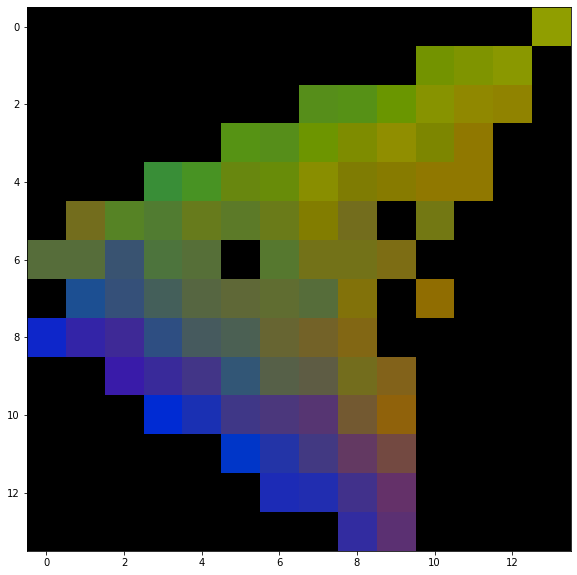

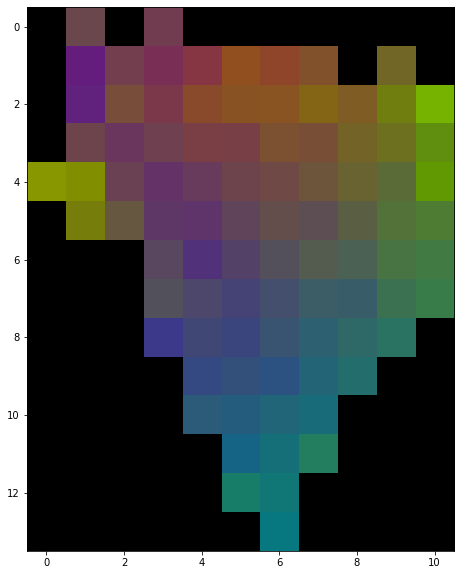

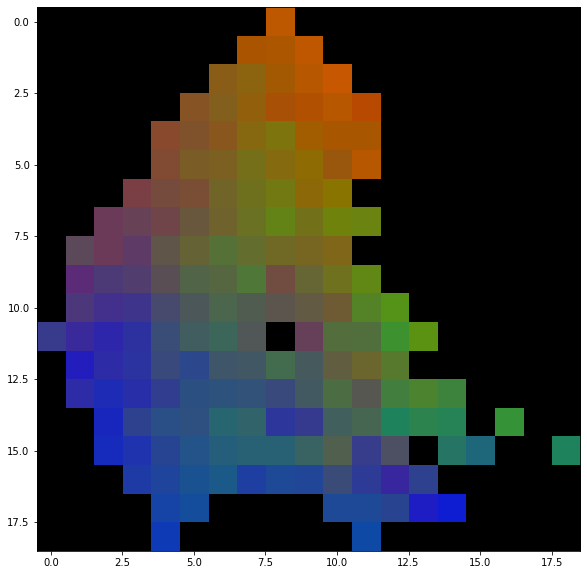

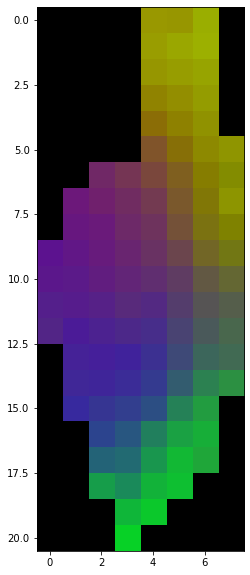

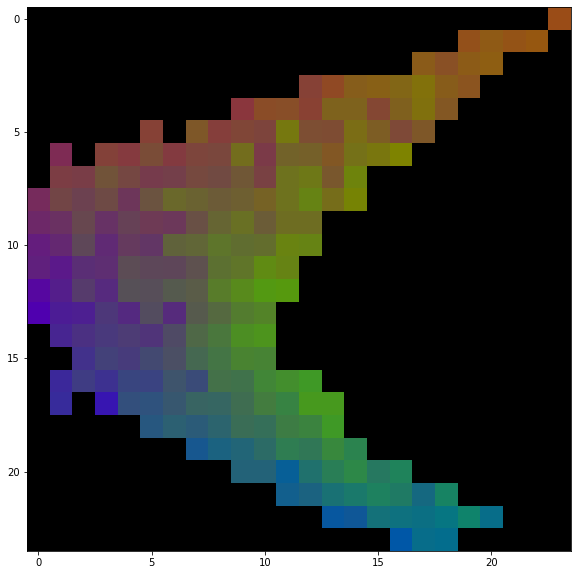

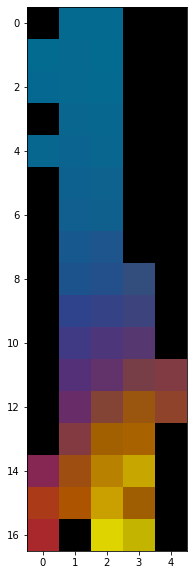

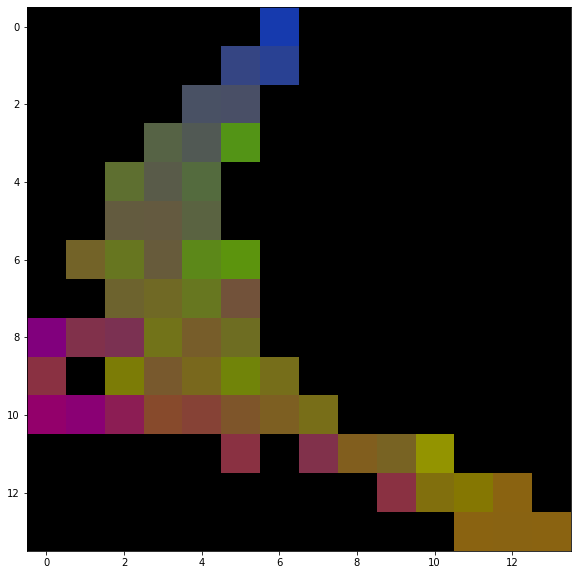

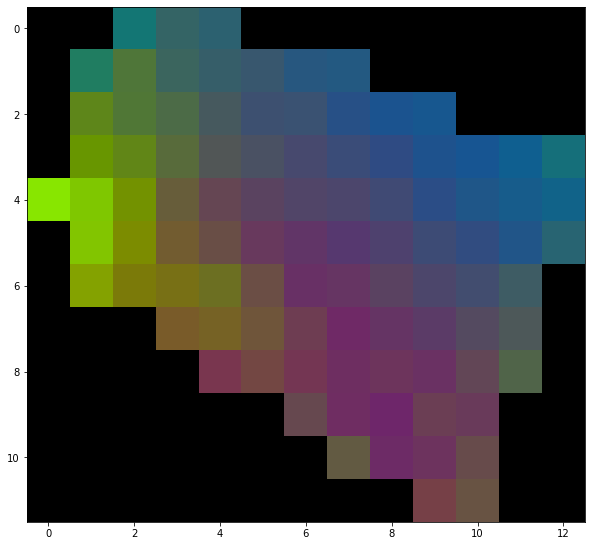

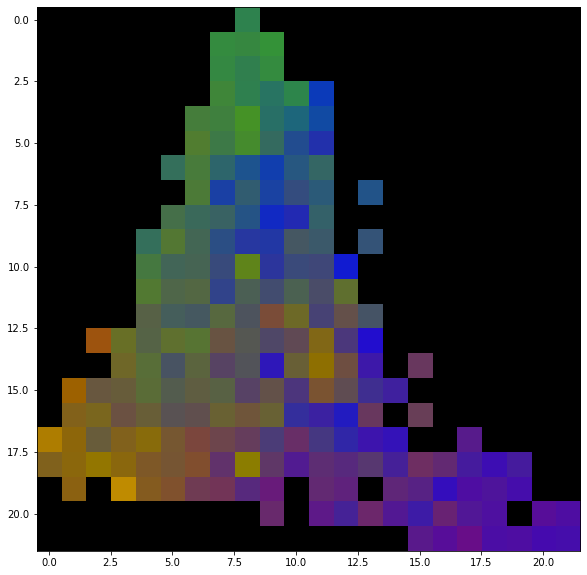

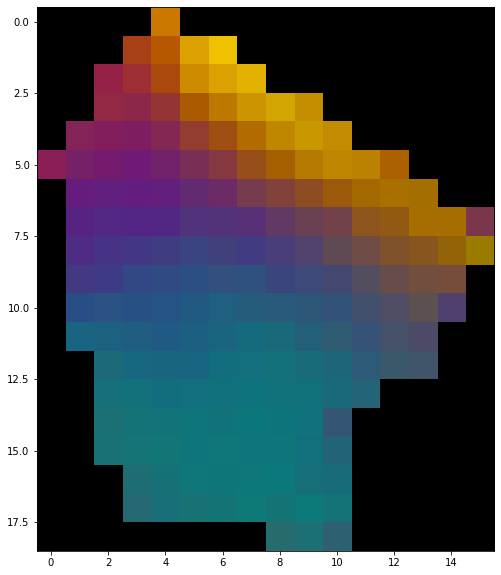

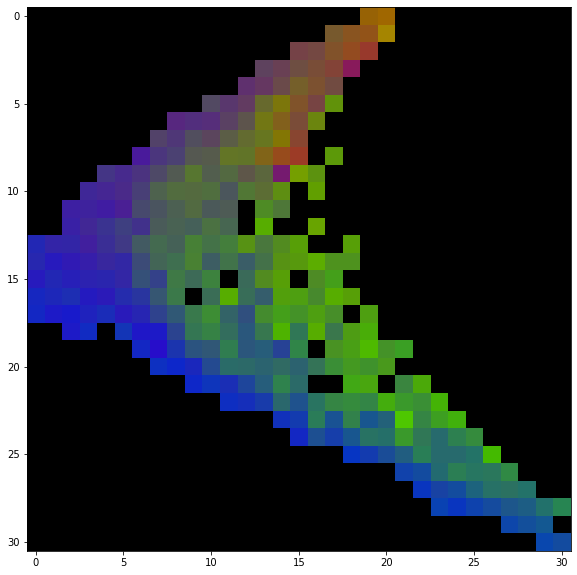

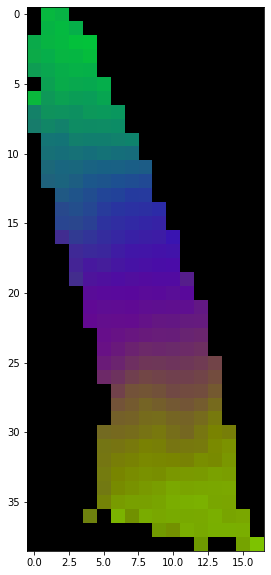

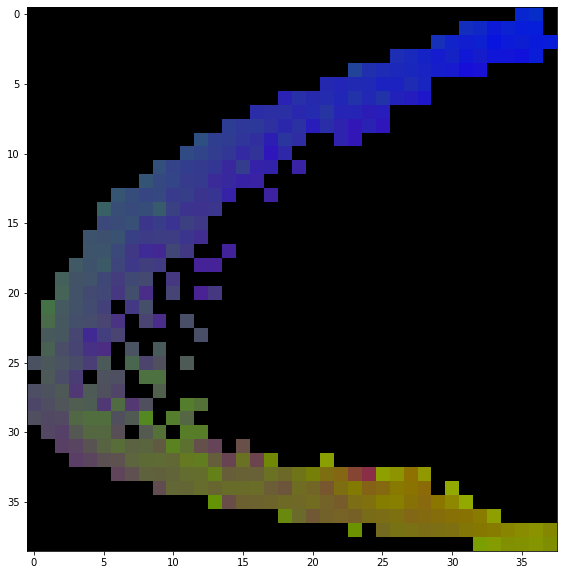

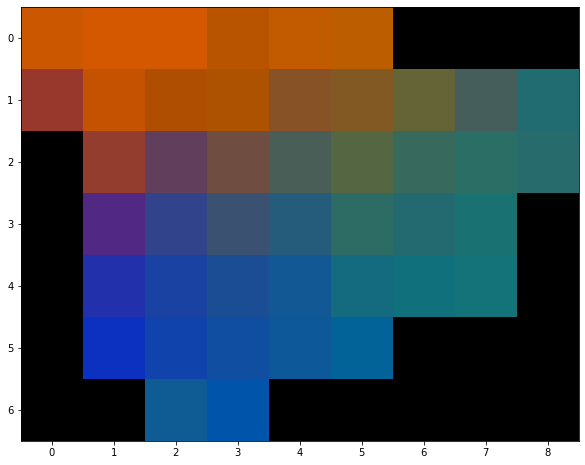

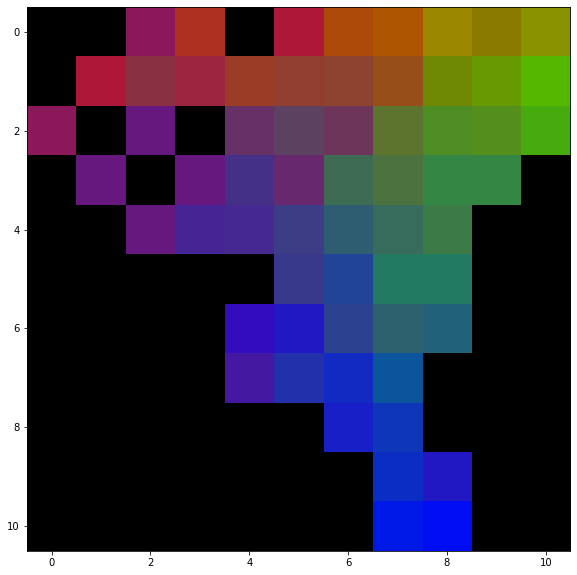

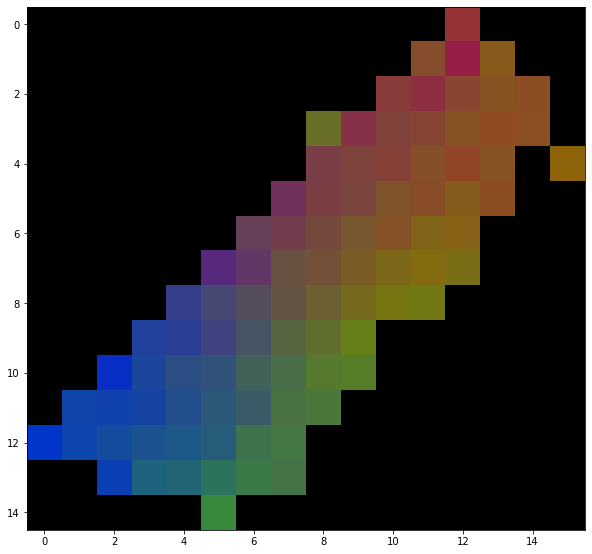

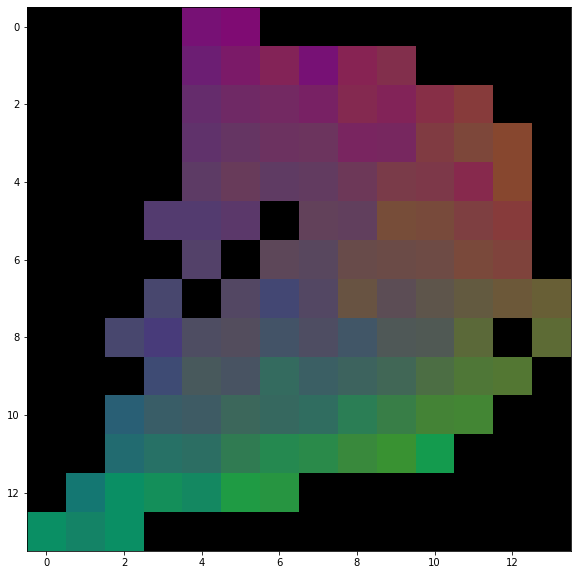

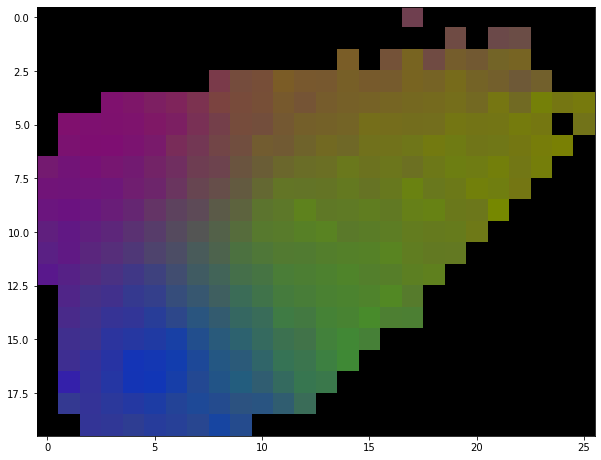

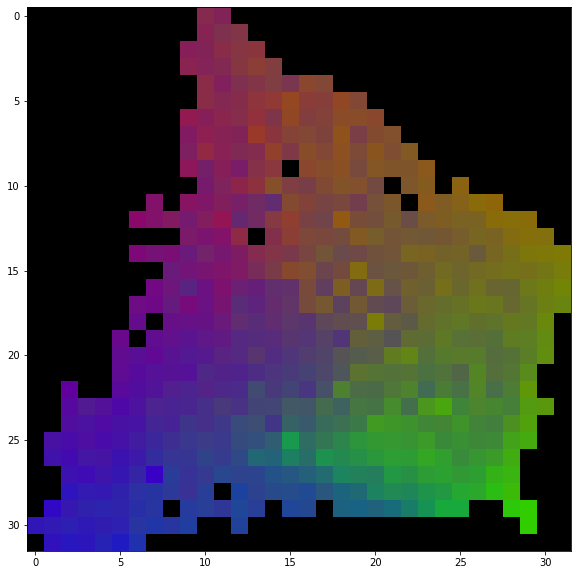

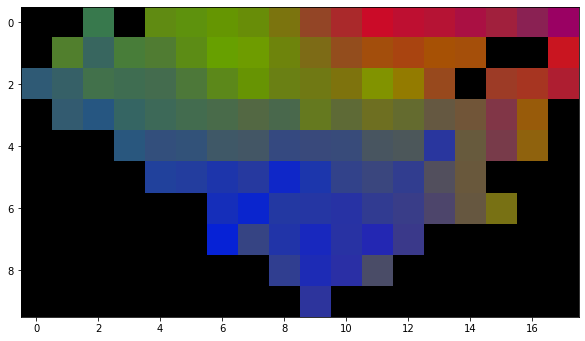

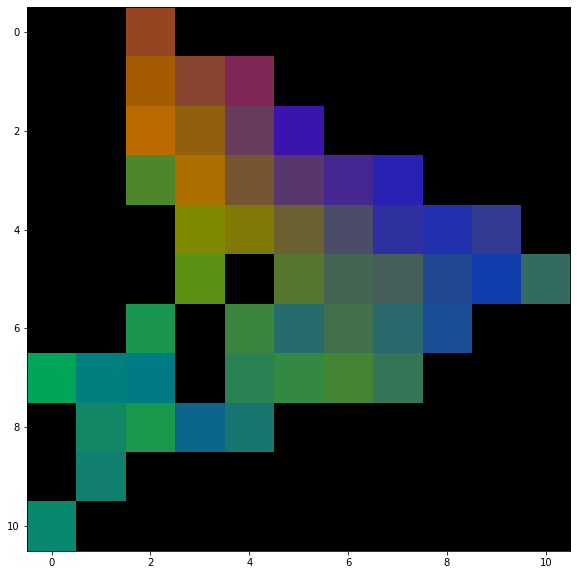

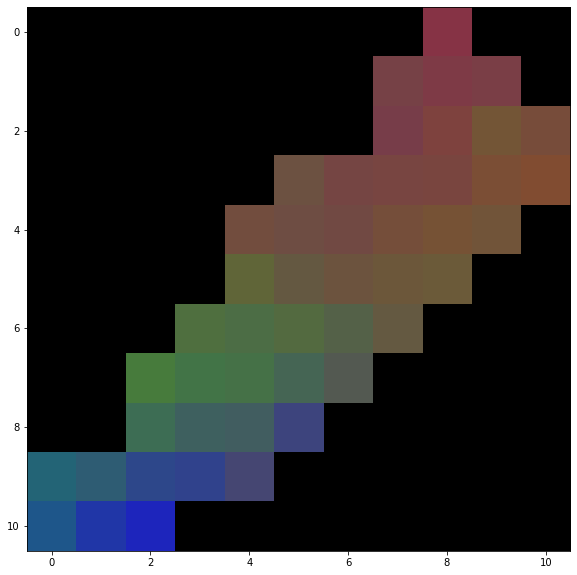

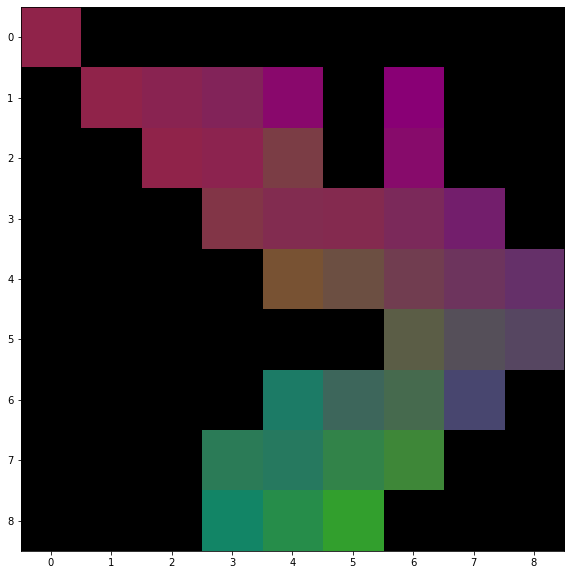

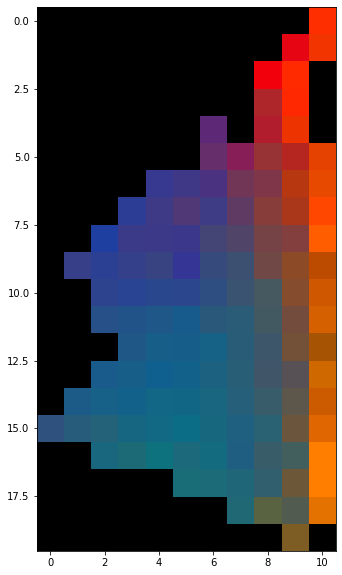

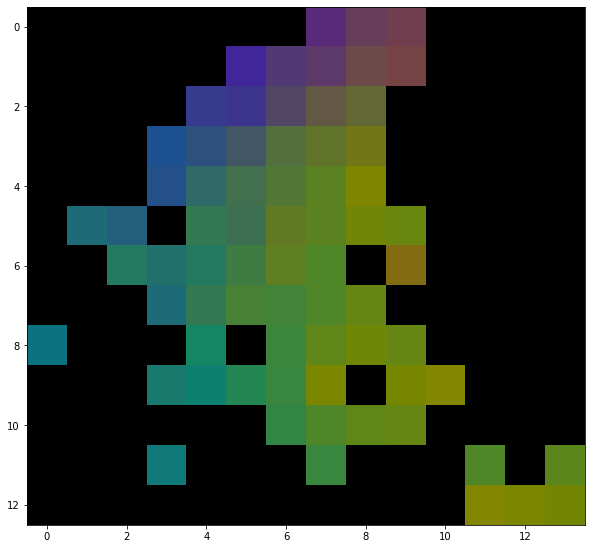

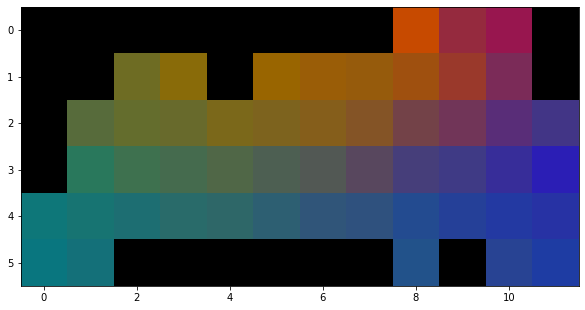

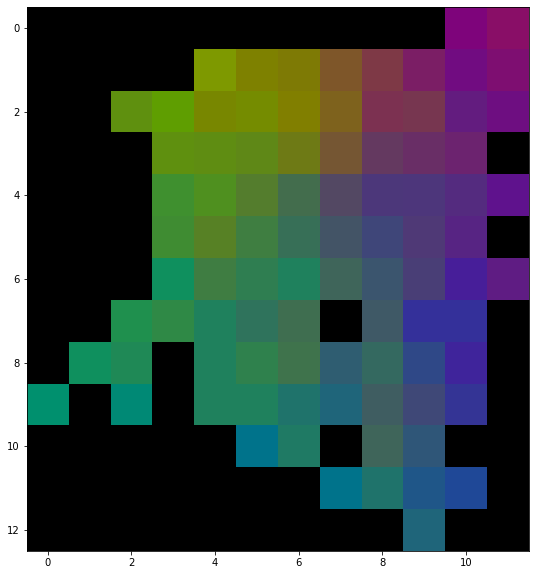

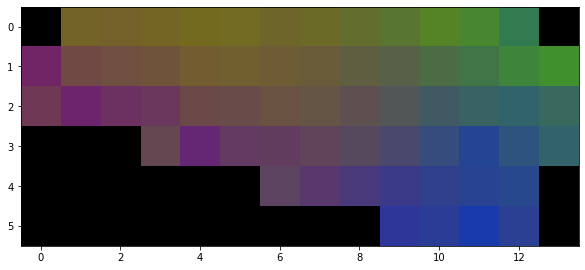

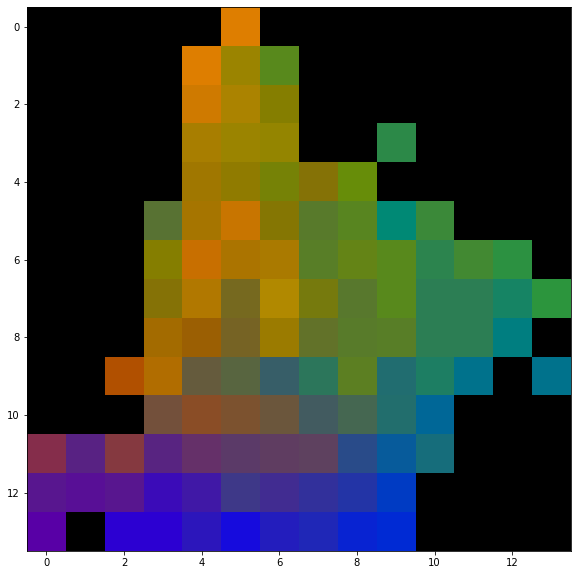

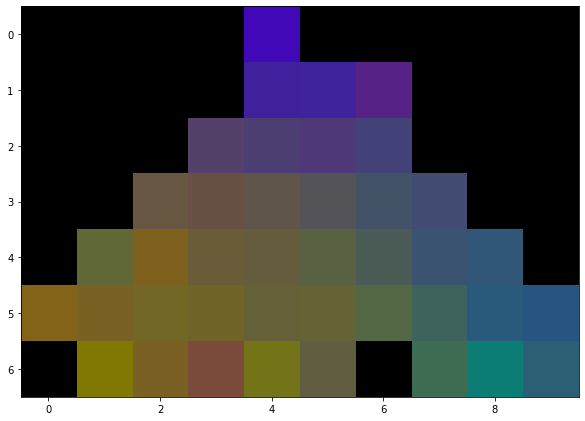

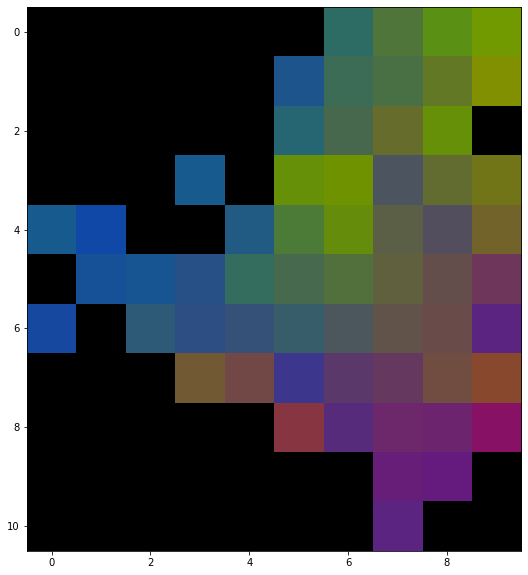

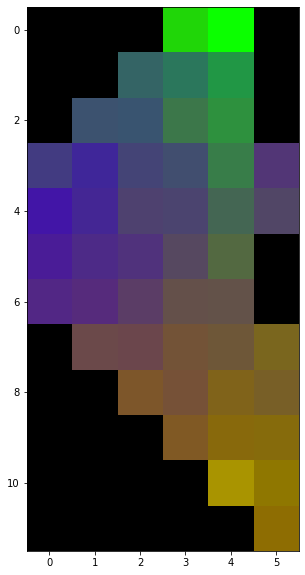

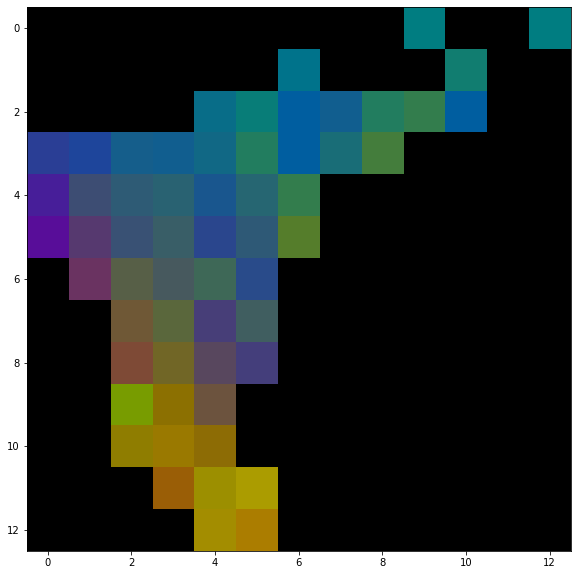

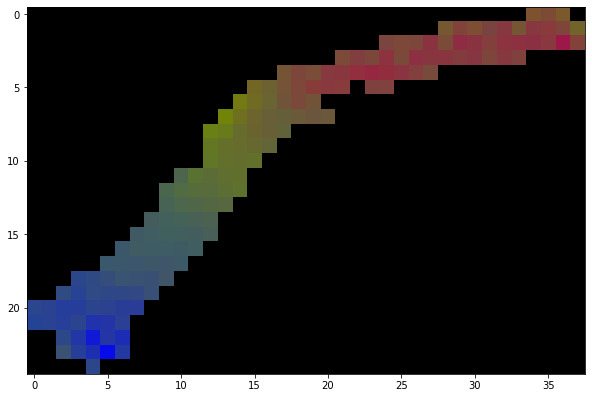

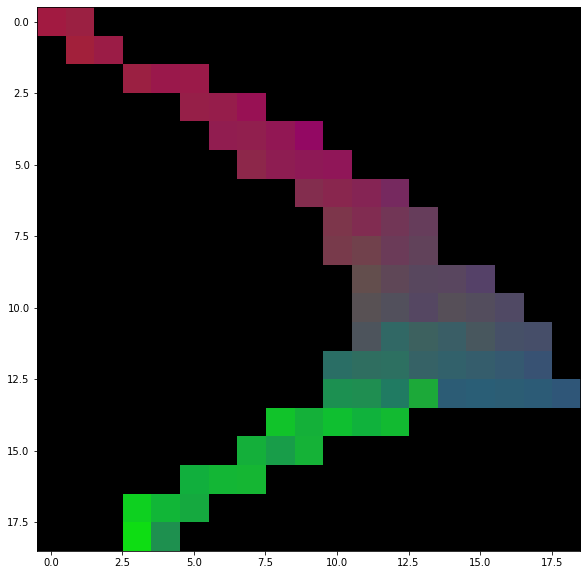

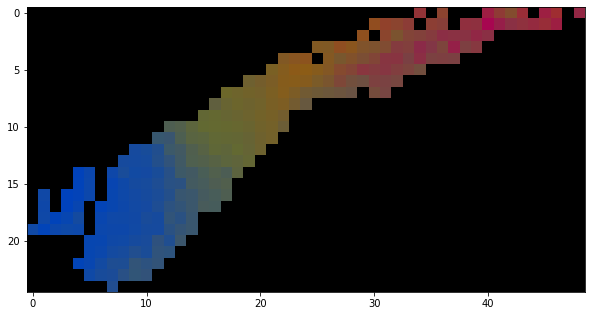

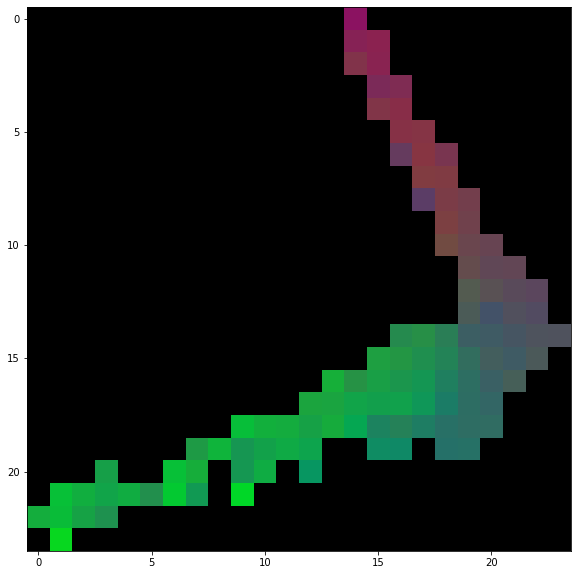

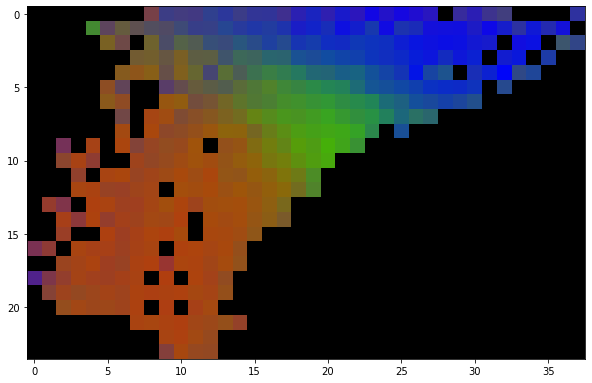

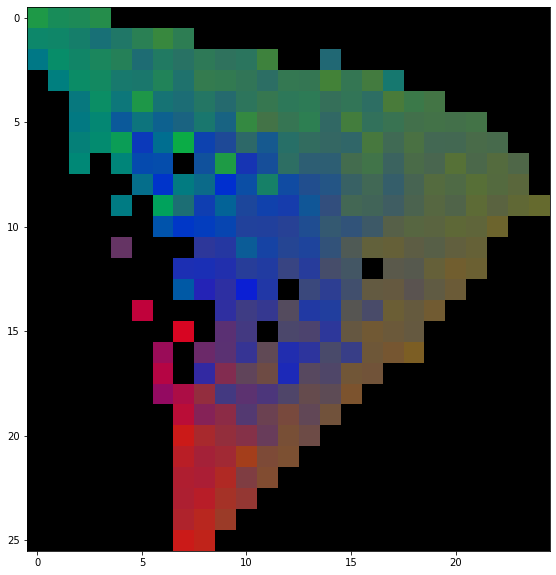

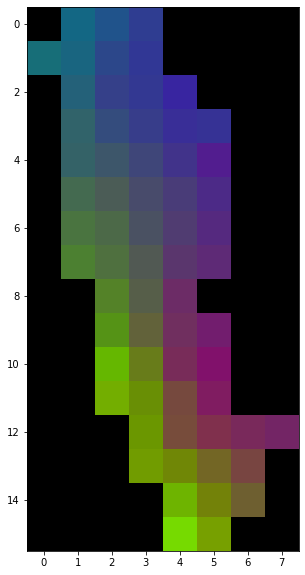

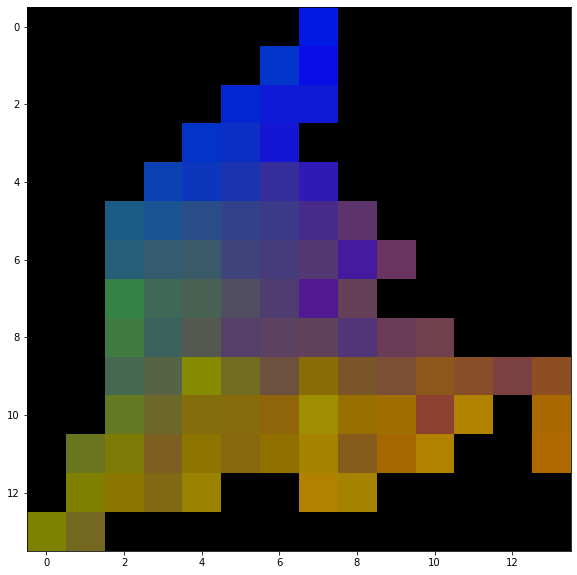

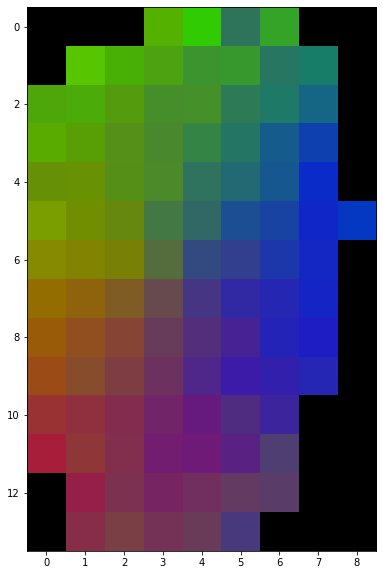

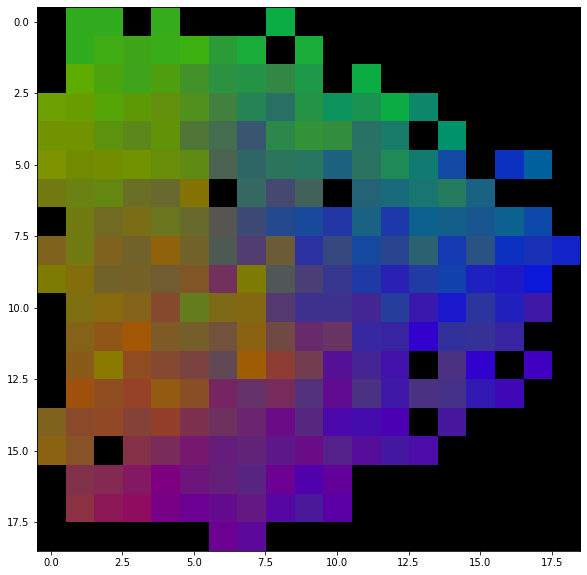

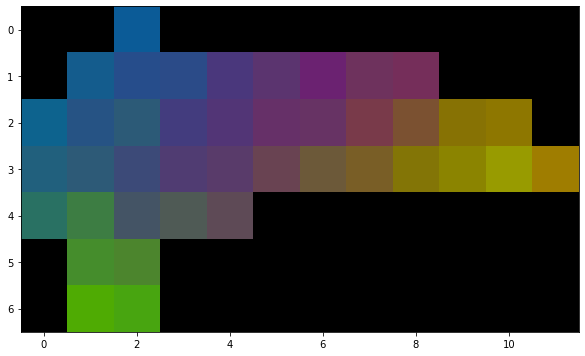

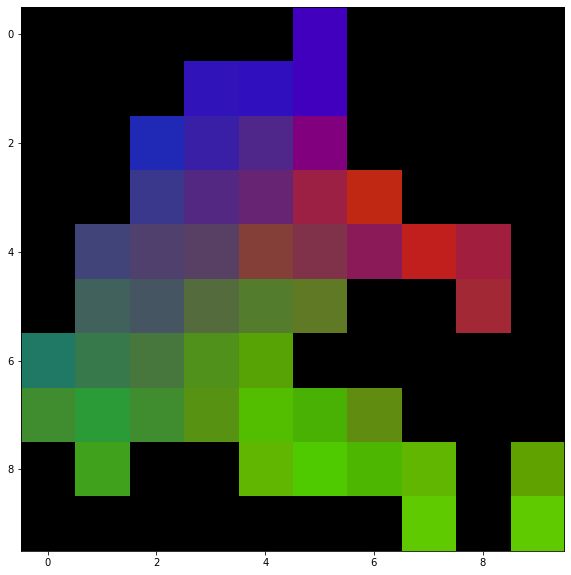

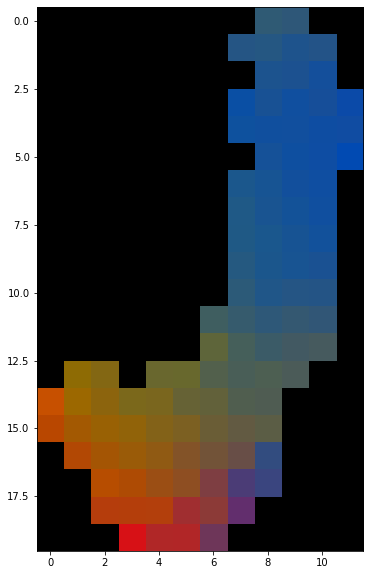

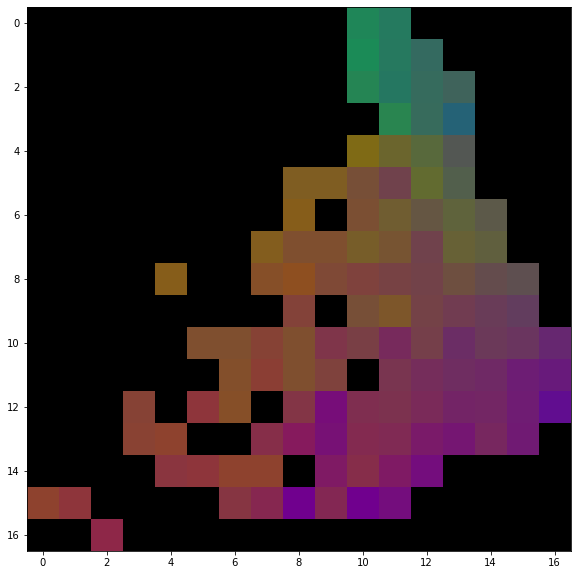

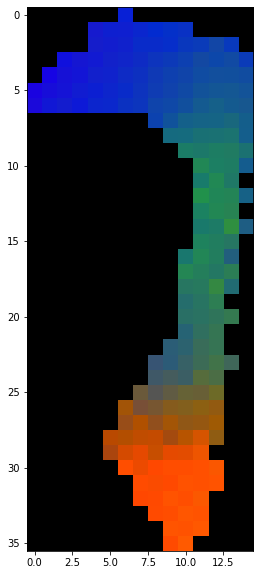

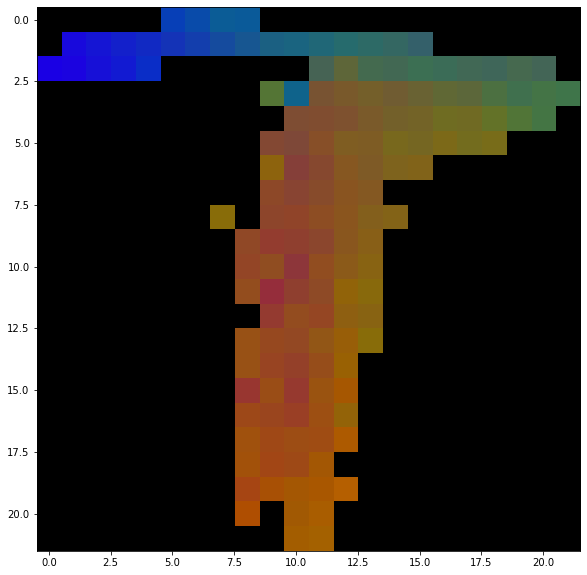

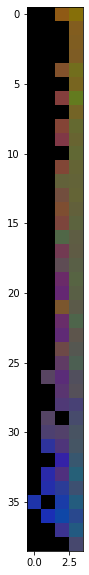

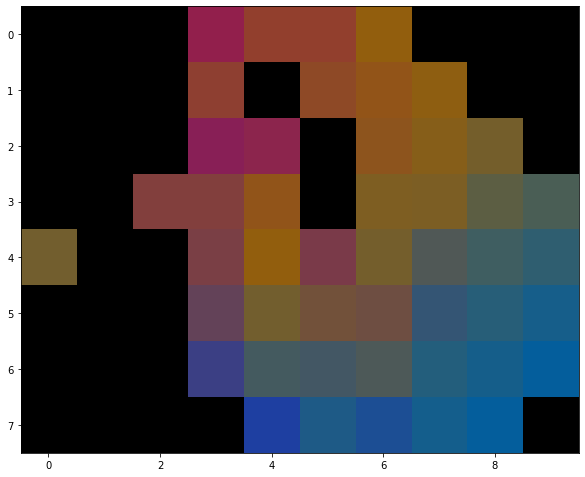

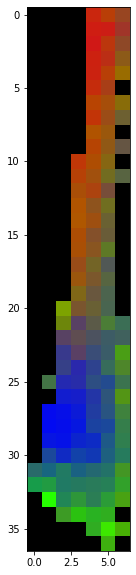

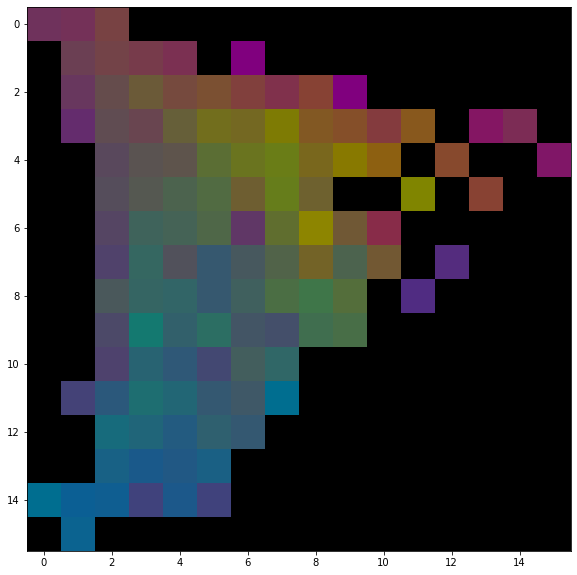

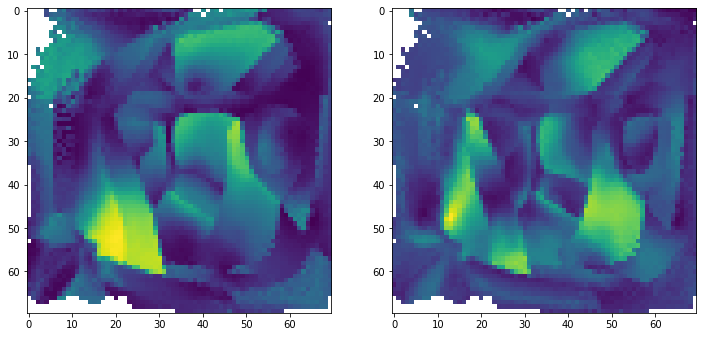

In [24]:

for region in cortex_regions:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    viz_as_image(pxl, aff_viz, ax=ax, lst_regions=[region])
    fig.savefig("figures/forward_{0}.png".format(region))
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    viz_as_image(aff_viz, pxl, ax=ax, lst_regions=[region])
    fig.savefig("figures/backward_{0}.png".format(region))

fig = plt.figure(figsize=(12, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
viz_as_image(pxl, aff_viz, ax=[ax1, ax2], viz_type="double_gradient")
fig.savefig("figures/all_regions_double_gradient.png")

In [32]:
def region_image(lst_regions, pxl=pxl):
    ann_vals = ann.raw.reshape((-1,))
    xy = pxl.raw.reshape((-1, 2))
    img_xy = numpy.empty(shape=(0, 2))
    img_vals = numpy.empty(shape=(0, 1))
    for i, tgt_region in enumerate(lst_regions):
        tgt_region_ids = list(hier.collect('acronym', tgt_region, 'id'))
        sub_xy = xy[numpy.in1d(ann_vals, tgt_region_ids), :]
        img_xy = numpy.vstack([img_xy, sub_xy])
        img_vals = numpy.vstack([img_vals, i * numpy.ones((len(sub_xy), 1))])
    return coordinates_to_image(img_vals, img_xy)
        

In [149]:
def viz_as_quiver(pxl, viz, ax=None, lst_regions=cortex_regions, normalize=True):
    if ax is None:
        ax = plt.figure(figsize=(25, 25)).gca()
    ax.imshow(region_image(lst_regions, pxl=pxl), cmap="tab20b")

    mask = numpy.all((~numpy.isnan(viz.raw)) & (viz.raw > -1), axis=3)
    ann_vals = ann.raw[mask]
    xy = pxl.raw[mask]
    ab = viz.raw[mask]
    #xy = xy - numpy.nanmin(xy, axis=0, keepdims=True)
    def normalize_gradient(gX, gY):
        l = numpy.sqrt(gX ** 2 + gY ** 2)
        return gX / l, gY / l
        

    for tgt_region in lst_regions:
        try:
            tgt_region_ids = list(hier.collect('acronym', tgt_region, 'id'))
            sub_xy = xy[numpy.in1d(ann_vals, tgt_region_ids)]
            sub_ab = ab[numpy.in1d(ann_vals, tgt_region_ids)]
            tmp_img = coordinates_to_image(sub_ab, sub_xy)
            #ax.imshow(tmp_img[:, :, 0])
            gY1, gX1 = numpy.gradient(tmp_img[:, :, 0])
            gY2, gX2 = numpy.gradient(tmp_img[:, :, 1])
            if normalize:
                
                gX1, gY1 = normalize_gradient(gX1, gY1)
                gX2, gY2 = normalize_gradient(gX2, gY2)
            X, Y = numpy.meshgrid(numpy.arange(gX1.shape[1]), numpy.arange(gX1.shape[0]))
            ax.quiver(X, Y, gX1, gY1, color='green', scale=100); 
            ax.quiver(X, Y, gX2, gY2, color='red', scale=100)
        except:
            pass
    ax.set_xlim([70, 140])
    ax.set_ylim(sorted(ax.get_ylim()))
    #ax.set_ylim([0, 70])

/home/reimann/venvs/mcm/lib/python3.8/site-packages/voxel_maps/voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out


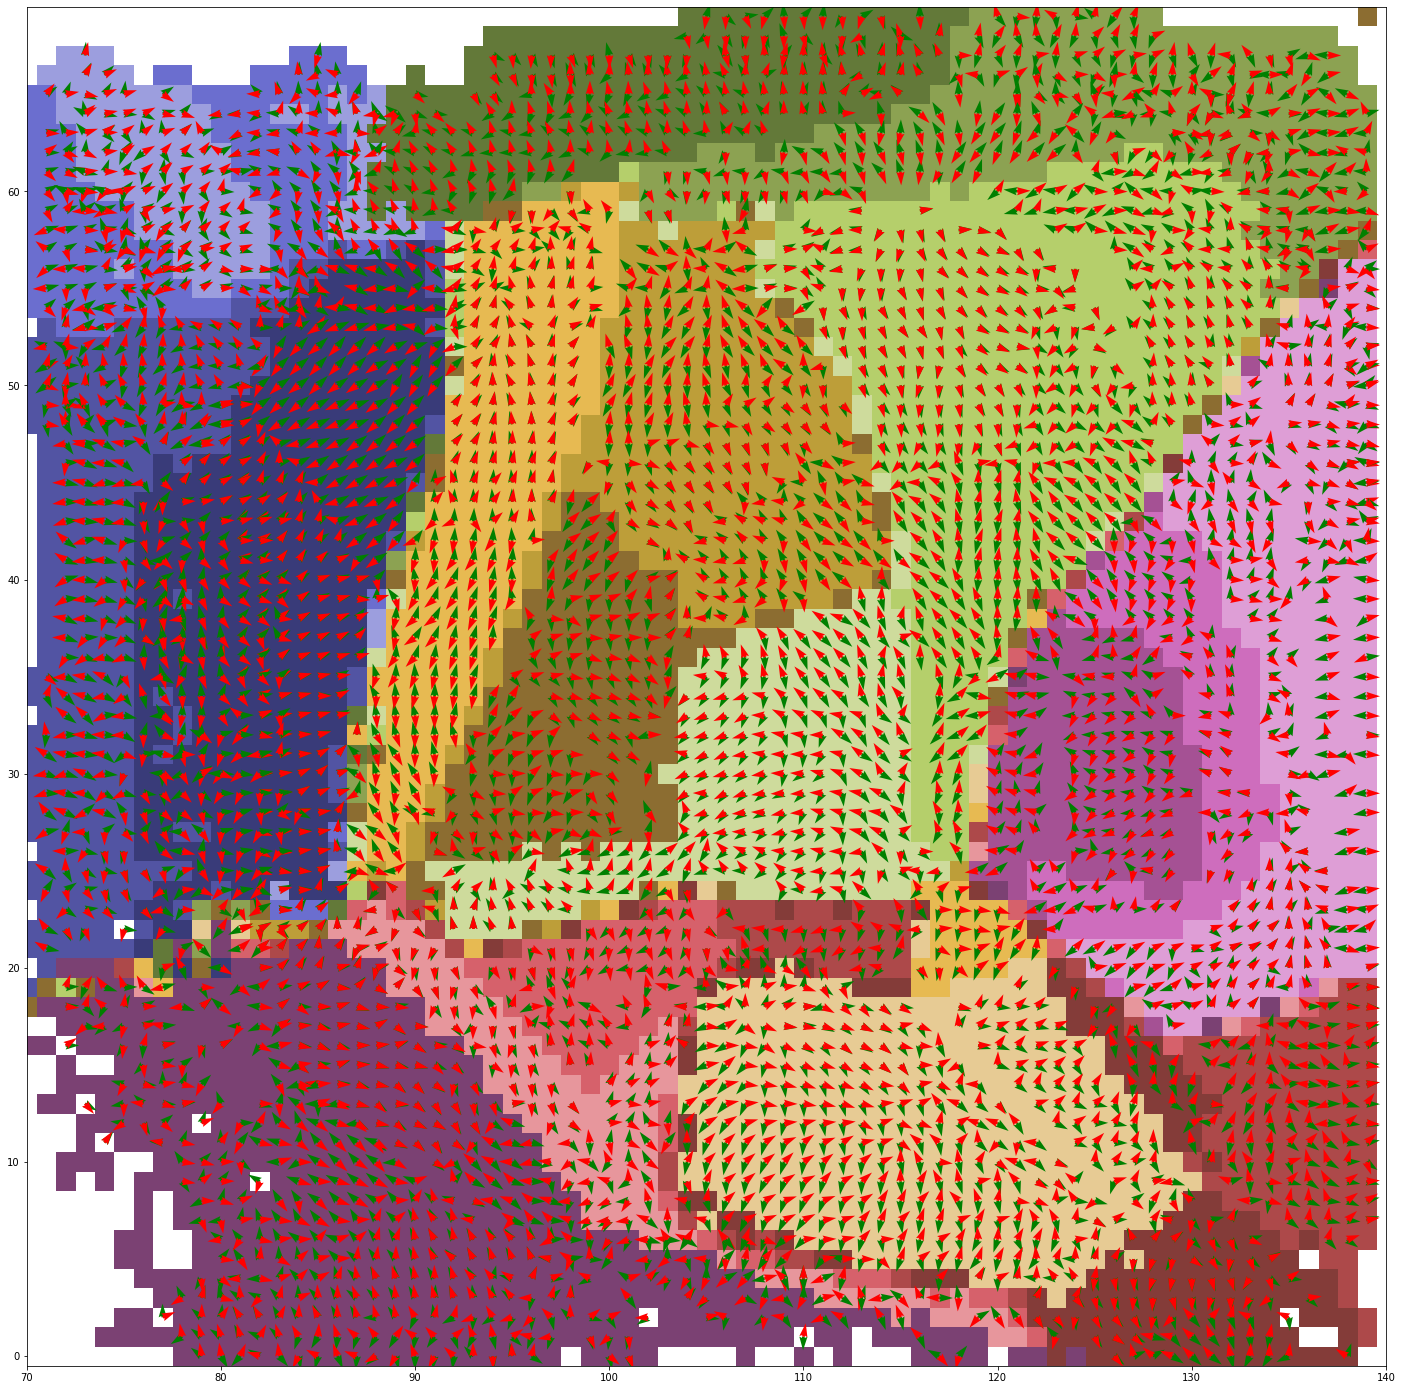

In [151]:
viz_as_quiver(pxl, aff_viz, lst_regions=cortex_regions, normalize=True)

In [106]:
def abs_cos_angle(v1, v2):
    l1 = numpy.sqrt(numpy.sum(v1 ** 2, axis=1, keepdims=True))
    l2 = numpy.sqrt(numpy.sum(v2 ** 2, axis=1, keepdims=True))
    ret = numpy.arccos(numpy.sum((v1 / l1) * (v2 / l2), axis=1))
    return numpy.abs(ret - numpy.pi / 2) / (numpy.pi / 2)
    
img_shape = (70, 140)

def local_distortion(pxl, viz, ax=None, lst_regions=cortex_regions, plot=True):    
    mask = numpy.all((~numpy.isnan(viz.raw)) & (viz.raw > -1), axis=3)
    ann_vals = ann.raw[mask]
    xy = pxl.raw[mask]
    ab = viz.raw[mask]
    
    viz_img = numpy.NaN * numpy.ones(img_shape + (1,))
    ret = {}

    for tgt_region in lst_regions:
        try:
            tgt_region_ids = list(hier.collect('acronym', tgt_region, 'id'))
            sub_xy = xy[numpy.in1d(ann_vals, tgt_region_ids)]
            sub_ab = ab[numpy.in1d(ann_vals, tgt_region_ids)]
            tmp_img = coordinates_to_image(sub_ab, sub_xy, shape=(70, 140))
            gY1, gX1 = numpy.gradient(tmp_img[:, :, 0])
            gY2, gX2 = numpy.gradient(tmp_img[:, :, 1])
            g1 = numpy.dstack([gX1, gY1]).reshape((-1, 2))
            g2 = numpy.dstack([gX2, gY2]).reshape((-1, 2))
            banana_factor = abs_cos_angle(g1, g2).reshape(gX1.shape)
            viz_img = numpy.dstack([viz_img, banana_factor])
            ret[tgt_region] = numpy.nanmean(banana_factor)
        except:
            print("Exception for {0}".format(tgt_region))
    if plot:
        if ax is None:
            ax = plt.figure(figsize=(25, 25)).gca()
        plt.colorbar(ax.imshow(numpy.nanmean(viz_img, axis=2)))
    return ret
    #ax.set_xlim([70, 140])
    #ax.set_ylim(sorted(ax.get_ylim()))
    #ax.set_ylim([0, 70])

/home/reimann/venvs/mcm/lib/python3.8/site-packages/voxel_maps/voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out
<ipython-input-106-473d67463281>:36: RuntimeWarning: Mean of empty slice
  plt.colorbar(ax.imshow(numpy.nanmean(viz_img, axis=2)))


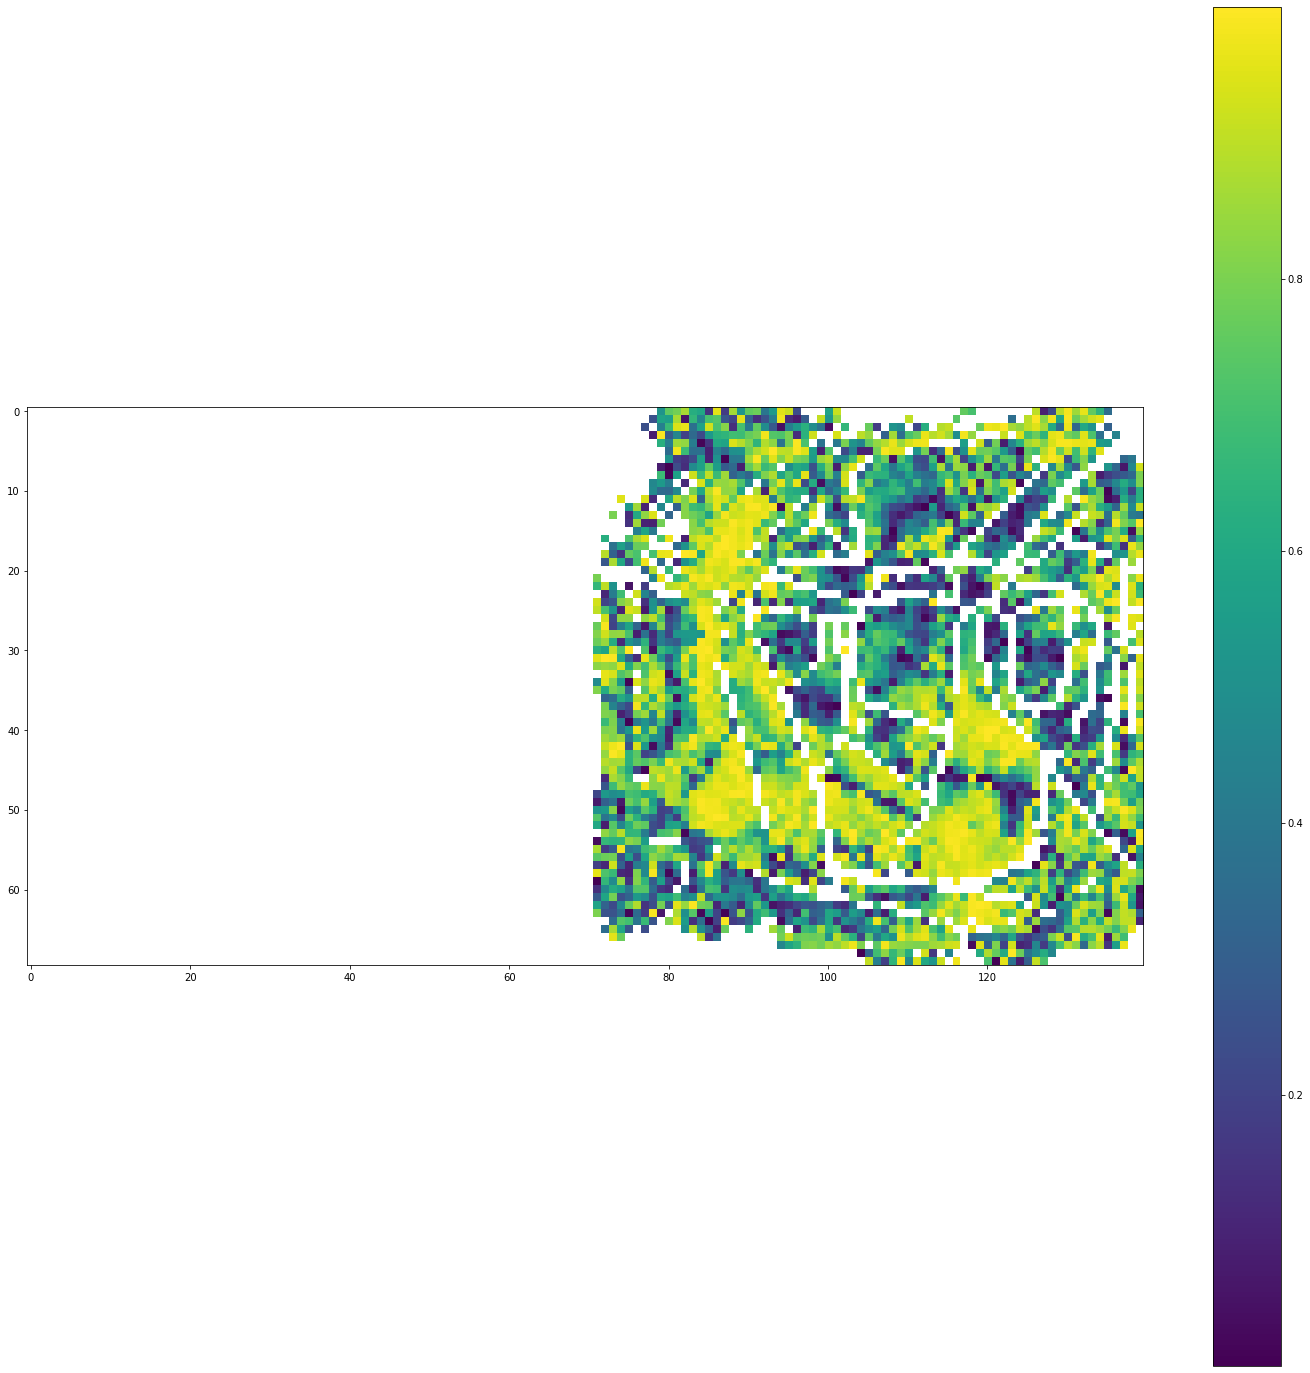

In [107]:
distortion = local_distortion(pxl, aff_viz, plot=True)

Text(0, 0.5, 'Mean distortion')

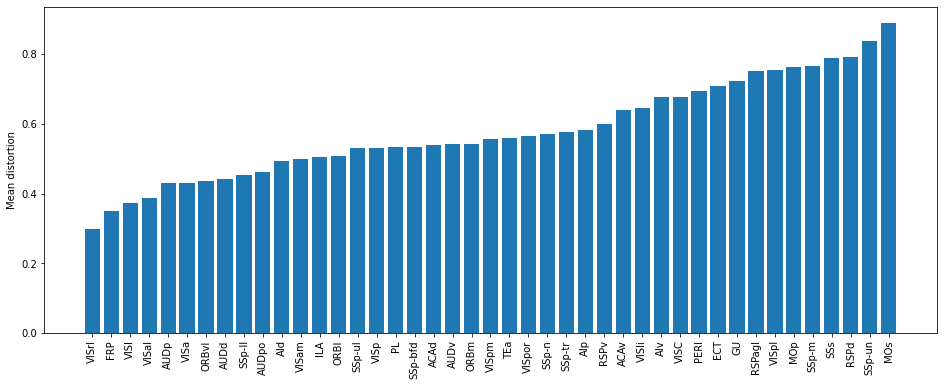

In [108]:
reg_name, vals = zip(*distortion.items())
idxx = numpy.argsort(vals)
reg_name = [reg_name[i] for i in idxx]
vals = [vals[i] for i in idxx]
ax = plt.figure(figsize=(16, 6)).gca()
ax.bar(range(len(reg_name)), vals)
ax.set_xticks(range(len(reg_name)))
ax.set_xticklabels(reg_name, rotation='vertical')
ax.set_ylabel("Mean distortion")

In [ ]:
[_x.data["acronym"] for _x in cortex_region_ids[1].children]

In [67]:
coordinates_to_image??

In [ ]:
ax = plt.gca()

In [ ]:
X, Y = numpy.meshgrid(range(5), range(5))
Z = X * Y
plt.imshow(Z)
plt.gca().set_ylim([-0.5, 4.5])
dy, dx = numpy.gradient(Z)
plt.quiver(X, Y, dx, dy, color='red')

In [ ]:
ax.set_ylim

# Banana ratio
We want to look at how the map displays a banana shape, which could be indicator of 2 sub-regions. For that, we will find the 3 coordinates at the extreme of the shape and compute the area of the triangle of these 3 coordinates. The following algorithm assumes that those coordinates are 'touching' the outer frame of the picture, given us 4 coordinates and thus 4 possible triangles candidates. It assumes that the expected triangle is the one with the wider area.  
Then, we compute the area of the surface of the picture and calculate the ratio between the area of the triangle and the actual surface of the map. Therefore, a higher ratio indicates a stronger banana shape.  
Note that for this method, the colours of the maps are discarded, since we are only interested at the shape we convert each picture in gray, this allows to avoid false negative pixel.

Text(0, 0.5, 'Banana ratio')

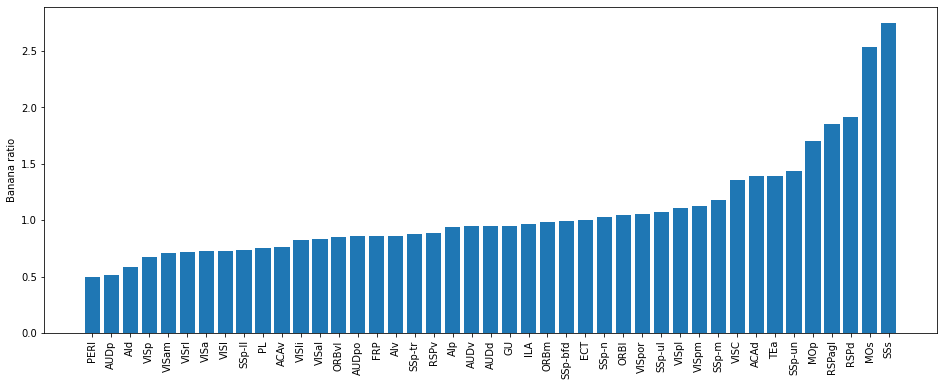

In [2]:
import voxcell
import json
import os
from matplotlib import pyplot as plt
from voxel_maps import coordinates_to_image
import os
from PIL import Image, ImageOps
import numpy as np
import itertools
from scipy.spatial import distance

def crop_pic(image):
    ''' Function to crop the pic and remove blank space and axis
    convert first in RGB and negate to remove the blank space (now black)
    then convert to gray image to avoid false negative pixel'''
    ls_pic = []
    invert_im = image.convert("RGB") 
    invert_im = ImageOps.invert(invert_im)
    imageBox = invert_im.getbbox()  
    cropped=image.crop(imageBox)
    cropped=cropped.convert("LA")
    cropped_pic = np.asarray(cropped)[:,:,0]
    # Border of y axis depends on the number of digits, 
    # this loop finds were the the value of pixel changes of 230
    for i in range(cropped_pic.shape[1]-1):
        if int(cropped_pic[0,i]) - int(cropped_pic[0,i+1]) > 230:
            border = i+1
    cropped_pic = np.delete(cropped_pic, np.s_[0:border+1], 1) # Remove pixels of y axis + frame
    cropped_pic = np.delete(cropped_pic, np.s_[0:1], 0) # Remove pixels of frame
    cropped_pic = np.delete(cropped_pic, np.s_[cropped_pic.shape[1]-1:], 1) # Remove pixels of frame
    cropped_pic = np.delete(cropped_pic, np.s_[cropped_pic.shape[0]-15:], 0) # Remove pixels of x axis 
    ls_pic.append(cropped_pic)
    return ls_pic


def find_area(ls_pic):
    '''Calculate the area between 3 extreme points, we assume that for each
    border of the frame, a pixel is touching it. Select the mean coordinate of
    these pixel, e.g. 4 pixels, and caculate the area for each combinations of
    possible triangle. Returns the biggest area and the coordinates of the 
    corners.
    '''
    pic = ls_pic[0]
    ab = np.nonzero(pic[0])
    bc = np.nonzero(pic[:,pic.shape[1]-1])
    cd = np.nonzero(pic[pic.shape[0]-1])
    da = np.nonzero(pic[:,0])
    
    coor1 = (0, round(np.mean(ab)))
    coor2 = (round(np.mean(bc)), pic.shape[1]-1)
    coor3 = (pic.shape[0]-1, round(np.mean(cd)))
    coor4 = (round(np.mean(da)), 0)
    coors = [coor1, coor2, coor3, coor4]
    ls_coor = list(itertools.combinations(coors, 3))
    ls_area = []

    for i in range(len(ls_coor)):
        AB = distance.euclidean(ls_coor[i][0],ls_coor[i][1])
        BC = distance.euclidean(ls_coor[i][1],ls_coor[i][2])
        AC = distance.euclidean(ls_coor[i][0],ls_coor[i][2])
        p = (AB+BC+AC)/2
        area = np.sqrt(p*(p-AB)*(p-BC)*(p-AC))
        ls_area.append(area)
    idx = int(np.asarray(np.where(ls_area == np.amax(ls_area))))
    # print(f"The coordinates of the triangle's corners are {ls_coor[idx]}")
    return round(np.amax(ls_area))


def banana_ratio(image):
    '''Calculate the ratio between the area the triangle found and the actual
    surface of the image. A high ratio indicates a banana.
    '''
    ls_pic = crop_pic(image)
    area = find_area(ls_pic) 
    surf = np.sum(ls_pic[0] !=0)
    ratio = area/surf
    # print(ratio)
    return ratio

filelist=os.listdir('figures')
for fichier in filelist[:]: # filelist[:] makes a copy of filelist.
    if not(fichier.startswith("back")):
        filelist.remove(fichier)
# print(filelist)

import pandas as pd
df_ratio = pd.DataFrame({})
for i in filelist:
    image = Image.open(f'figures/{i}')
    df_ratio.at[f'{i}', 1] = banana_ratio(image)

# Plot results
ratio = df_ratio.to_dict()[1]
reg_name, vals = zip(*ratio.items())
idxx = np.argsort(vals)
reg_name = [reg_name[i] for i in idxx]
for i in range(len(reg_name)):
    reg_name[i] = reg_name[i].replace('backward_', '')
    reg_name[i] = reg_name[i].replace('.png', '')
vals = [vals[i] for i in idxx]
ax = plt.figure(figsize=(16, 6)).gca()
ax.bar(range(len(reg_name)), vals)
ax.set_xticks(range(len(reg_name)))
ax.set_xticklabels(reg_name, rotation='vertical')
ax.set_ylabel("Banana ratio")

Another visualization by scaling the values to 1 (e.g. all values - 1).

Text(0, 0.5, 'Banana ratio')

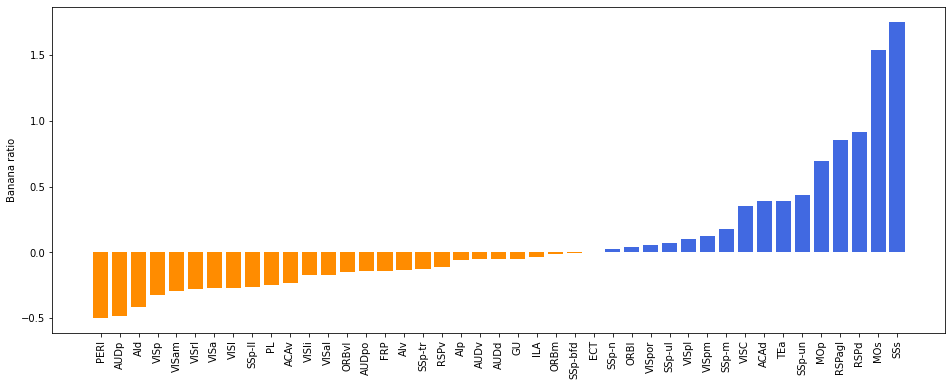

In [4]:
ratio = df_ratio.to_dict()[1]
reg_name, vals_b = zip(*ratio.items())
idxx = np.argsort(vals_b)
reg_name = [reg_name[i] for i in idxx]
for i in range(len(reg_name)):
    reg_name[i] = reg_name[i].replace('backward_', '')
    reg_name[i] = reg_name[i].replace('.png', '')
vals_b = [vals_b[i] for i in idxx]
for i in range(len(vals_b)):
    vals_b[i] = vals_b[i] - 1
ar = np.asarray(vals_b)
colors = np.array(['darkorange']*len(vals_b))
colors[ar >= 0] = ['royalblue']
ax = plt.figure(figsize=(16, 6)).gca()
ax.bar(range(len(reg_name)), vals_b, color=colors)
ax.set_xticks(range(len(reg_name)))
ax.set_xticklabels(reg_name, rotation='vertical')
ax.set_ylabel("Banana ratio")

This algorithm comes with limitations due to its assumptions, for example the selection of coordinates could not be optimal for all maps, the following algorithm displays the coordinates of the triangle taken for each map.

ACAd


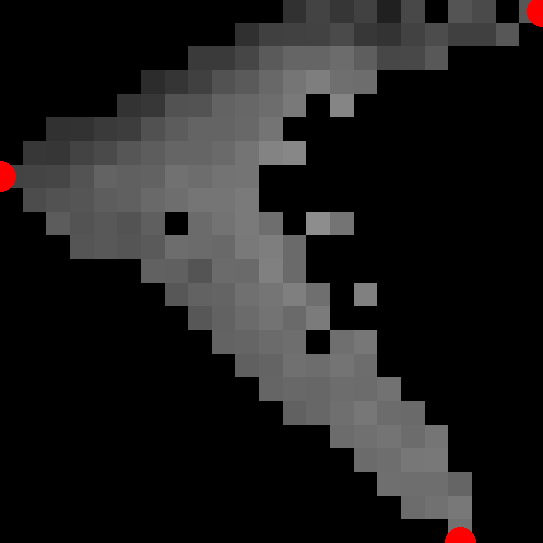

ACAv


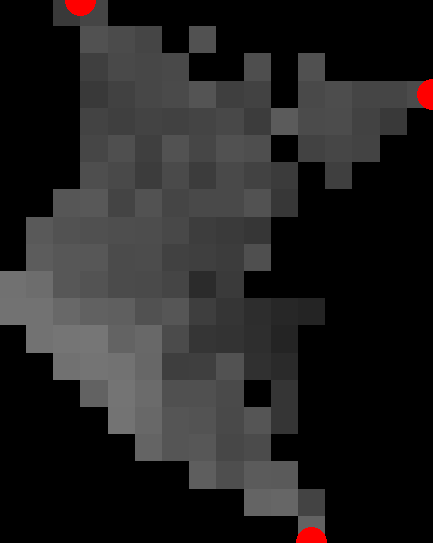

AId


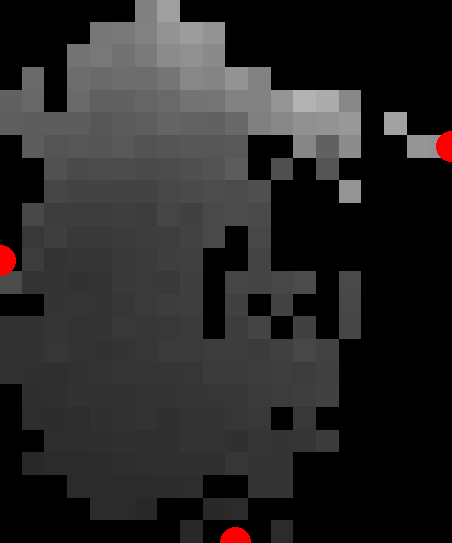

AIp


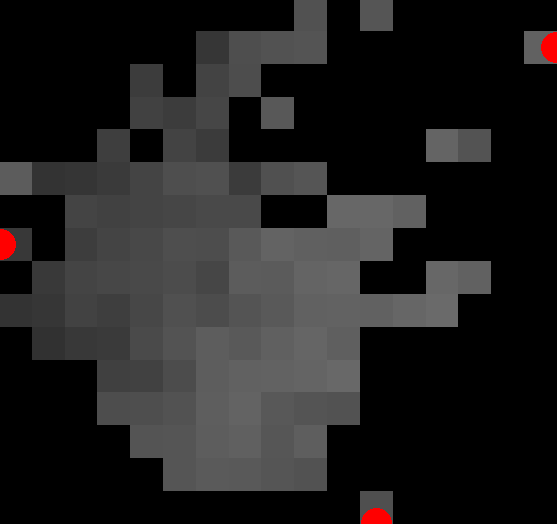

AIv


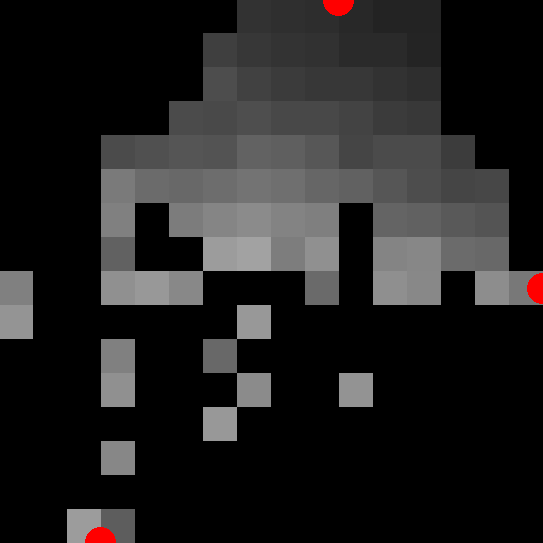

AUDd


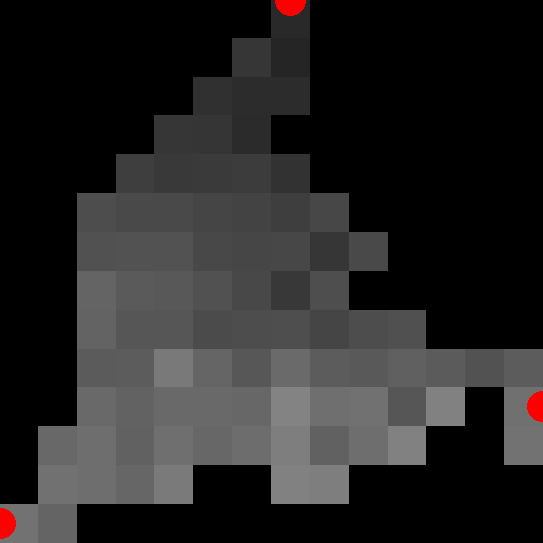

AUDp


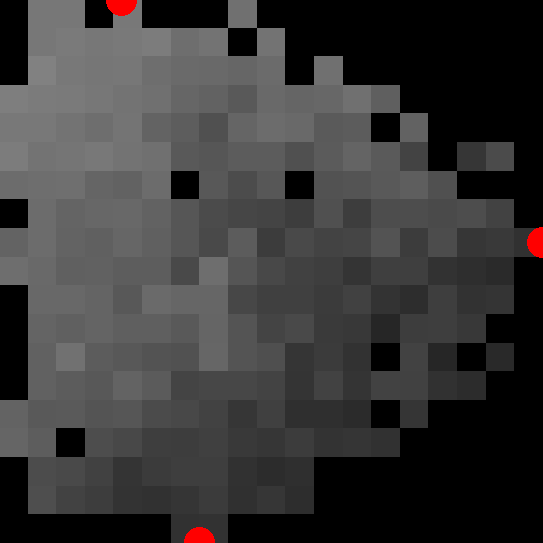

AUDpo


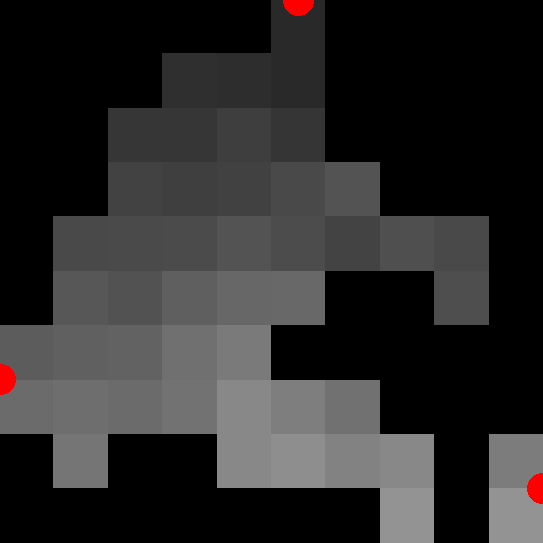

AUDv


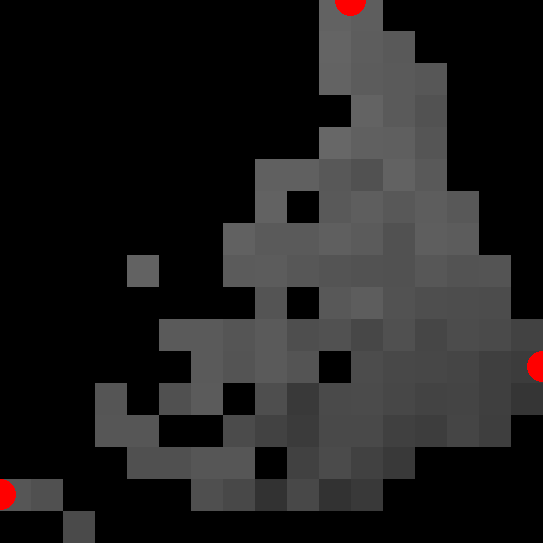

ECT


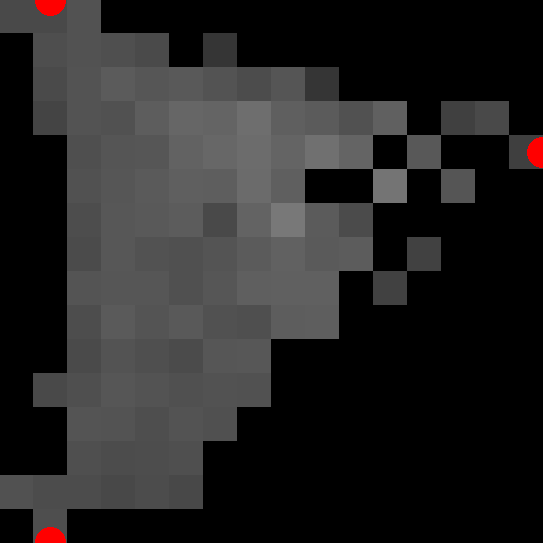

FRP


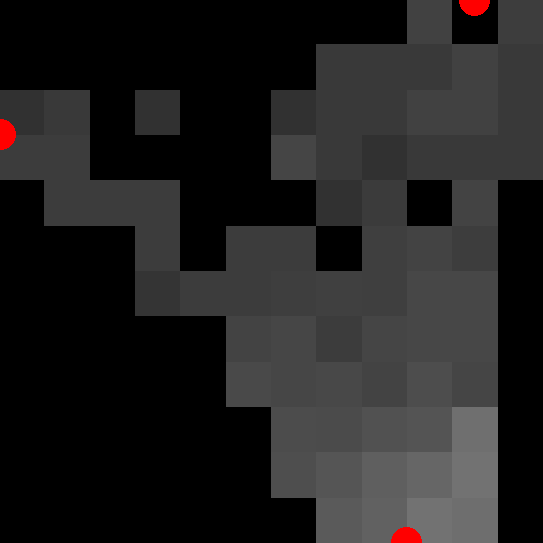

GU


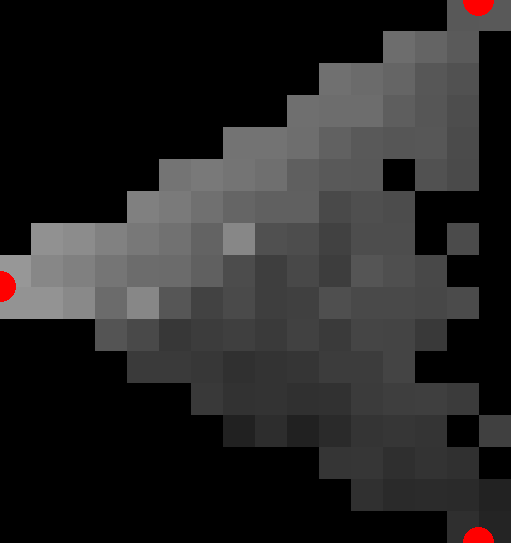

ILA


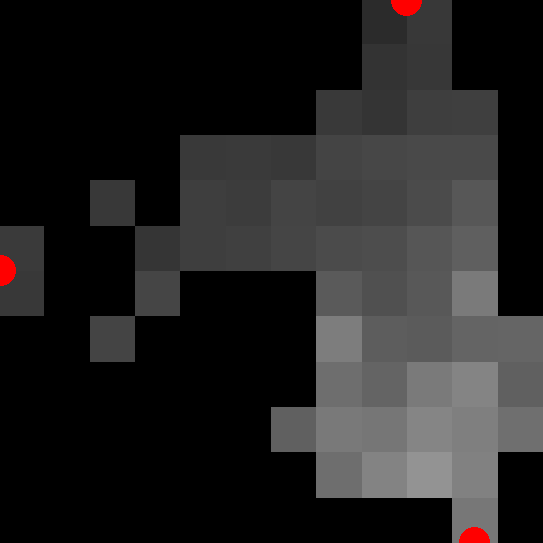

MOp


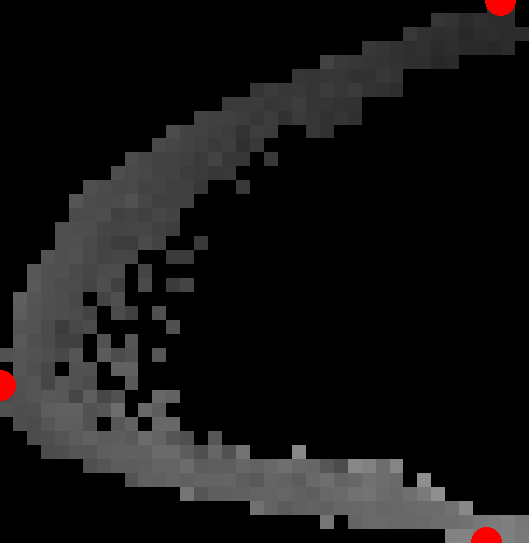

MOs


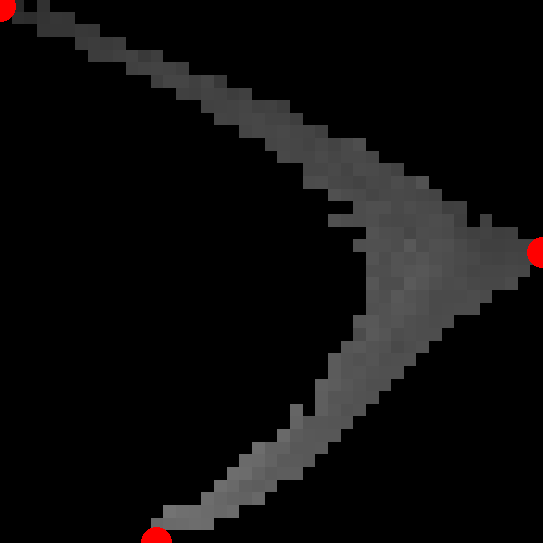

ORBl


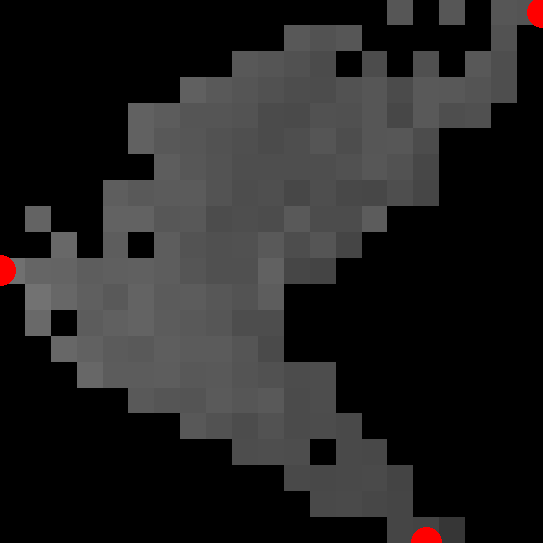

ORBm


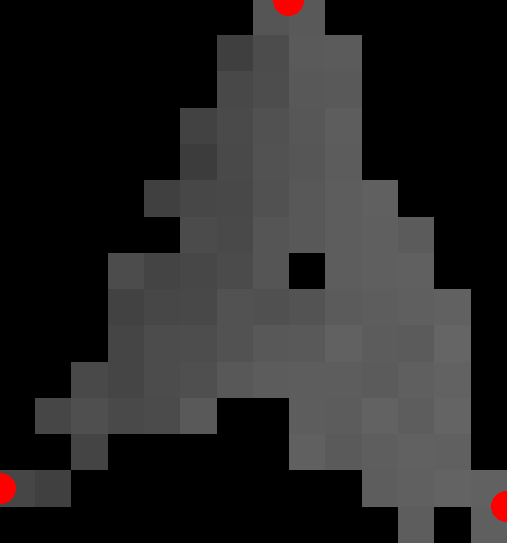

ORBvl


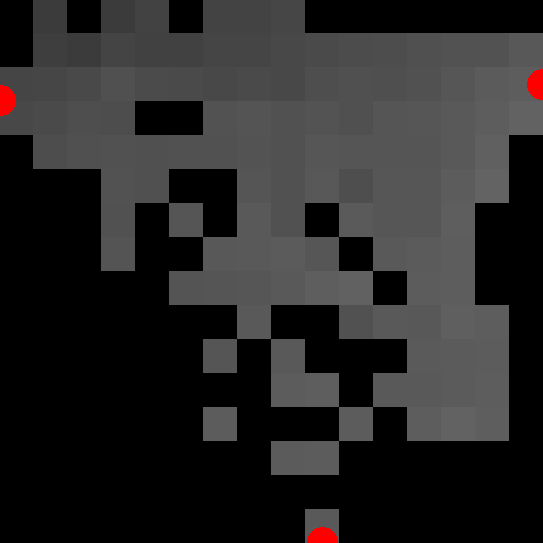

PERI


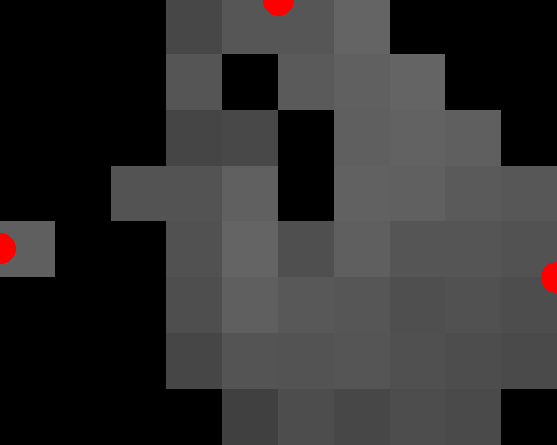

PL


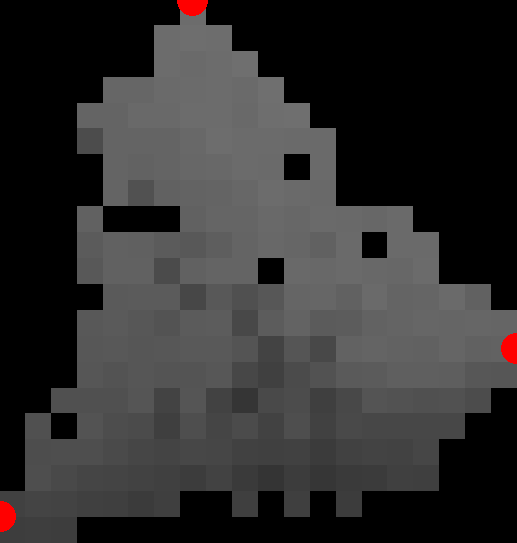

RSPagl


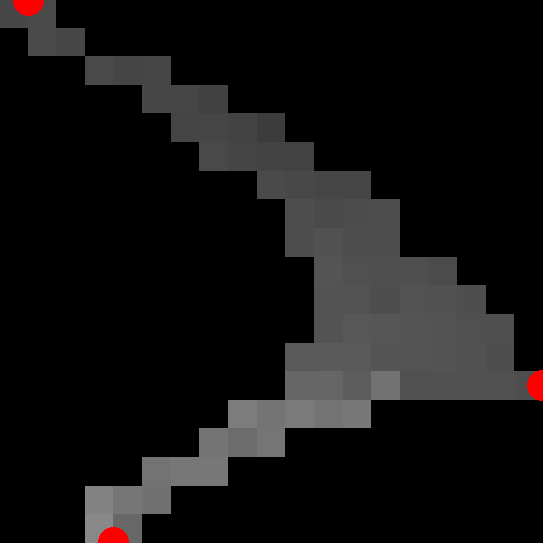

RSPd


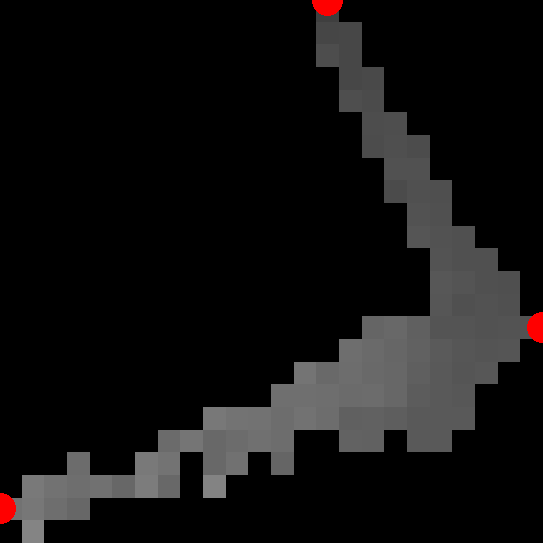

RSPv


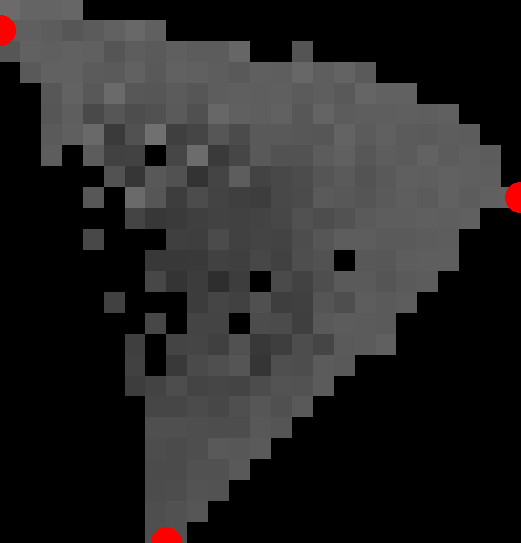

SSp-bfd


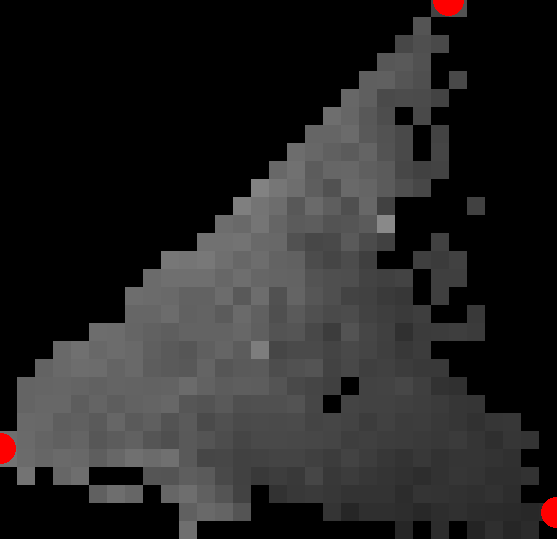

SSp-ll


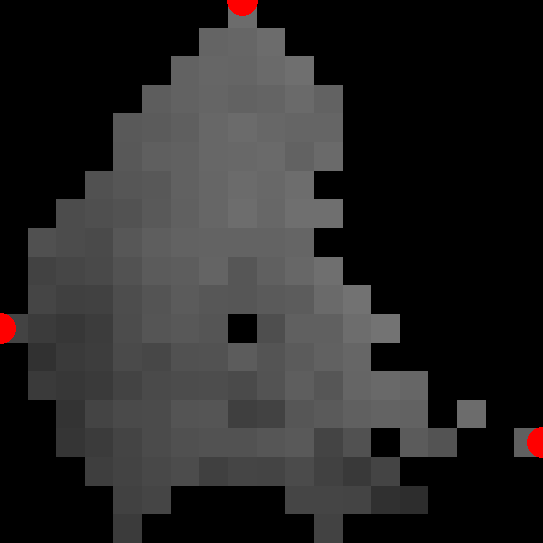

SSp-m


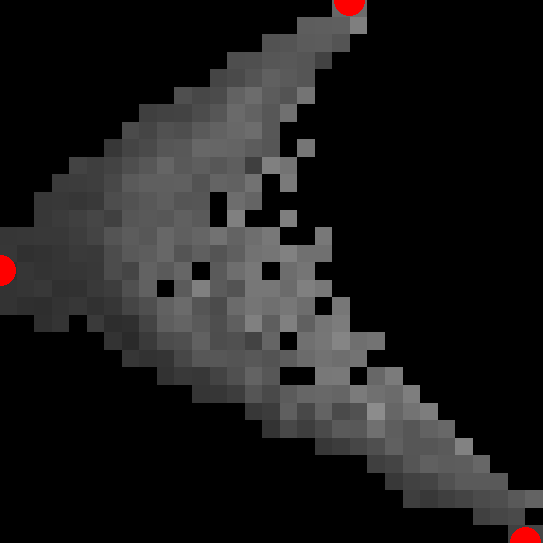

SSp-n


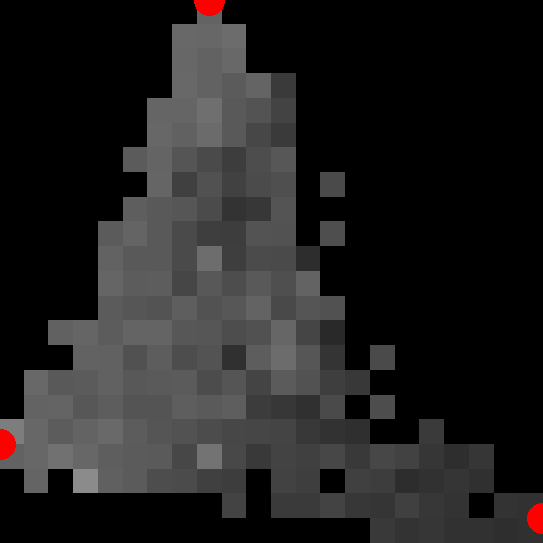

SSp-tr


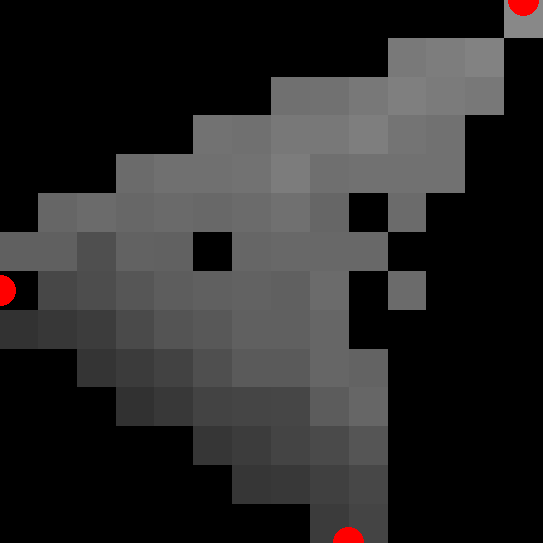

SSp-ul


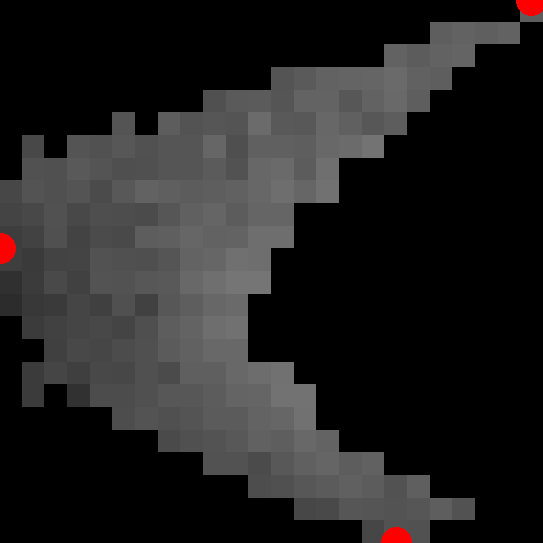

SSp-un


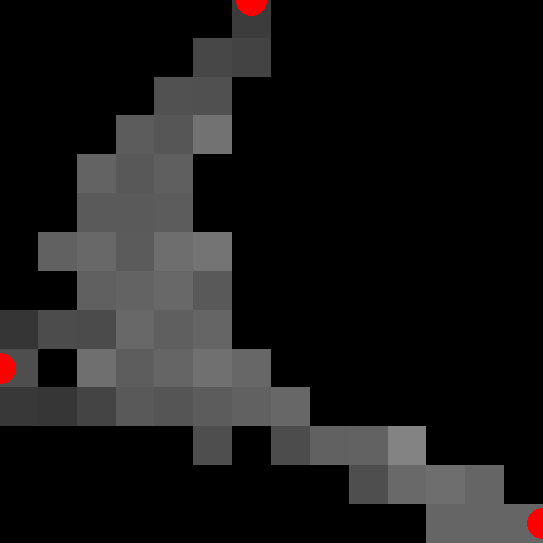

SSs


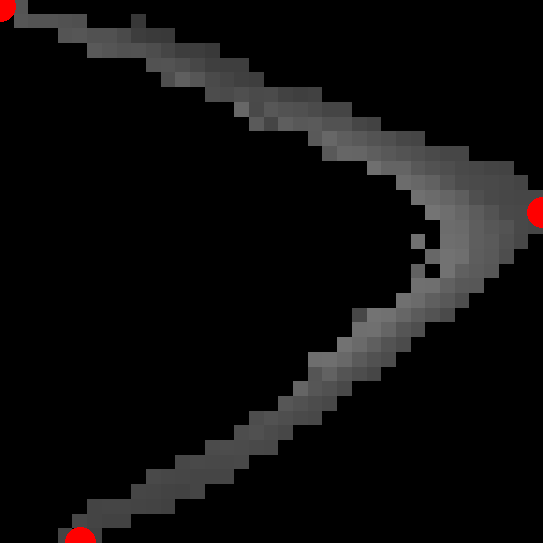

TEa


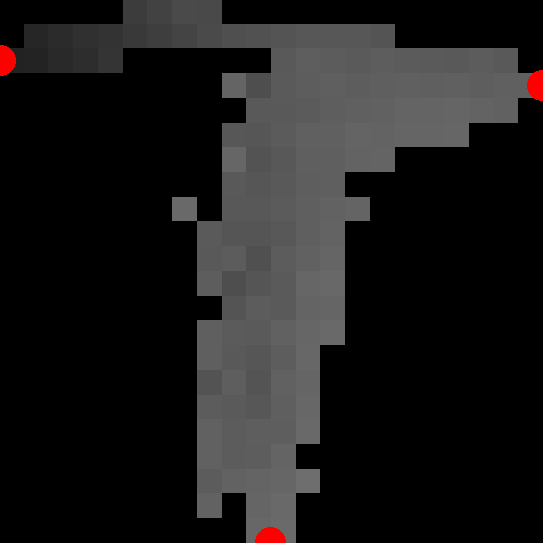

VISa


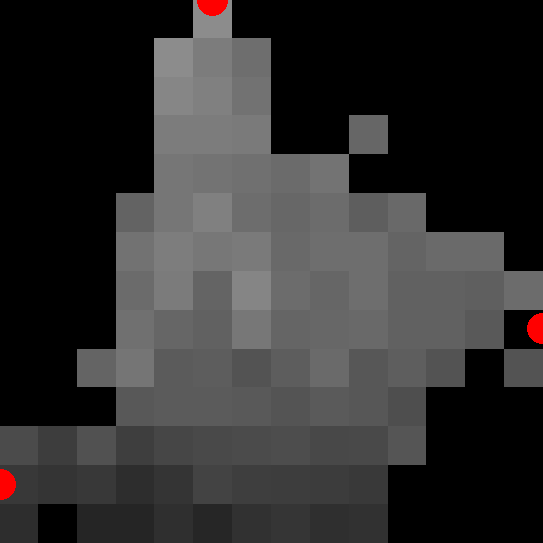

VISal


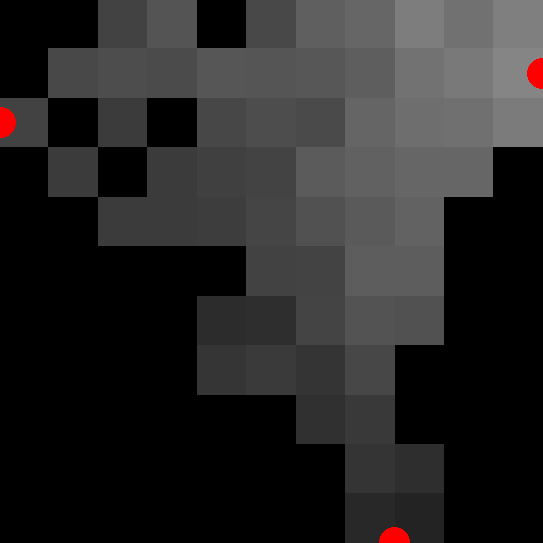

VISam


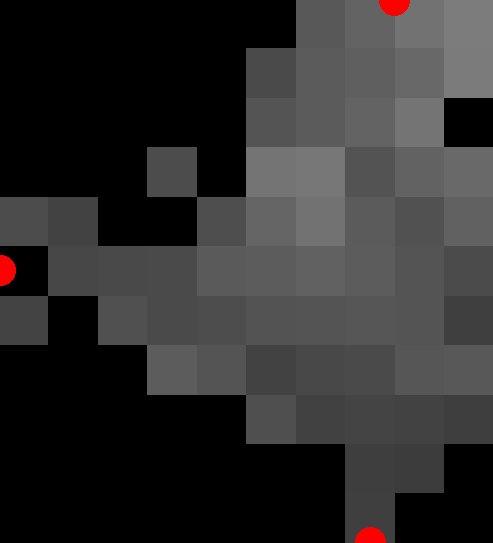

VISC


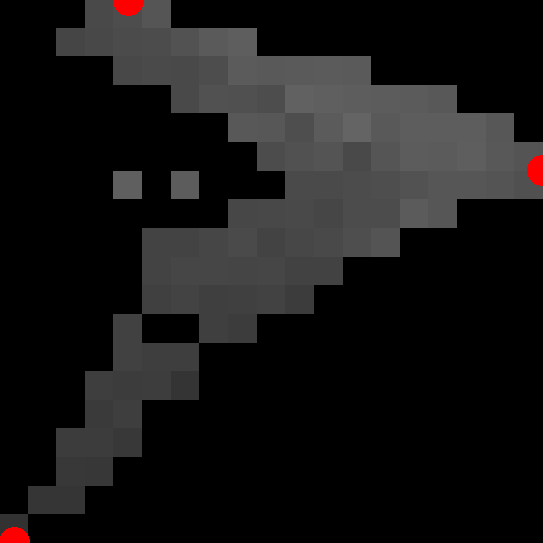

VISl


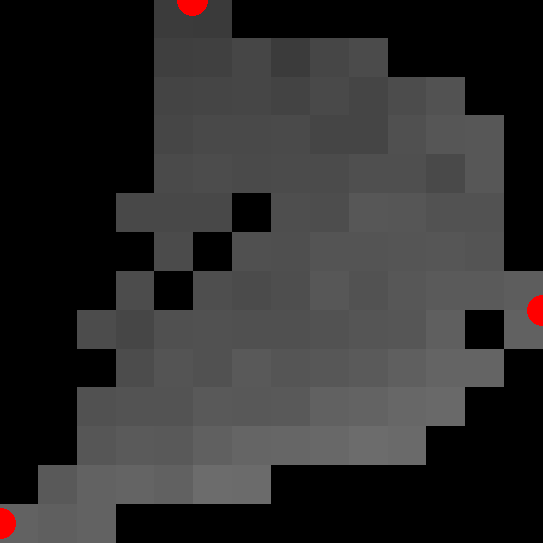

VISli


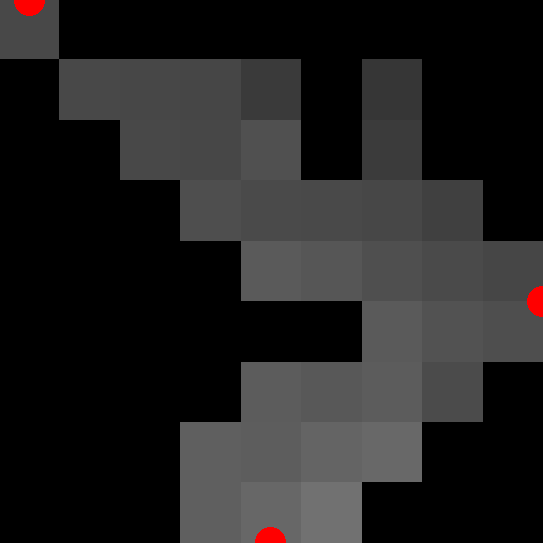

VISp


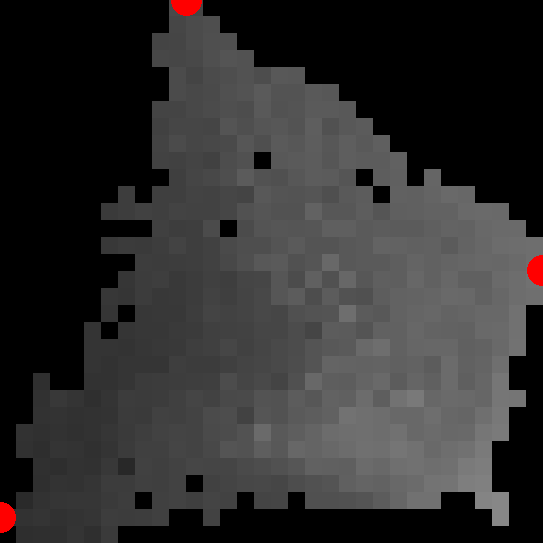

VISpl


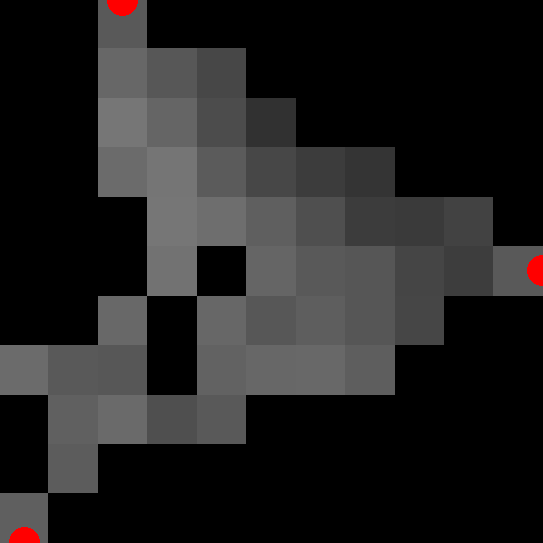

VISpm


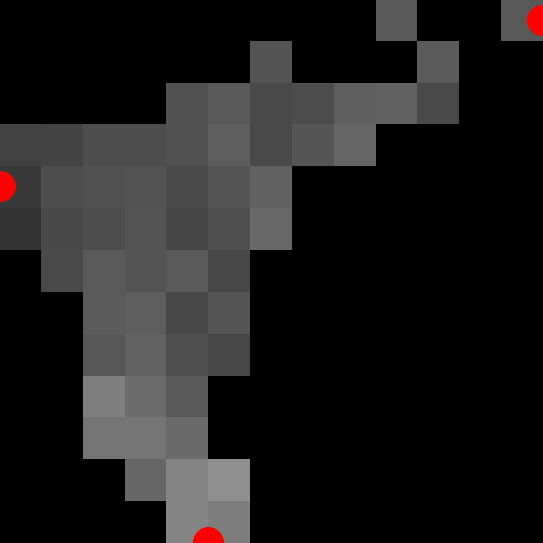

VISpor


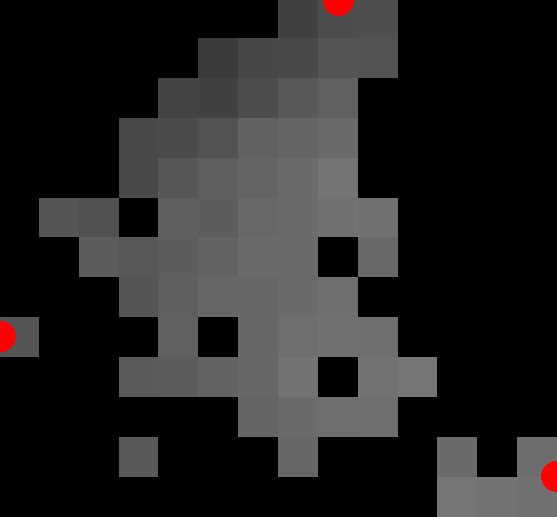

VISrl


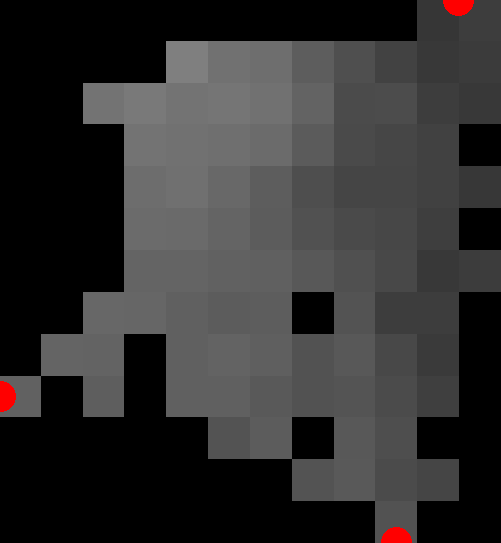

In [12]:
from PIL import ImageDraw
from IPython.display import display

def crop_pic(image):
    ''' Function to crop the pic and remove blank space and axis
    convert first in RGB and negate to remove the blank space (now black)
    then convert to gray image to avoid false negative pixel'''
    ls_pic = []
    invert_im = image.convert("RGB") 
    invert_im = ImageOps.invert(invert_im)
    imageBox = invert_im.getbbox()  
    cropped=image.crop(imageBox)
    cropped=cropped.convert("LA")
    cropped_pic = np.asarray(cropped)[:,:,0]
    # Border of y axis depends on the number of digits, 
    # this loop finds were the the value of pixel changes of 230
    for i in range(cropped_pic.shape[1]-1):
        if int(cropped_pic[0,i]) - int(cropped_pic[0,i+1]) > 230:
            border = i+1
    cropped_pic = np.delete(cropped_pic, np.s_[0:border+1], 1) # Remove pixels of y axis + frame
    cropped_pic = np.delete(cropped_pic, np.s_[0:1], 0) # Remove pixels of frame
    cropped_pic = np.delete(cropped_pic, np.s_[cropped_pic.shape[1]-1:], 1) # Remove pixels of frame
    cropped_pic = np.delete(cropped_pic, np.s_[cropped_pic.shape[0]-15:], 0) # Remove pixels of x axis 
    ls_pic.append(cropped_pic)
    return ls_pic


def find_area(ls_pic):
    '''Calculate the area between 3 extreme points, we assume that for each
    border of the frame, a pixel is touching it. Select the mean coordinate of
    these pixel, e.g. 4 pixels, and caculate the area for each combinations of
    possible triangle. Returns the biggest area and the coordinates of the 
    corners.
    '''
    pic = ls_pic[0]
    ab = np.nonzero(pic[0])
    bc = np.nonzero(pic[:,pic.shape[1]-1])
    cd = np.nonzero(pic[pic.shape[0]-1])
    da = np.nonzero(pic[:,0])
    
    coor1 = (0, round(np.mean(ab)))
    coor2 = (round(np.mean(bc)), pic.shape[1]-1)
    coor3 = (pic.shape[0]-1, round(np.mean(cd)))
    coor4 = (round(np.mean(da)), 0)
    coors = [coor1, coor2, coor3, coor4]
    ls_coor = list(itertools.combinations(coors, 3))
    ls_area = []

    for i in range(len(ls_coor)):
        AB = distance.euclidean(ls_coor[i][0],ls_coor[i][1])
        BC = distance.euclidean(ls_coor[i][1],ls_coor[i][2])
        AC = distance.euclidean(ls_coor[i][0],ls_coor[i][2])
        p = (AB+BC+AC)/2
        area = np.sqrt(p*(p-AB)*(p-BC)*(p-AC))
        ls_area.append(area)
    idx = int(np.asarray(np.where(ls_area == np.amax(ls_area))))
    # print(f"The coordinates of the triangle's corners are {ls_coor[idx]}")
    return round(np.amax(ls_area)), ls_coor[idx]

# For one map
image = Image.open('figures/backward_MOs.png')
crop = crop_pic(image)
area, coords = find_area(crop)

PIL_image = Image.fromarray(np.uint8(crop[0])).convert("RGB")
draw = ImageDraw.Draw(PIL_image)
for i in range(3):
    draw.ellipse((coords[i][1]-15, coords[i][0]-15, coords[i][1]+15, coords[i][0]+15),
                 fill='red', outline ='red')
# display(PIL_image)


filelist=os.listdir('figures')
for fichier in filelist[:]: # filelist[:] makes a copy of filelist.
    if not(fichier.startswith("back")):
        filelist.remove(fichier)

# For all maps
for i in filelist:
    image = Image.open(f'figures/{i}')
    crop = crop_pic(image)
    area, coords = find_area(crop)
    
    PIL_image = Image.fromarray(np.uint8(crop[0])).convert("RGB")
    draw = ImageDraw.Draw(PIL_image)
    for j in range(3):
        draw.ellipse((coords[j][1]-15, coords[j][0]-15, coords[j][1]+15, coords[j][0]+15),
                     fill='red', outline ='red')
    name = i.replace('backward_', '')
    name = name.replace('.png', '') 
    print(name)
    display(PIL_image)

# Cortico-cortical flatmap

In [6]:
flatmap_for_pixel_positions = "./diffusion_embedding_thalamic_flatmap_plus_isocortex_v2.nrrd"
aff_flatmap_to_visualize = "/gpfs/bbp.cscs.ch/home/guyonnet/data/cc_db_flatmap.nrrd"

region_atlas = "../annotation_100.nrrd"
hierarchy_fn = "../hierarchy.json"

somatomotor = ["SSp-ll", "SSp-ul", "SSp-n", "SSp-m", "SSp-tr", "SSp-bfd",
                        "SSp-un", "SSs", "MOp", "MOs"]
cortex_regions = ["FRP","MOs","ACAd","ACAv","PL","ILA","ORBl","ORBm","ORBvl",
                             "AId","AIv","AIp","GU","VISC",
                             "SSs","SSp-bfd","SSp-tr","SSp-ll","SSp-ul","SSp-un","SSp-n","SSp-m","MOp",
                             "VISal","VISl","VISp","VISpl","VISli","VISpor","VISrl",
                             "VISa","VISam","VISpm","RSPagl","RSPd","RSPv",
                             "AUDd","AUDp","AUDpo","AUDv","TEa","PERI","ECT"]

pxl = voxcell.VoxelData.load_nrrd(flatmap_for_pixel_positions)
aff_viz = voxcell.VoxelData.load_nrrd(aff_flatmap_to_visualize)
aff_viz.raw[numpy.isnan(aff_viz.raw) | (aff_viz.raw < 0)] = -1

ann = voxcell.VoxelData.load_nrrd(region_atlas)
hier = voxcell.Hierarchy.load_json(hierarchy_fn)


/gpfs/bbp.cscs.ch/home/guyonnet/venvs/my_venv/lib/python3.7/site-packages/voxel_maps/voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid r

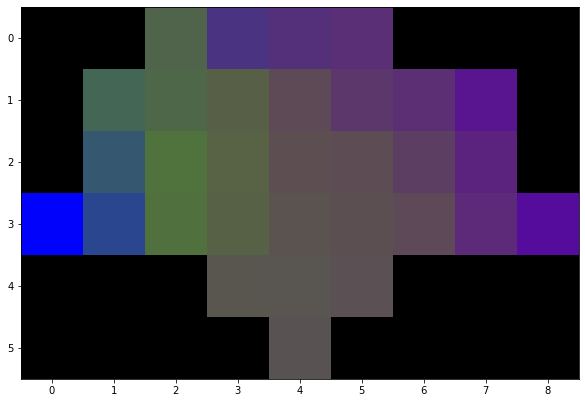

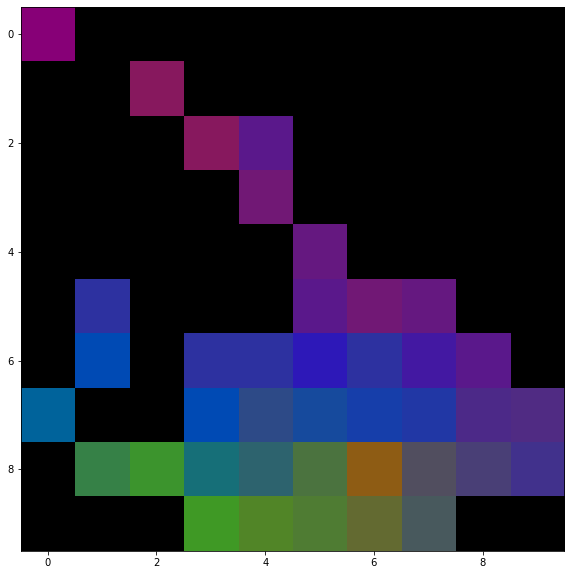

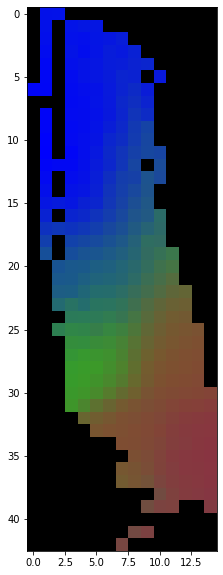

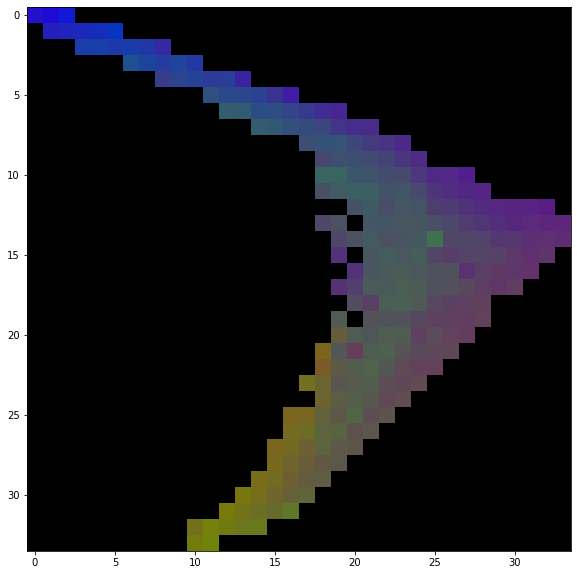

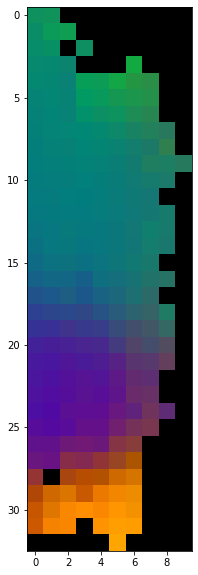

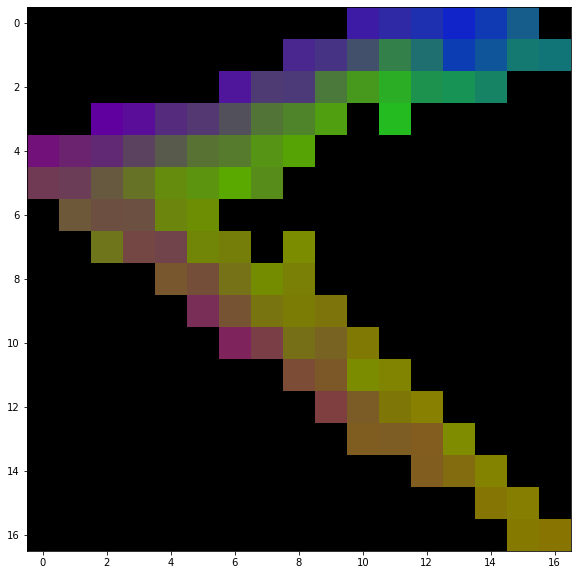

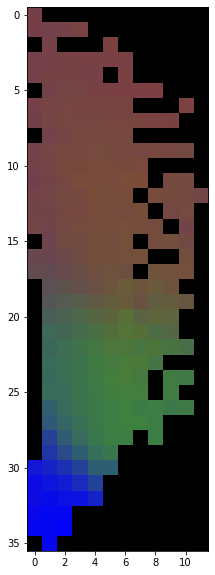

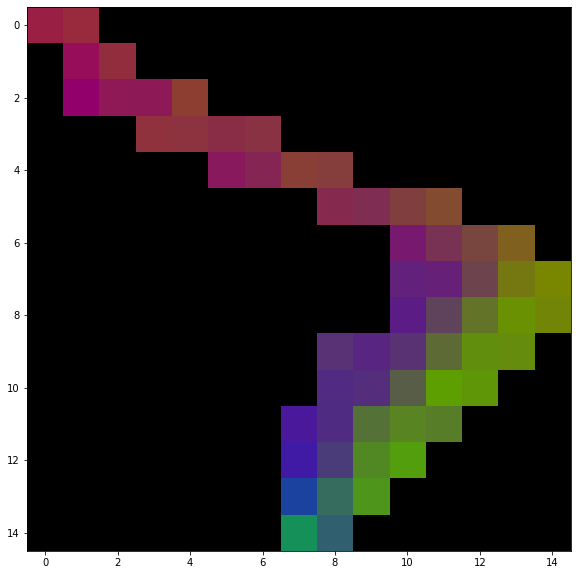

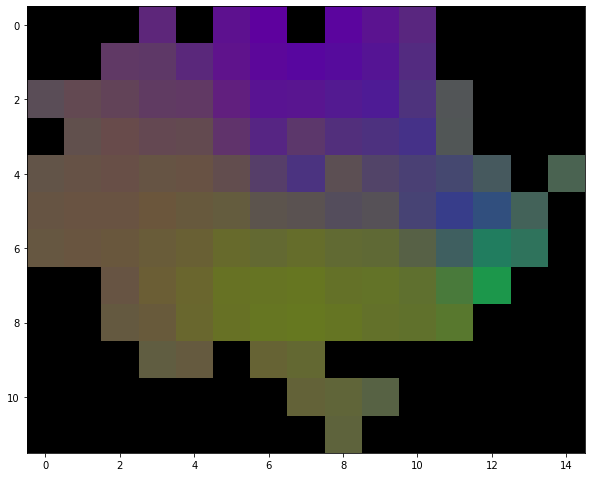

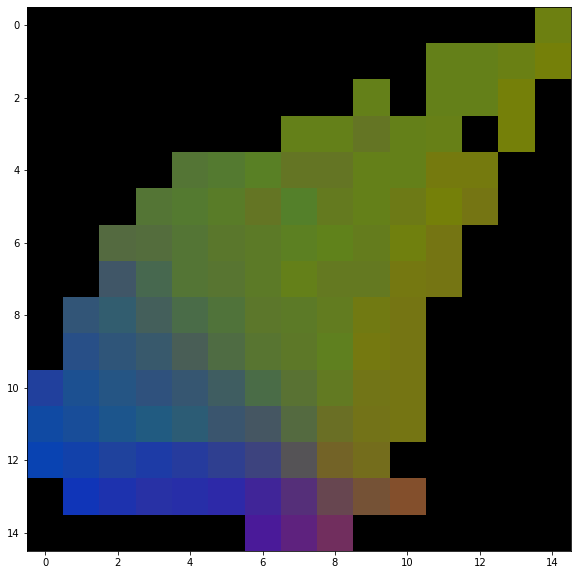

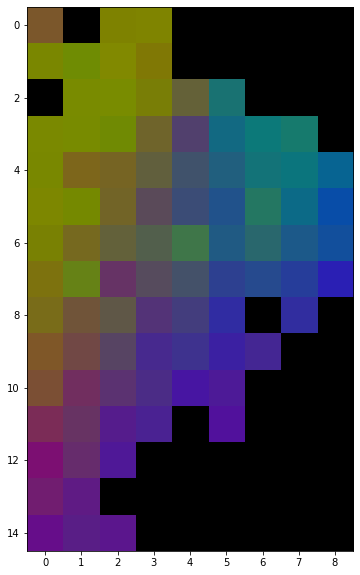

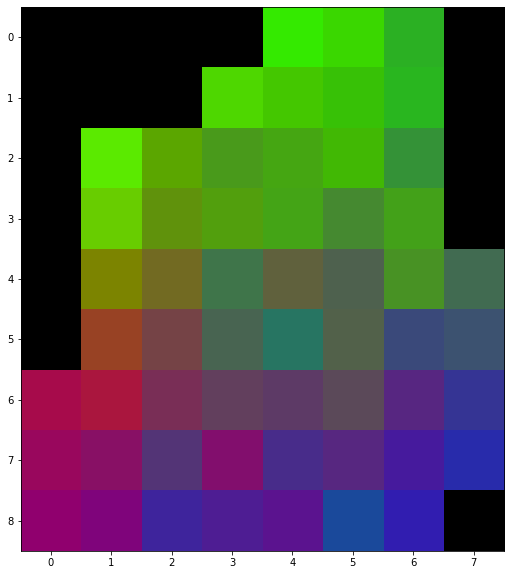

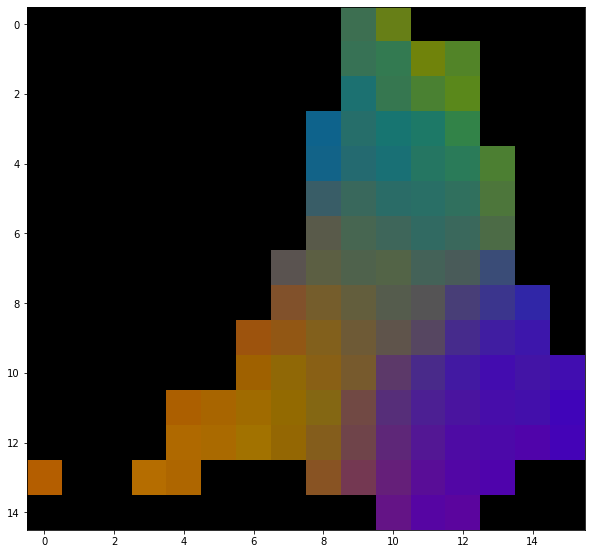

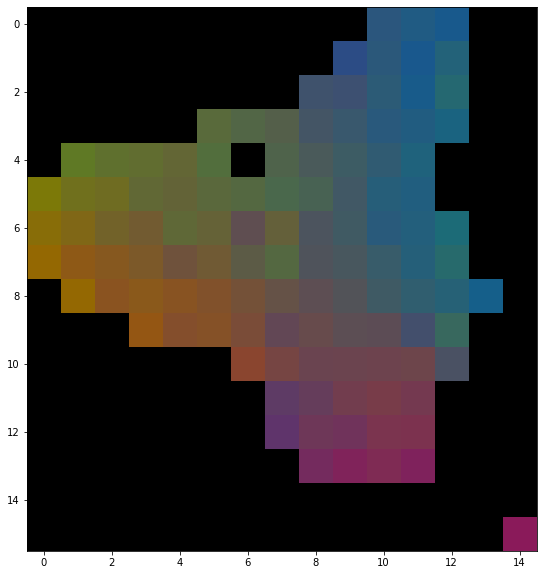

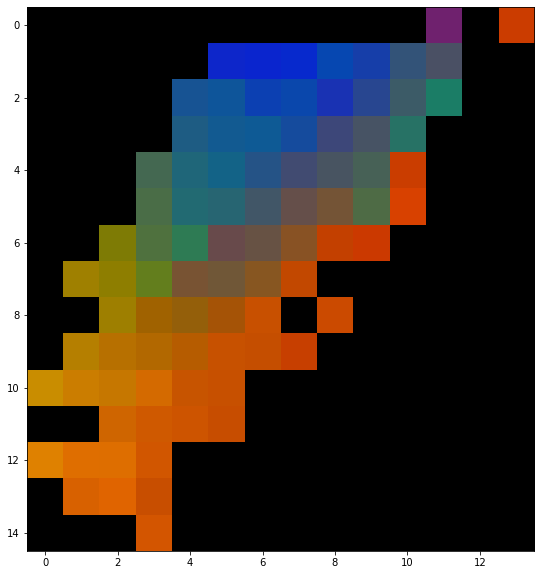

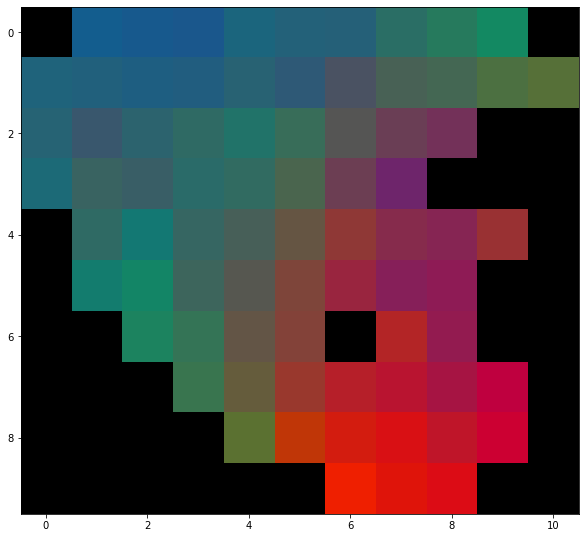

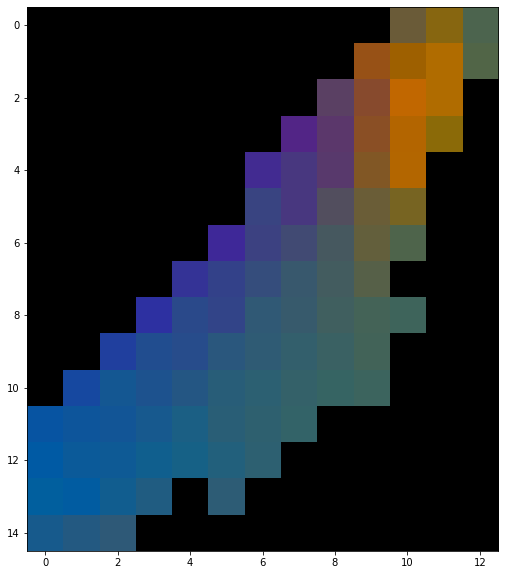

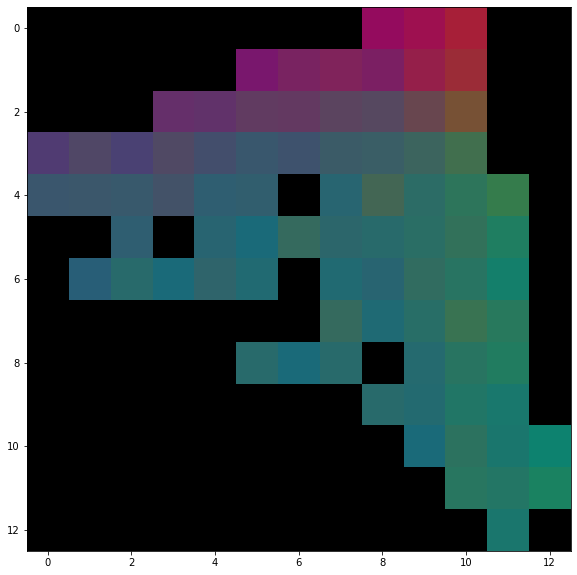

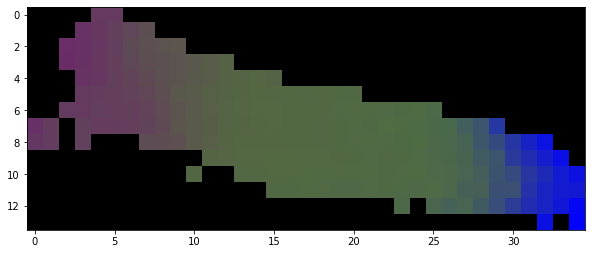

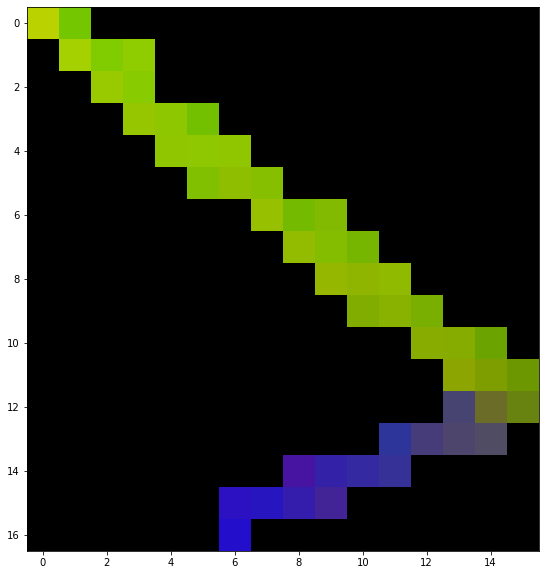

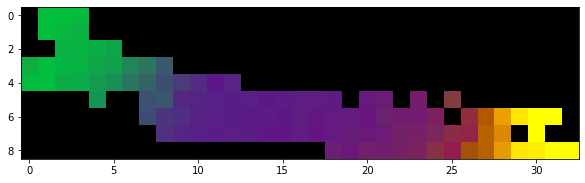

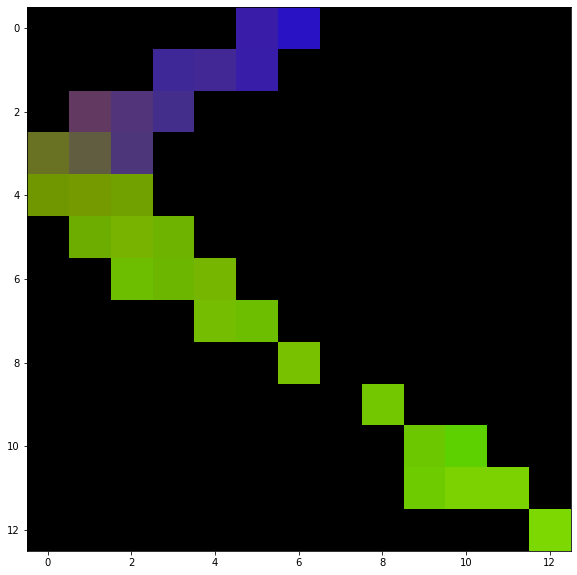

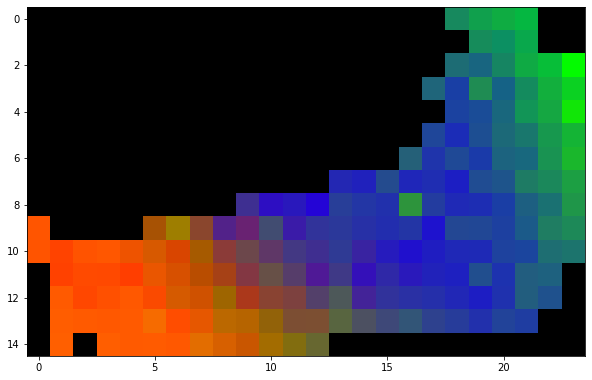

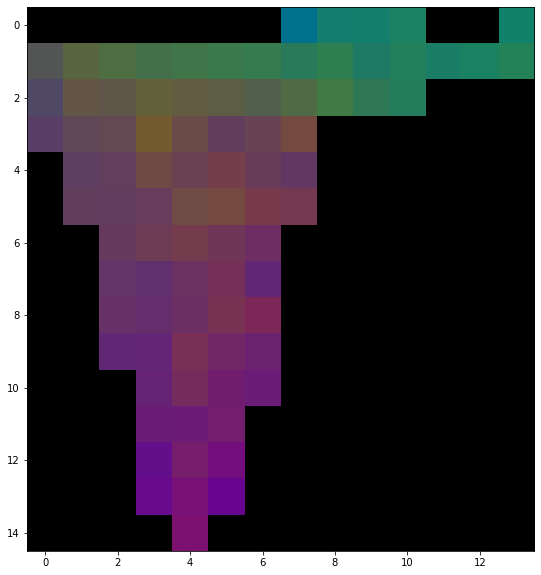

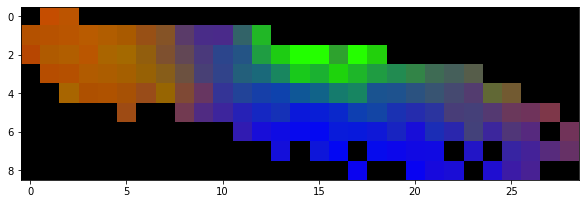

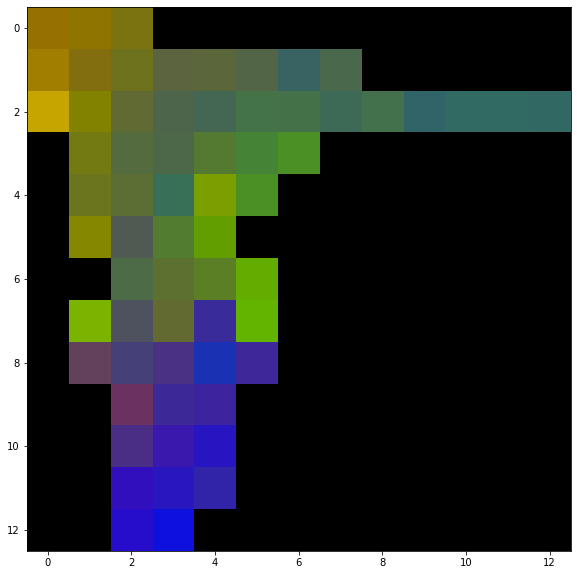

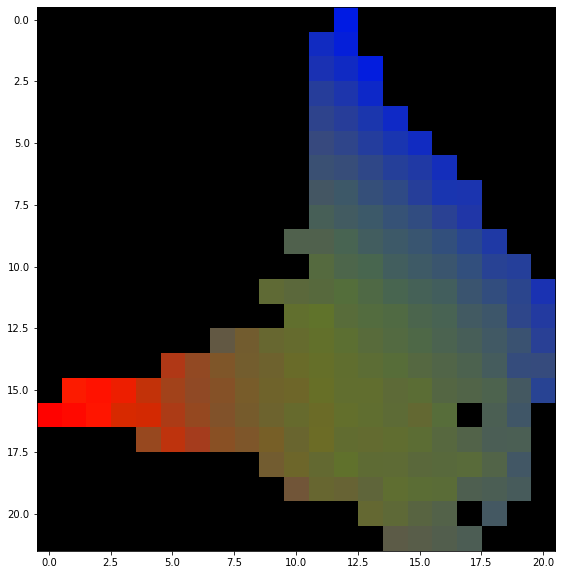

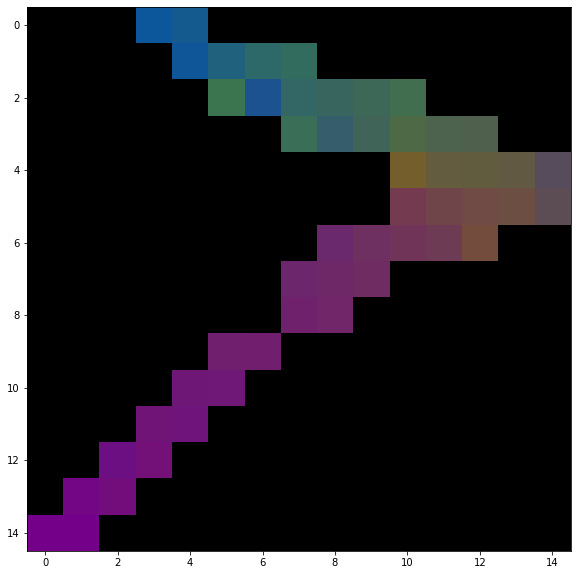

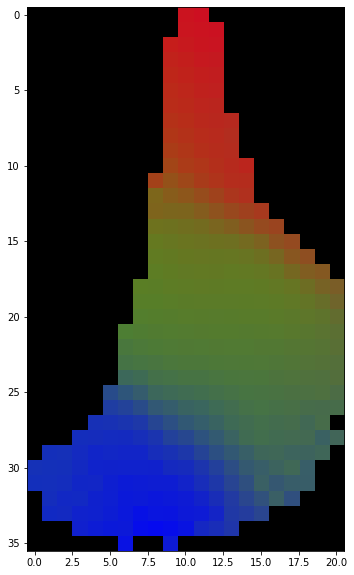

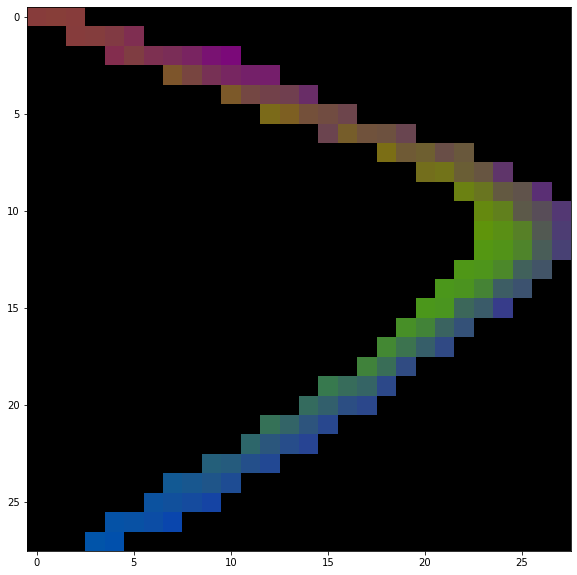

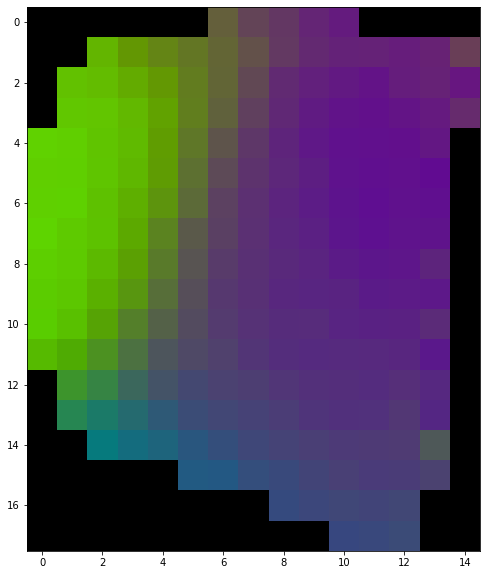

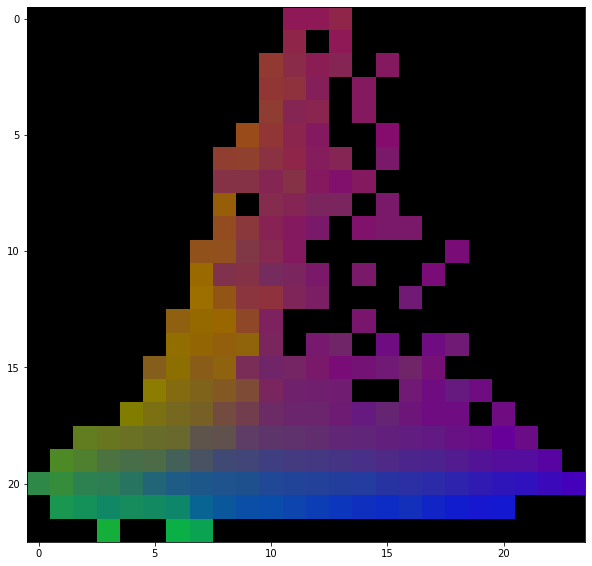

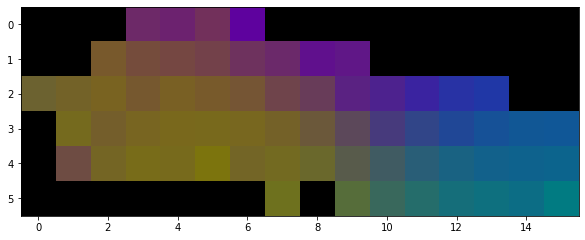

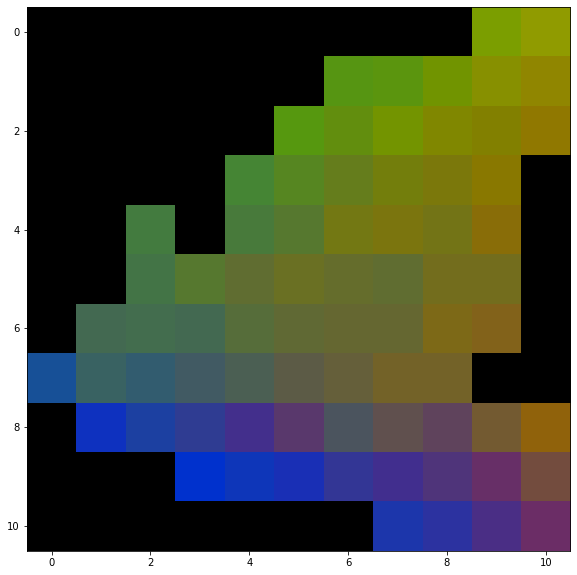

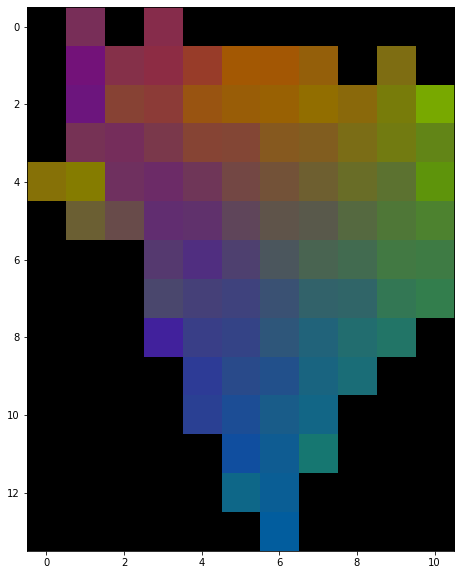

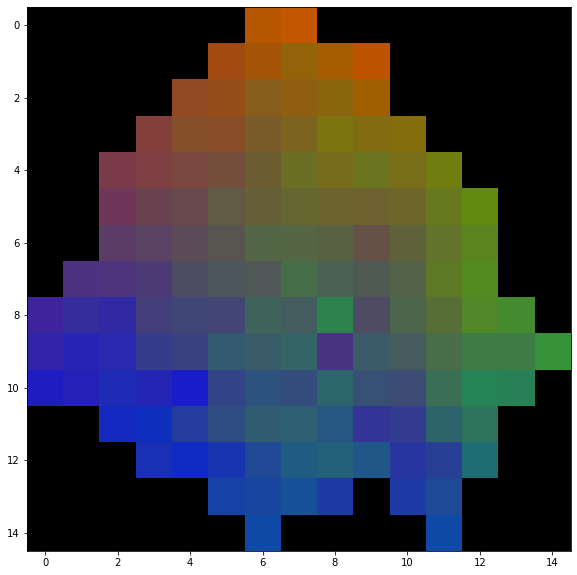

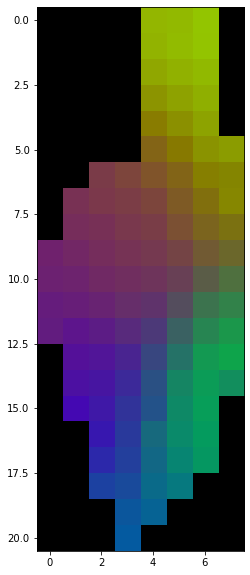

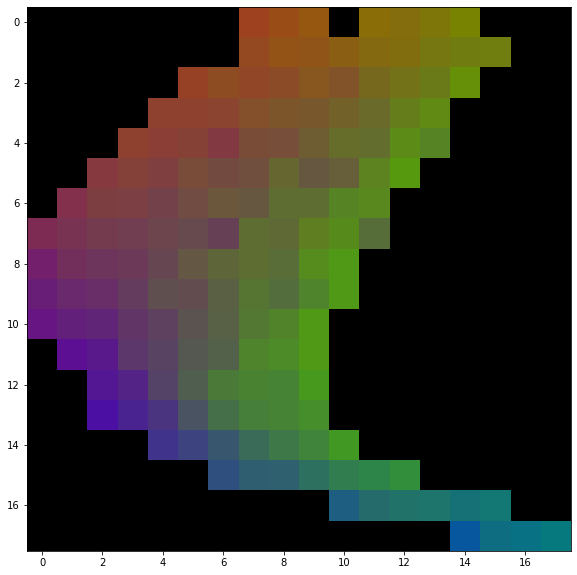

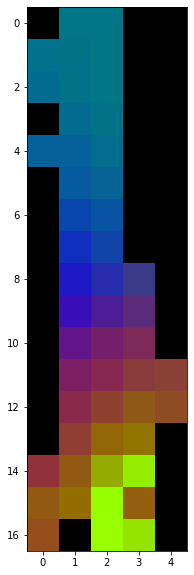

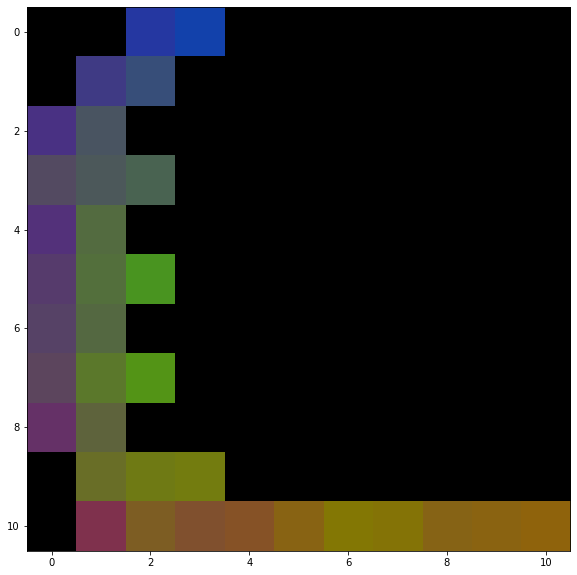

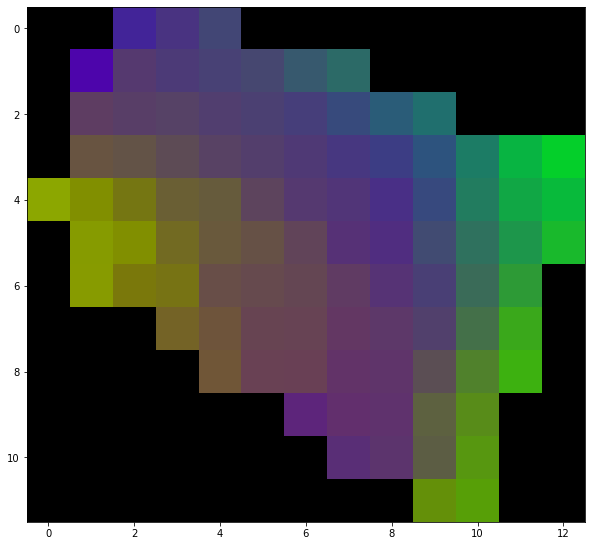

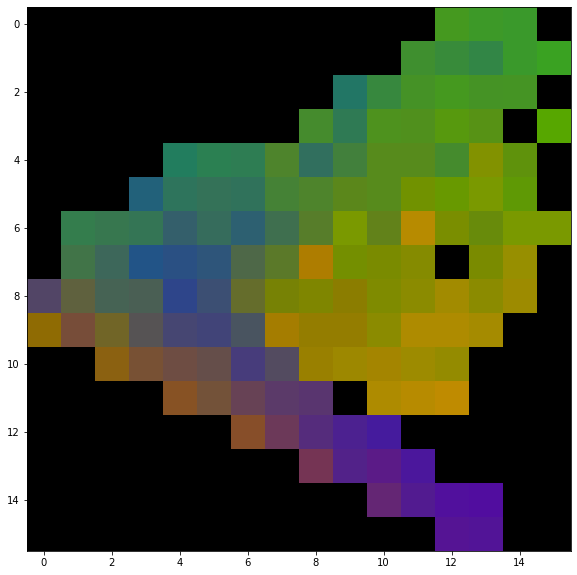

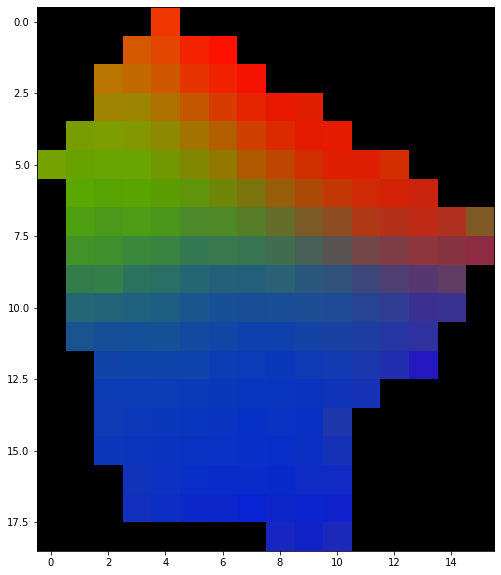

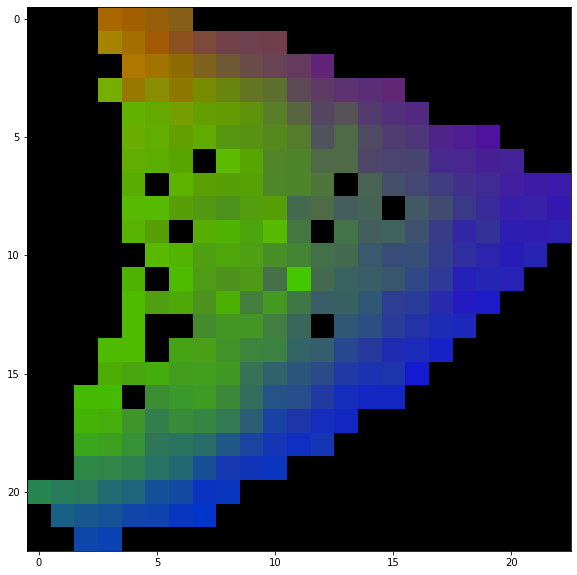

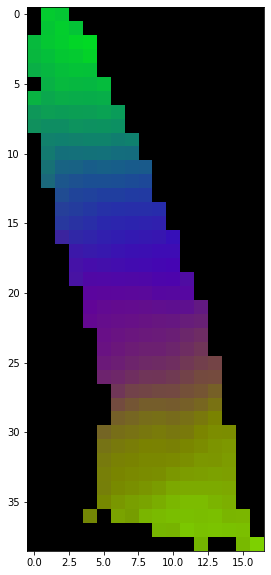

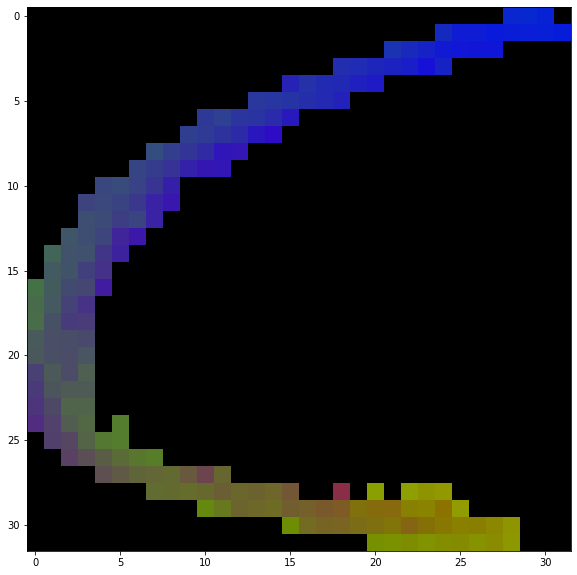

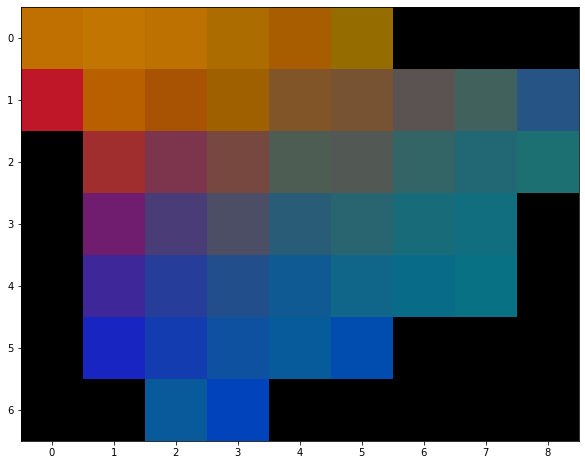

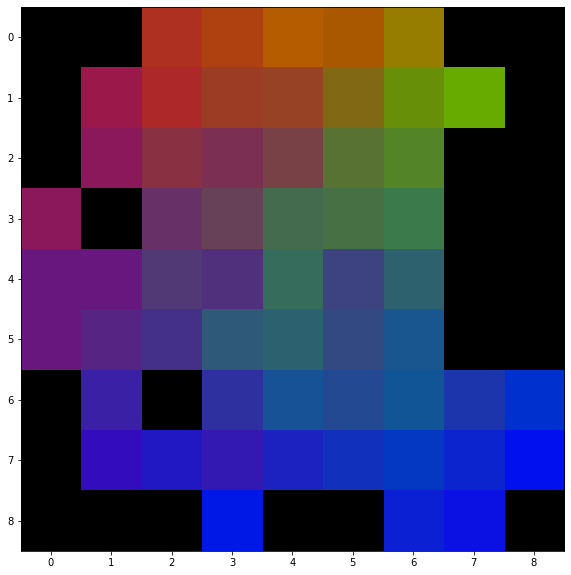

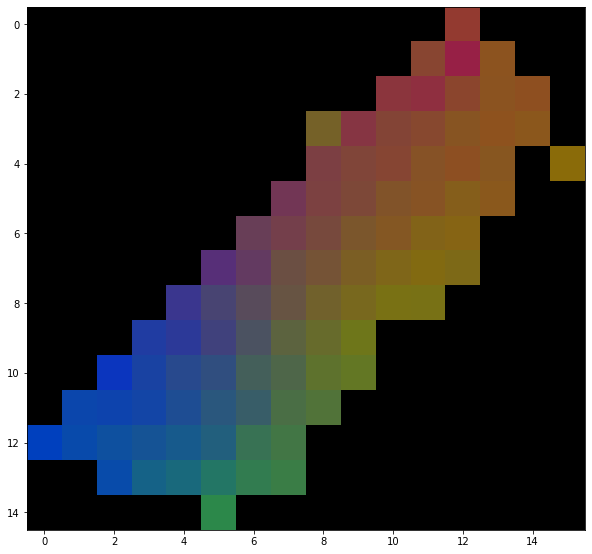

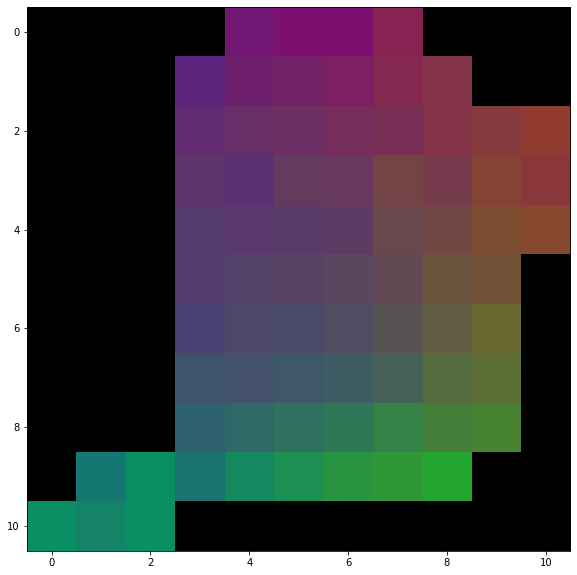

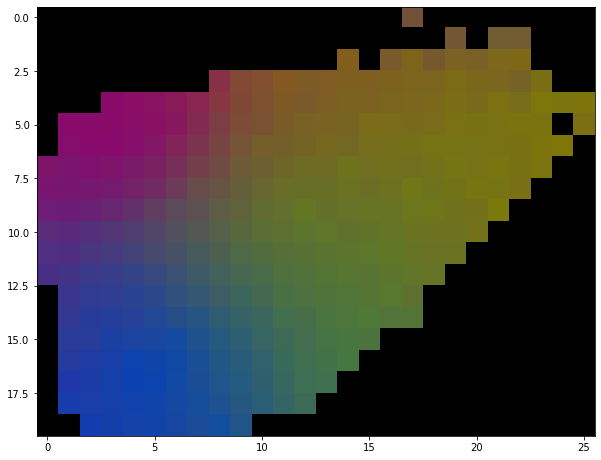

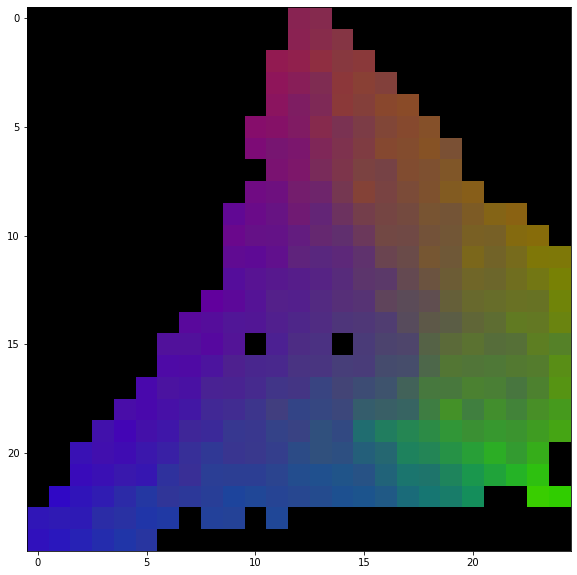

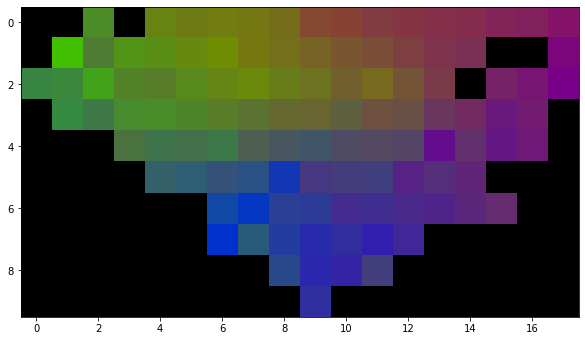

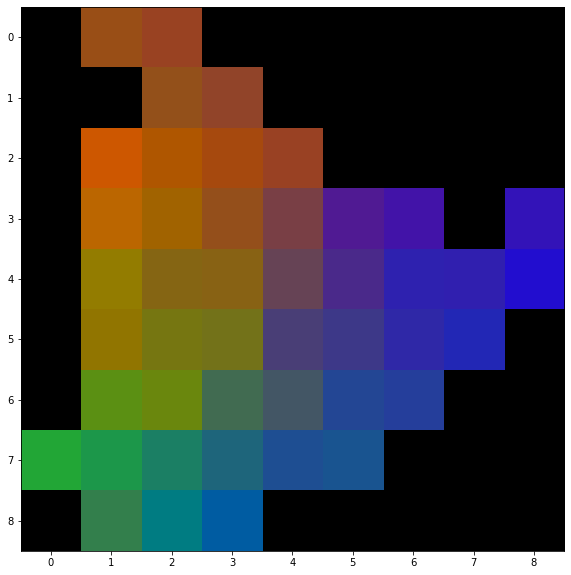

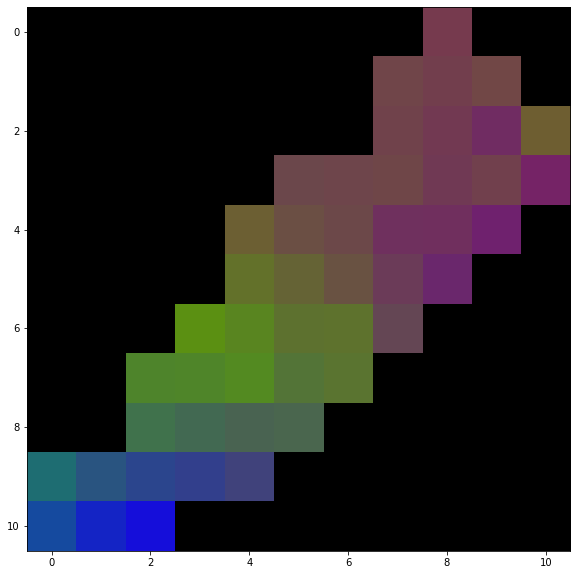

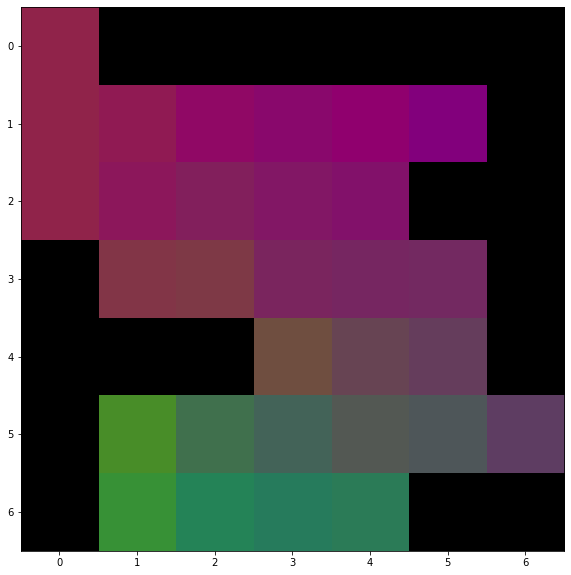

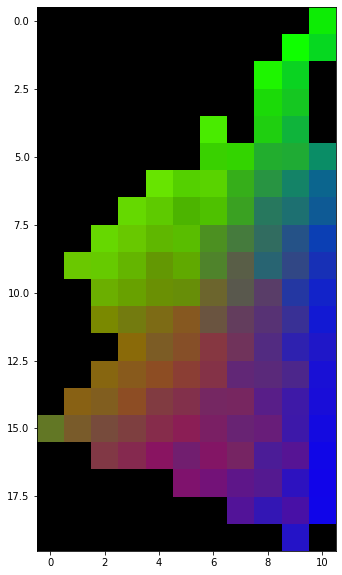

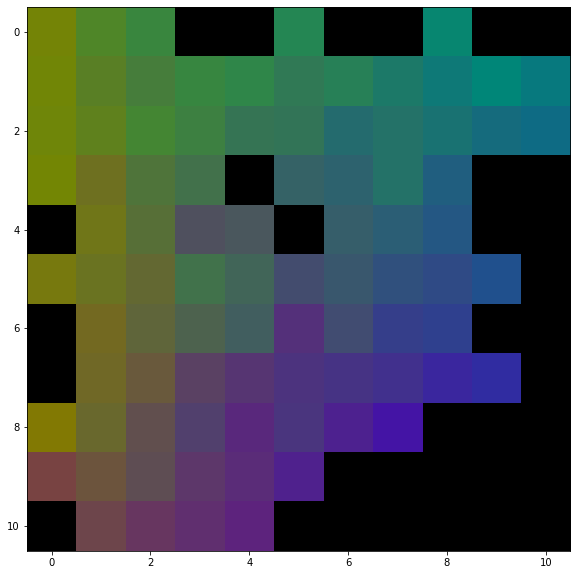

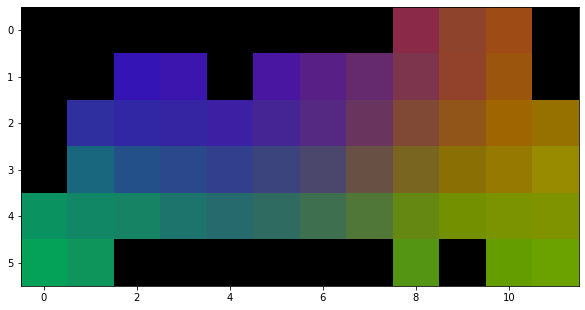

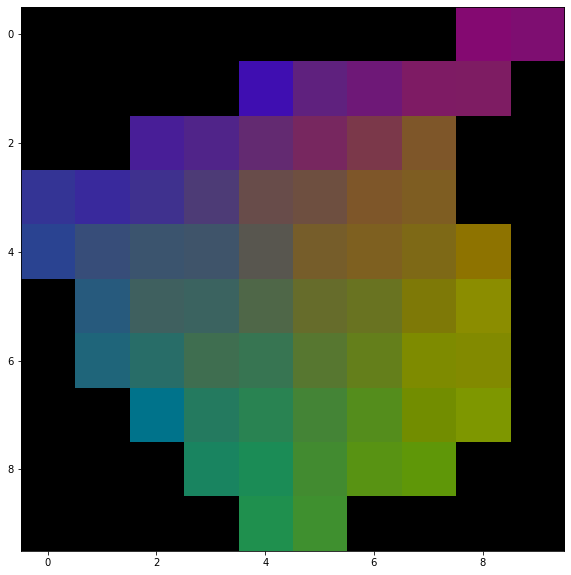

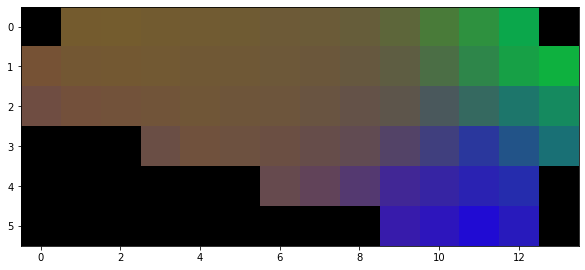

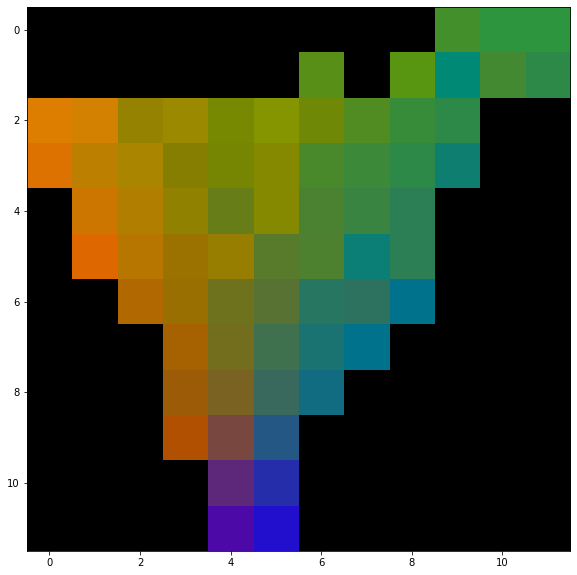

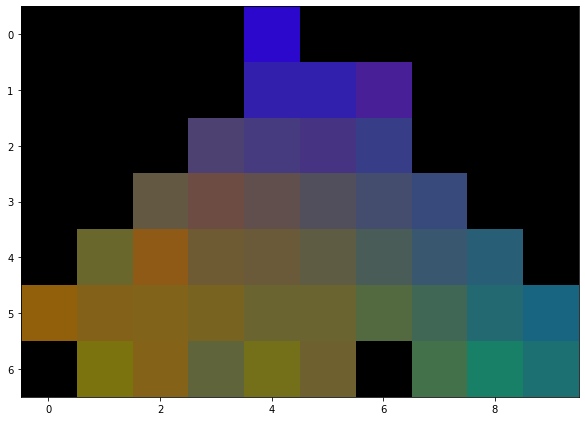

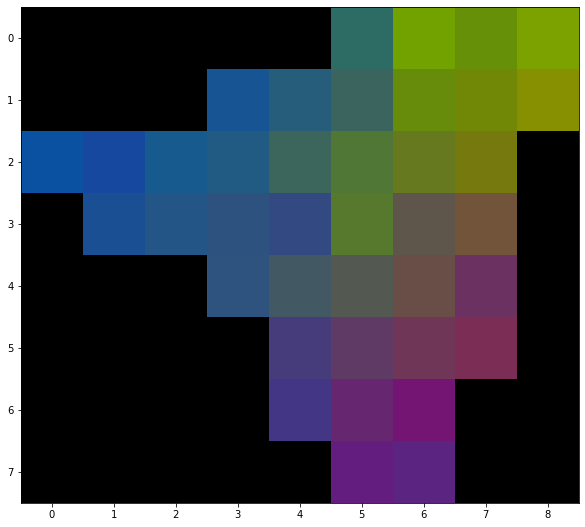

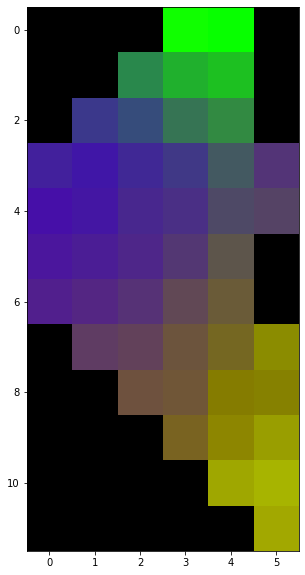

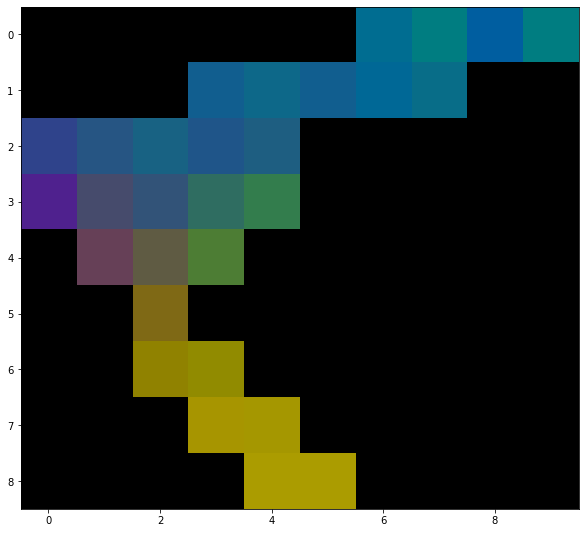

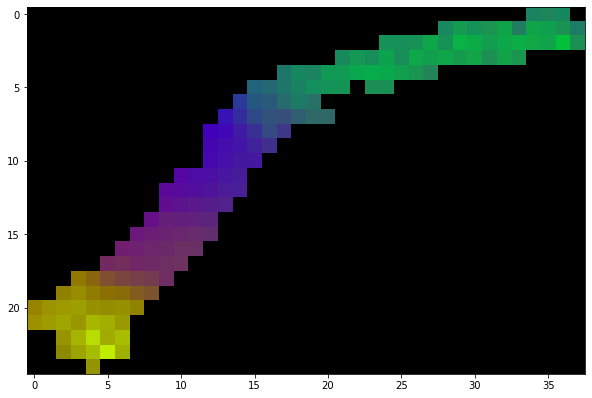

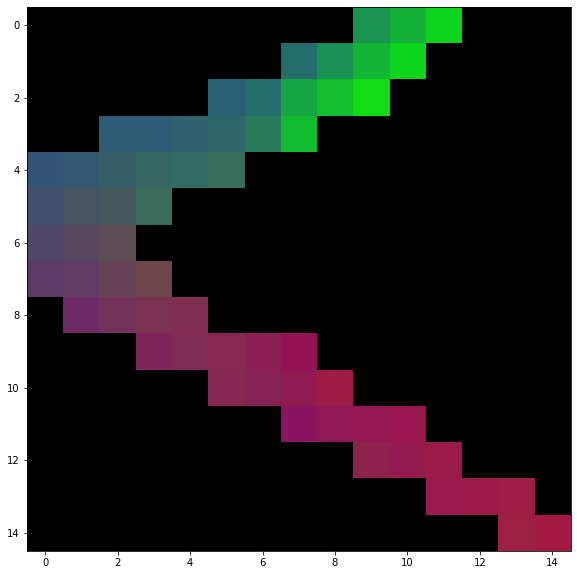

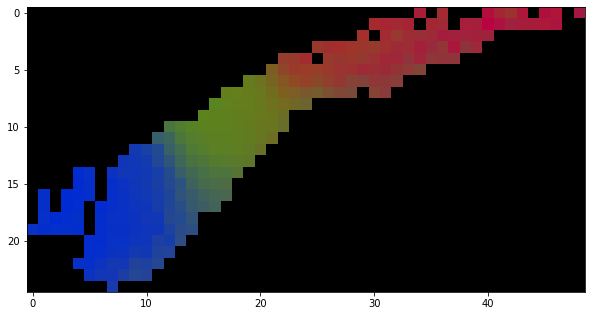

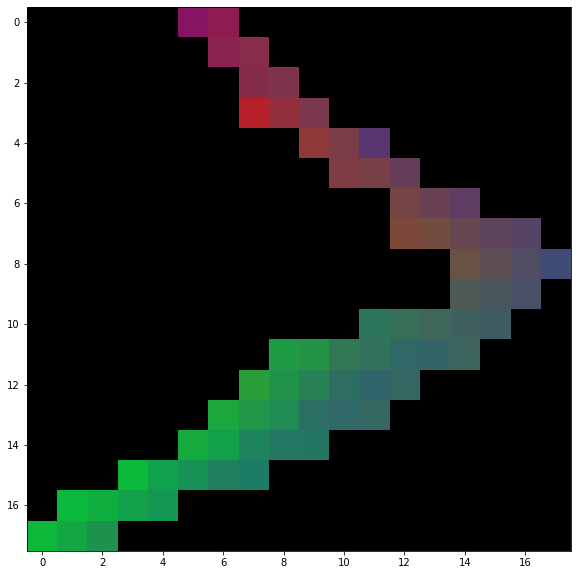

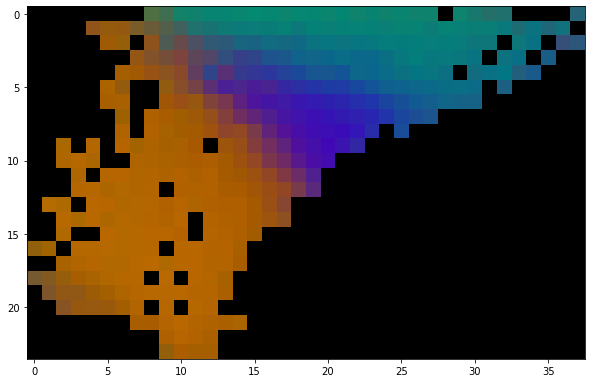

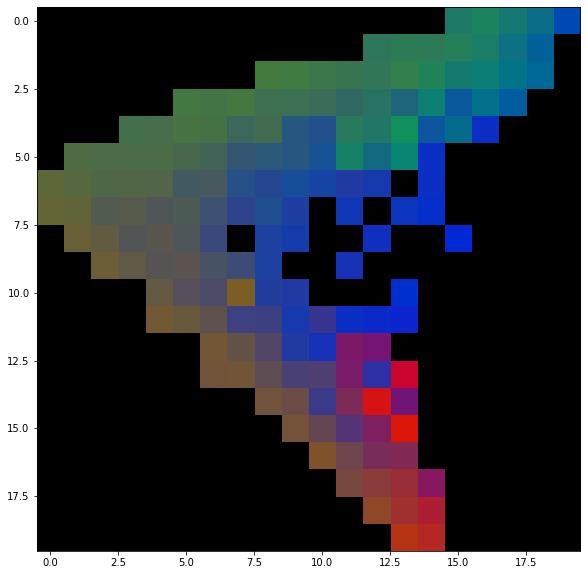

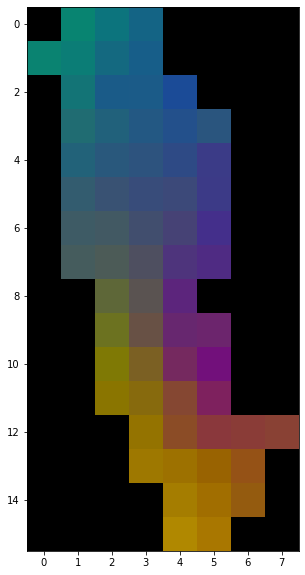

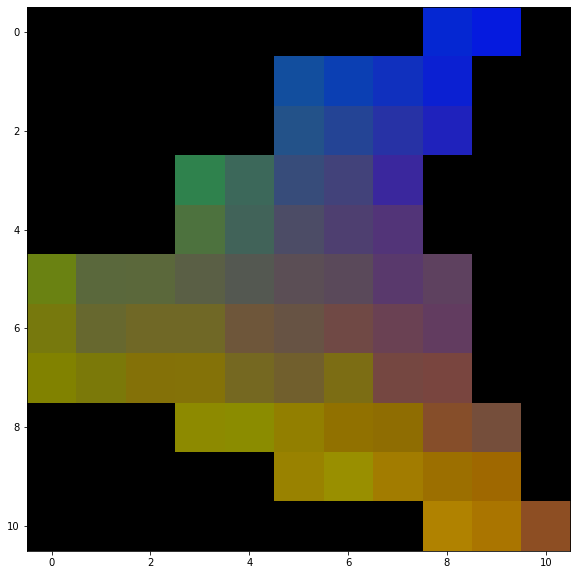

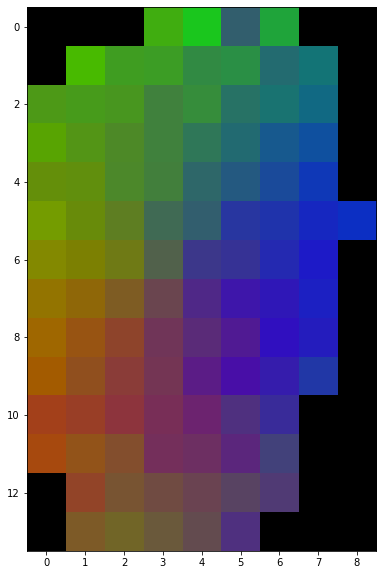

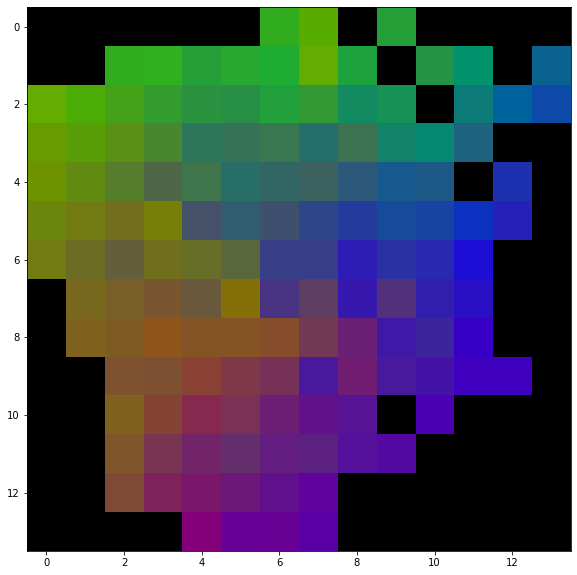

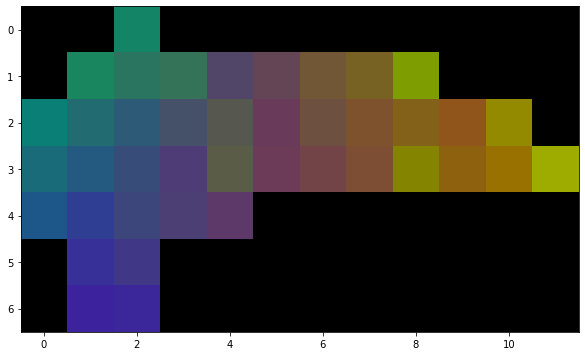

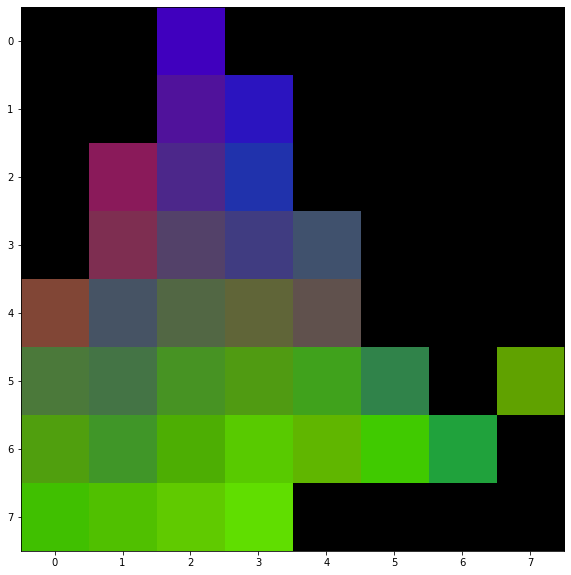

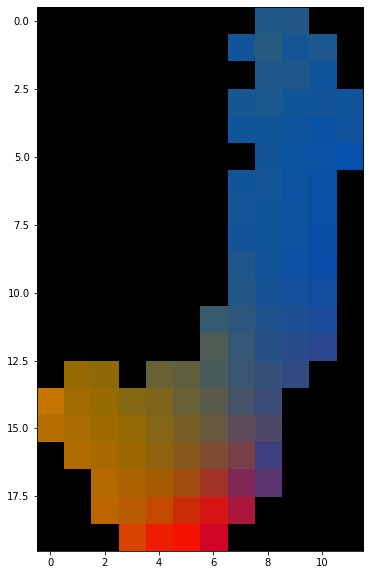

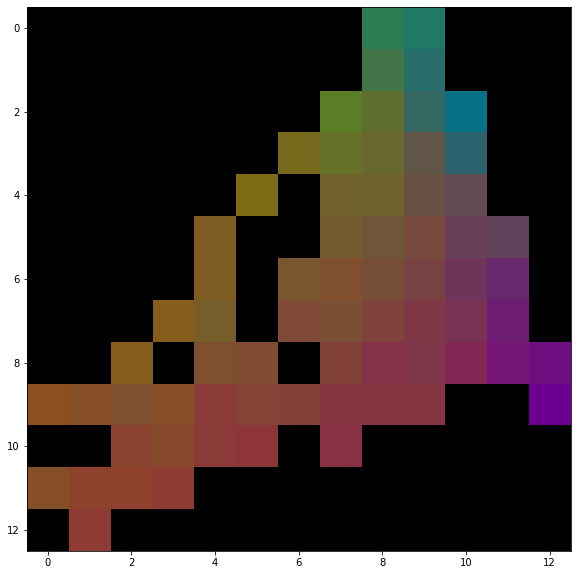

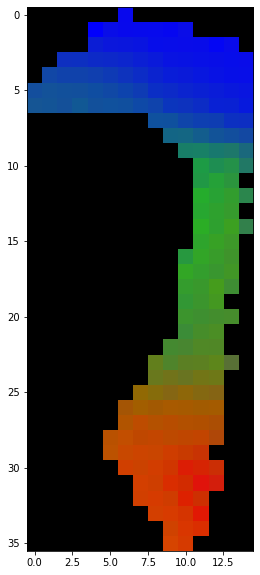

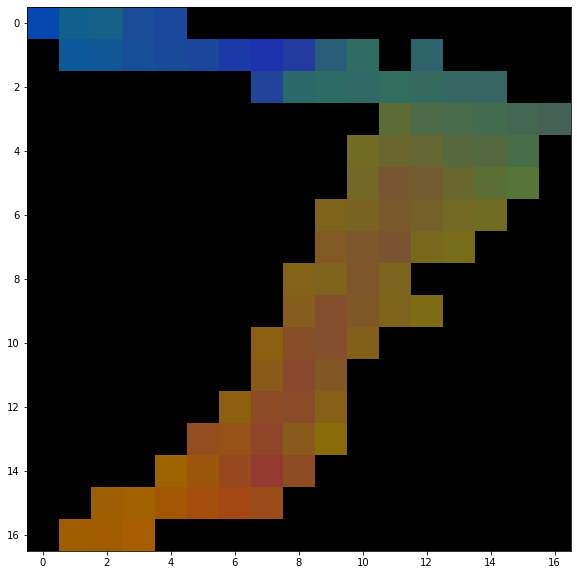

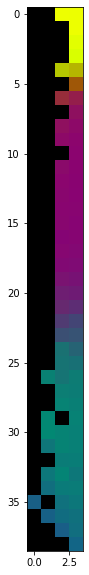

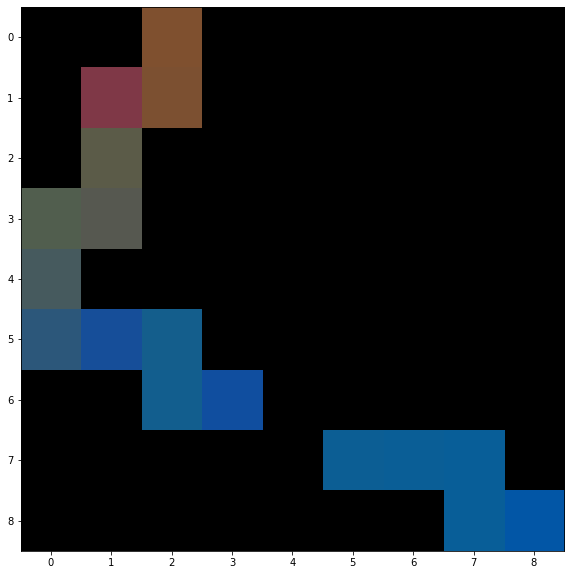

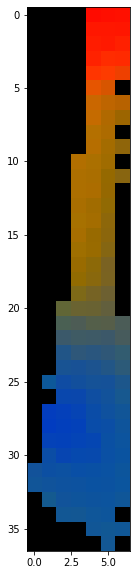

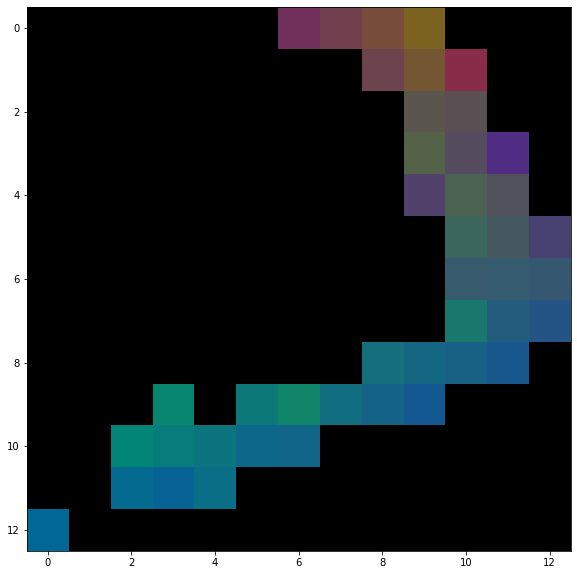

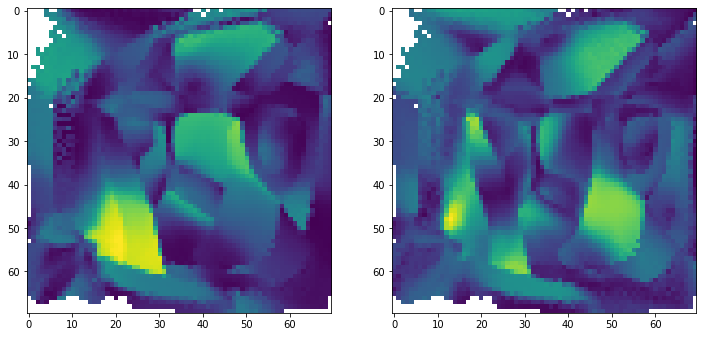

In [9]:
def viz_as_image(pxl, viz, viz_type='image', ax=None, lst_regions=None):
    mask = numpy.all((~numpy.isnan(viz.raw)) & (viz.raw > -1)
                     &(~numpy.isnan(pxl.raw)) & (pxl.raw > -1), axis=3)
    if lst_regions is not None:
        reg_ids = [list(hier.collect("acronym", reg_name, "id")) for reg_name in lst_regions]
        mask = mask & (numpy.in1d(ann.raw.flat, numpy.hstack(reg_ids)).reshape(ann.raw.shape))

    xy = pxl.raw[mask]
    xy = xy - numpy.nanmin(xy, axis=0, keepdims=True)
    ab = viz.raw[mask]
    # Both coordinates between 0 and 1
    ab = (ab - ab.min(axis=0, keepdims=True)) / (ab.max(axis=0, keepdims=True) - ab.min(axis=0, keepdims=True))
    # Sum of coordinates under 1
    ab = ab / (3 * ab.mean(axis=0, keepdims=True))
    # Third coordinate sums it up to exactly 1
    ab = numpy.hstack([ab, 1.0 - ab.sum(axis=1, keepdims=True)])
    
    if ax is None:
        if viz_type == 'image':
            ax = plt.figure().gca()
        elif viz_type == 'double_gradient':
            fig = plt.figure()
            ax = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]

    if viz_type == 'image':
        ax.imshow( coordinates_to_image(ab, xy) )
    elif viz_type == 'double_gradient':
        ax[0].imshow( coordinates_to_image(ab[:, [0]], xy)[:, :, 0] )
        ax[1].imshow( coordinates_to_image(ab[:, [1]], xy)[:, :, 0] )
    
for region in cortex_regions:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    viz_as_image(pxl, aff_viz, ax=ax, lst_regions=[region])
    fig.savefig("figures/CC/forward_{0}.png".format(region))
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    viz_as_image(aff_viz, pxl, ax=ax, lst_regions=[region])
    fig.savefig("figures/CC/backward_{0}.png".format(region))

fig = plt.figure(figsize=(12, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
viz_as_image(pxl, aff_viz, ax=[ax1, ax2], viz_type="double_gradient")
fig.savefig("figures/CC/all_regions_double_gradient.png")


Text(0, 0.5, 'Banana ratio')

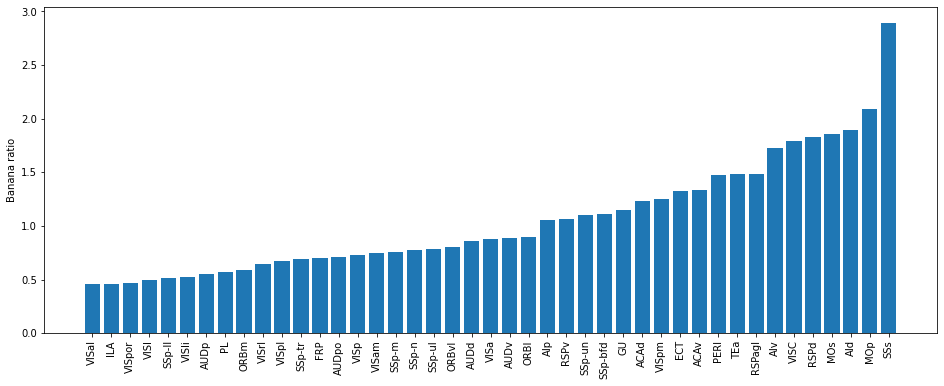

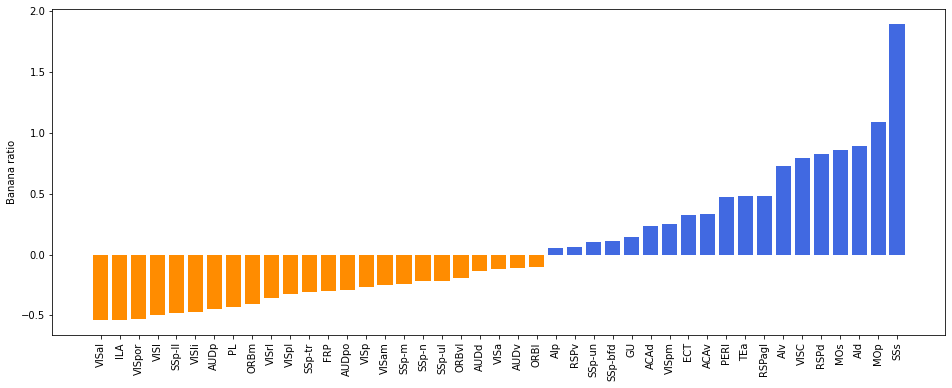

In [4]:
import voxcell
import json
import os
from matplotlib import pyplot as plt
from voxel_maps import coordinates_to_image
import os
from PIL import Image, ImageOps
import numpy as np
import itertools
from scipy.spatial import distance

def crop_pic(image):
    ''' Function to crop the pic and remove blank space and axis
    convert first in RGB and negate to remove the blank space (now black)
    then convert to gray image to avoid false negative pixel'''
    ls_pic = []
    invert_im = image.convert("RGB") 
    invert_im = ImageOps.invert(invert_im)
    imageBox = invert_im.getbbox()  
    cropped=image.crop(imageBox)
    cropped=cropped.convert("LA")
    cropped_pic = np.asarray(cropped)[:,:,0]
    # Border of y axis depends on the number of digits, 
    # this loop finds were the the value of pixel changes of 230
    for i in range(cropped_pic.shape[1]-1):
        if int(cropped_pic[0,i]) - int(cropped_pic[0,i+1]) > 230:
            border = i+1
    cropped_pic = np.delete(cropped_pic, np.s_[0:border+1], 1) # Remove pixels of y axis + frame
    cropped_pic = np.delete(cropped_pic, np.s_[0:1], 0) # Remove pixels of frame
    cropped_pic = np.delete(cropped_pic, np.s_[cropped_pic.shape[1]-1:], 1) # Remove pixels of frame
    cropped_pic = np.delete(cropped_pic, np.s_[cropped_pic.shape[0]-15:], 0) # Remove pixels of x axis 
    ls_pic.append(cropped_pic)
    return ls_pic


def find_area(ls_pic):
    '''Calculate the area between 3 extreme points, we assume that for each
    border of the frame, a pixel is touching it. Select the mean coordinate of
    these pixel, e.g. 4 pixels, and caculate the area for each combinations of
    possible triangle. Returns the biggest area and the coordinates of the 
    corners.
    '''
    pic = ls_pic[0]
    ab = np.nonzero(pic[0])
    bc = np.nonzero(pic[:,pic.shape[1]-1])
    cd = np.nonzero(pic[pic.shape[0]-1])
    da = np.nonzero(pic[:,0])
    
    coor1 = (0, round(np.mean(ab)))
    coor2 = (round(np.mean(bc)), pic.shape[1]-1)
    coor3 = (pic.shape[0]-1, round(np.mean(cd)))
    coor4 = (round(np.mean(da)), 0)
    coors = [coor1, coor2, coor3, coor4]
    ls_coor = list(itertools.combinations(coors, 3))
    ls_area = []

    for i in range(len(ls_coor)):
        AB = distance.euclidean(ls_coor[i][0],ls_coor[i][1])
        BC = distance.euclidean(ls_coor[i][1],ls_coor[i][2])
        AC = distance.euclidean(ls_coor[i][0],ls_coor[i][2])
        p = (AB+BC+AC)/2
        area = np.sqrt(p*(p-AB)*(p-BC)*(p-AC))
        ls_area.append(area)
    idx = int(np.asarray(np.where(ls_area == np.amax(ls_area))))
    # print(f"The coordinates of the triangle's corners are {ls_coor[idx]}")
    return round(np.amax(ls_area))


def banana_ratio(image):
    '''Calculate the ratio between the area the triangle found and the actual
    surface of the image. A high ratio indicates a banana.
    '''
    ls_pic = crop_pic(image)
    area = find_area(ls_pic) 
    surf = np.sum(ls_pic[0] !=0)
    ratio = area/surf
    # print(ratio)
    return ratio

filelist=os.listdir('figures/CC')
for fichier in filelist[:]: # filelist[:] makes a copy of filelist.
    if not(fichier.startswith("back")):
        filelist.remove(fichier)
# print(filelist)

import pandas as pd
df_ratio = pd.DataFrame({})
for i in filelist:
    image = Image.open(f'figures/CC/{i}')
    df_ratio.at[f'{i}', 1] = banana_ratio(image)

# Plot results
ratio = df_ratio.to_dict()[1]
reg_name, vals = zip(*ratio.items())
idxx = np.argsort(vals)
reg_name = [reg_name[i] for i in idxx]
for i in range(len(reg_name)):
    reg_name[i] = reg_name[i].replace('backward_', '')
    reg_name[i] = reg_name[i].replace('.png', '')
vals = [vals[i] for i in idxx]
ax = plt.figure(figsize=(16, 6)).gca()
ax.bar(range(len(reg_name)), vals)
ax.set_xticks(range(len(reg_name)))
ax.set_xticklabels(reg_name, rotation='vertical')
ax.set_ylabel("Banana ratio")


ratio = df_ratio.to_dict()[1]
reg_name, vals_b = zip(*ratio.items())
idxx = np.argsort(vals_b)
reg_name = [reg_name[i] for i in idxx]
for i in range(len(reg_name)):
    reg_name[i] = reg_name[i].replace('backward_', '')
    reg_name[i] = reg_name[i].replace('.png', '')
vals_b = [vals_b[i] for i in idxx]
for i in range(len(vals_b)):
    vals_b[i] = vals_b[i] - 1
ar = np.asarray(vals_b)
colors = np.array(['darkorange']*len(vals_b))
colors[ar >= 0] = ['royalblue']
ax = plt.figure(figsize=(16, 6)).gca()
ax.bar(range(len(reg_name)), vals_b, color=colors)
ax.set_xticks(range(len(reg_name)))
ax.set_xticklabels(reg_name, rotation='vertical')
ax.set_ylabel("Banana ratio")

VISl


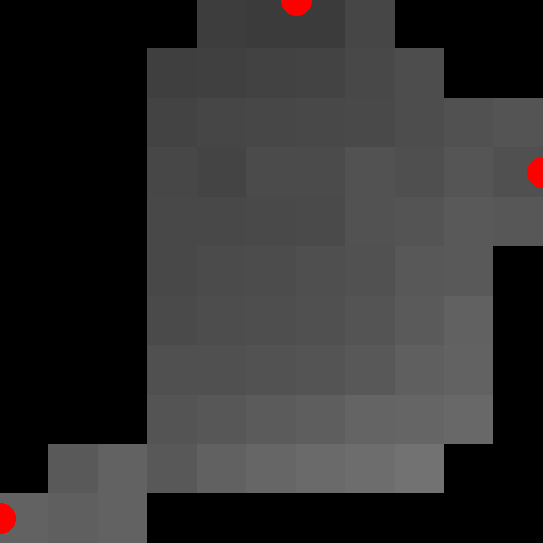

ECT


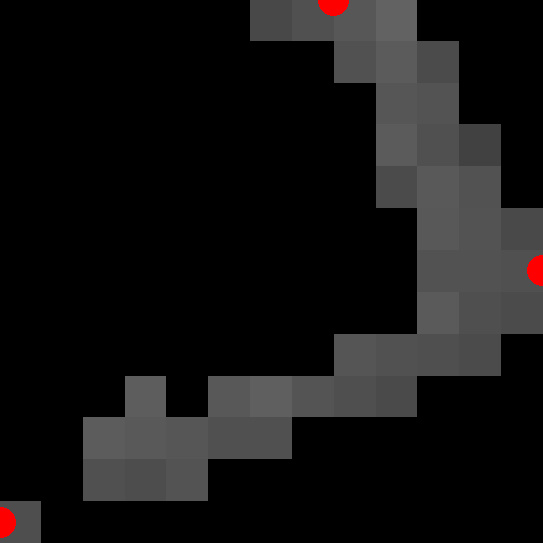

PERI


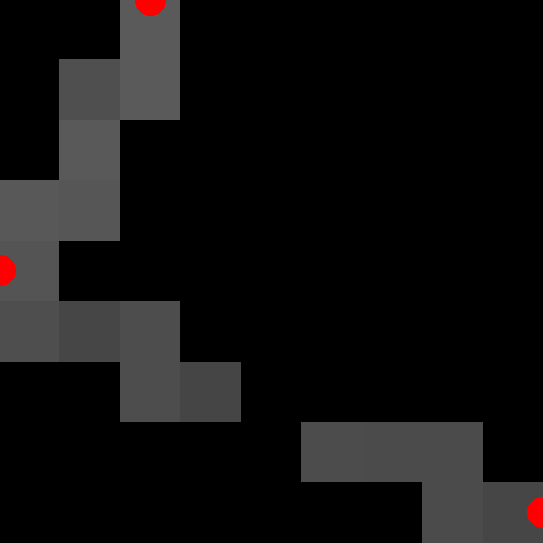

ORBvl


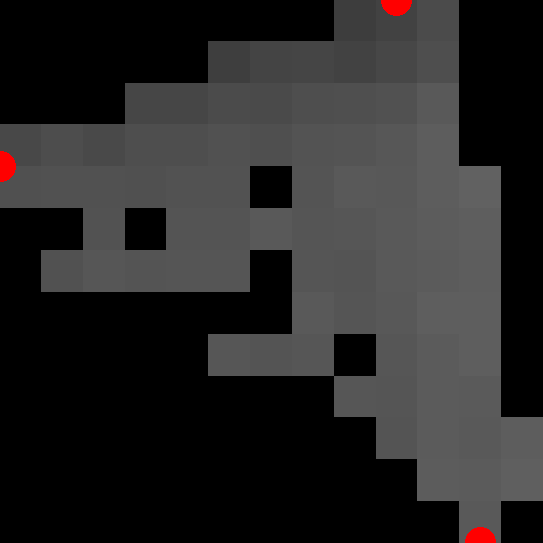

GU


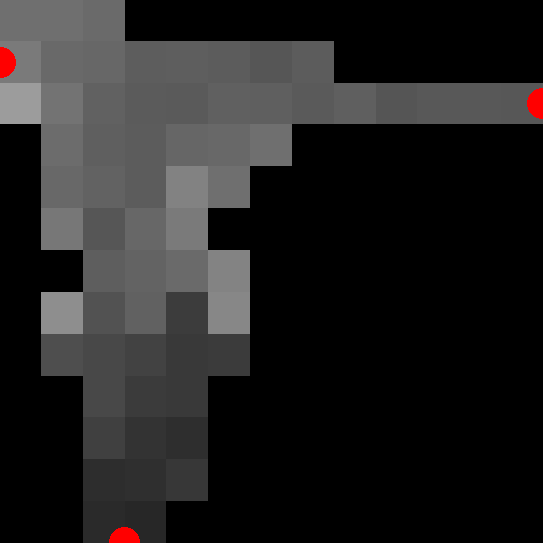

MOs


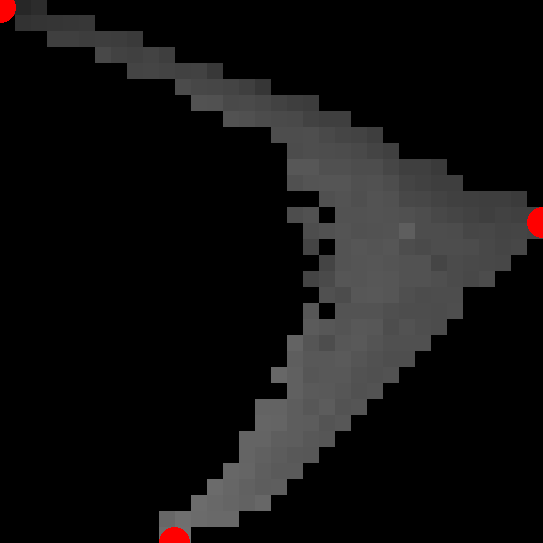

AUDp


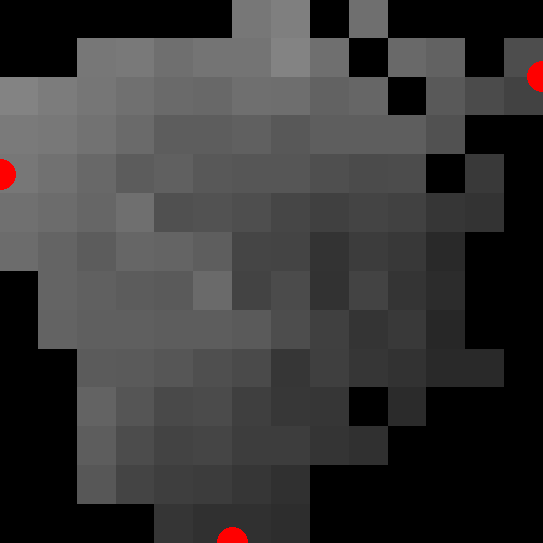

SSp-ul


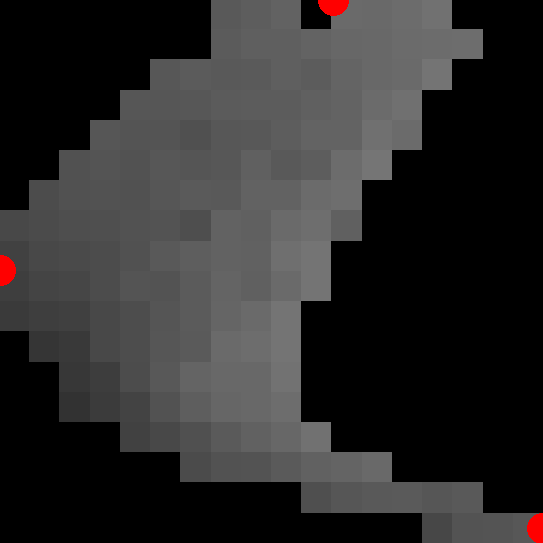

AId


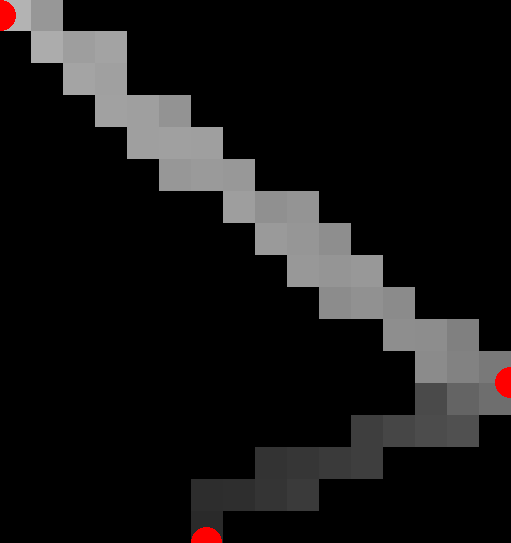

MOp


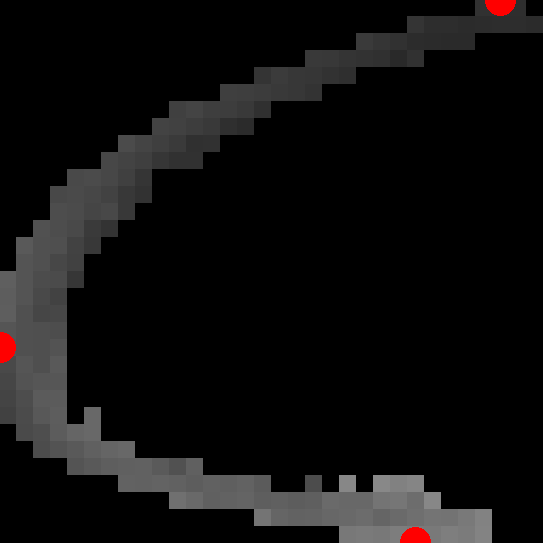

SSp-ll


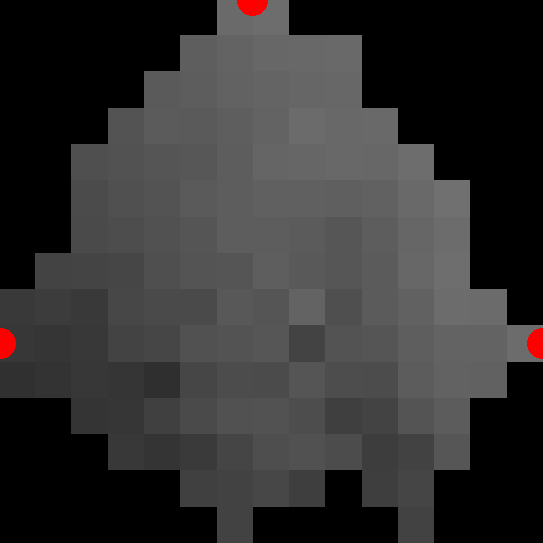

RSPagl


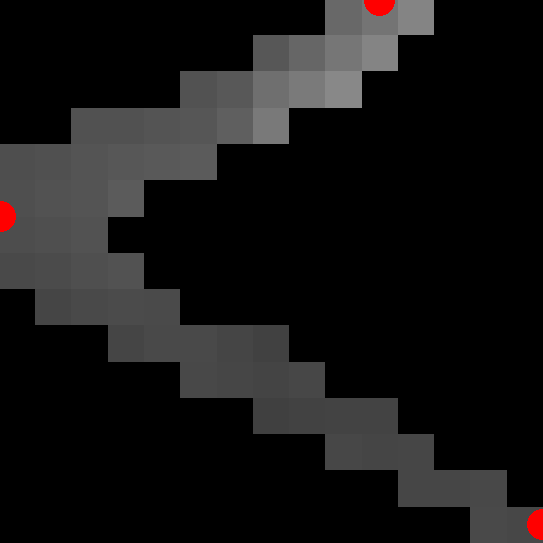

VISli


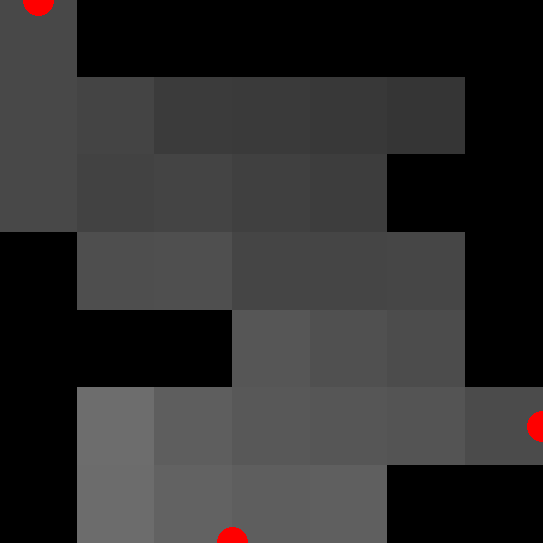

ORBm


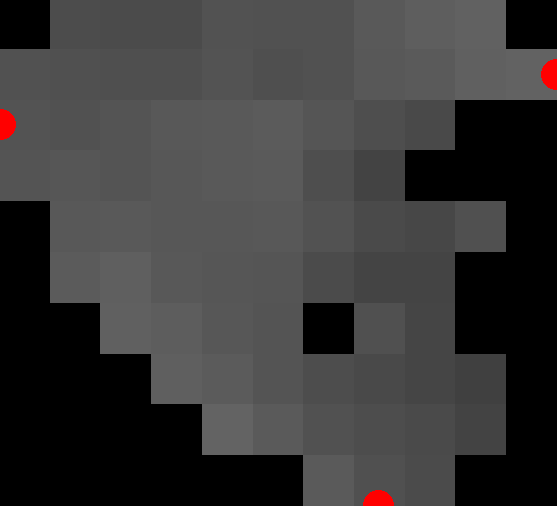

SSp-n


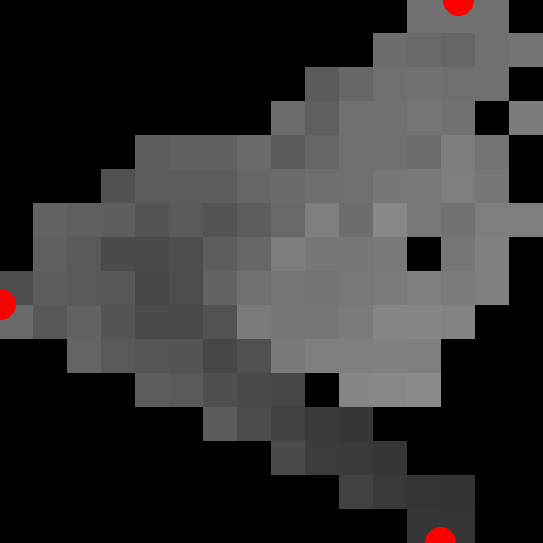

RSPv


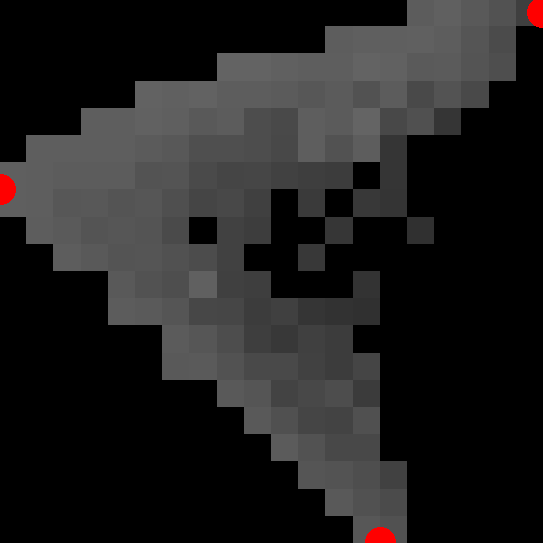

RSPd


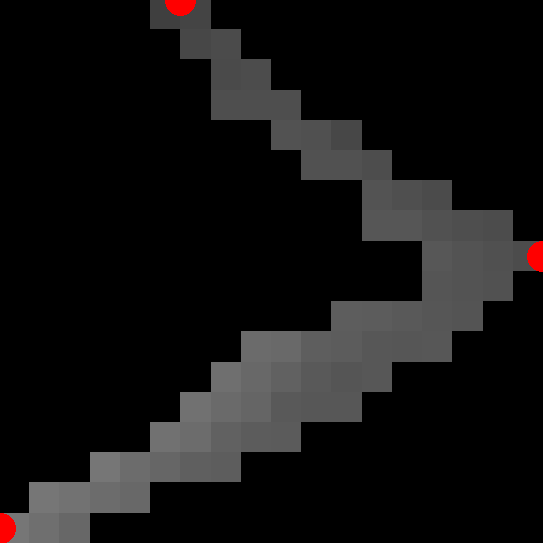

SSp-bfd


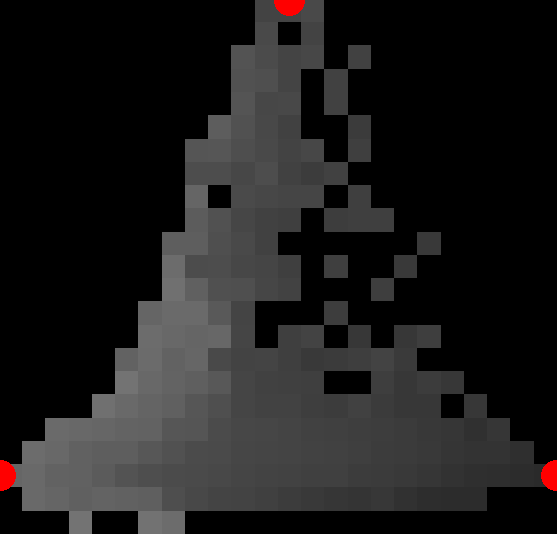

VISpl


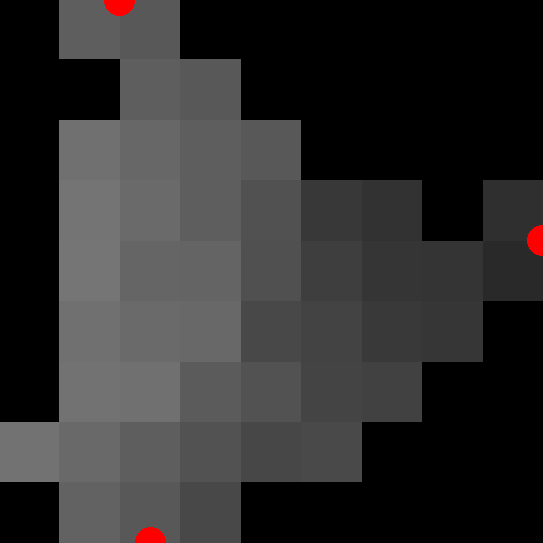

VISpm


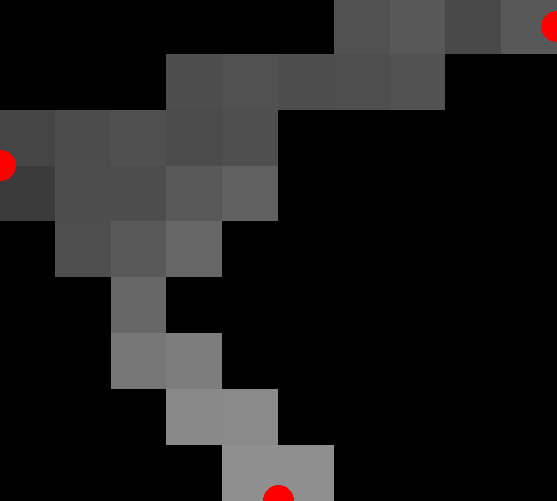

SSp-tr


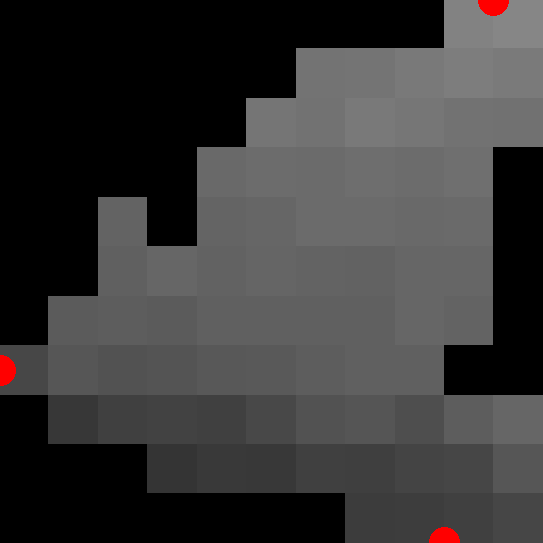

VISal


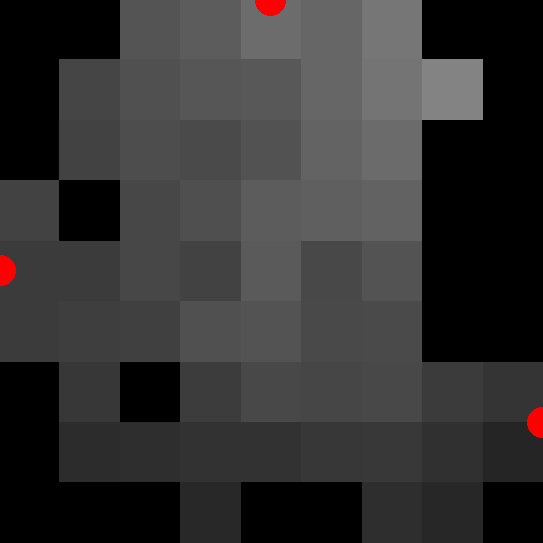

ORBl


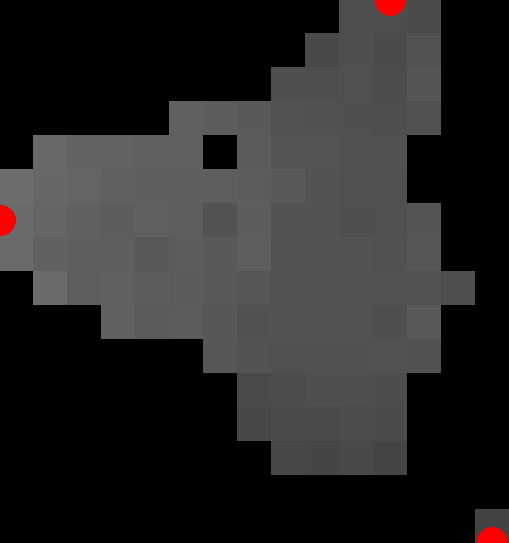

TEa


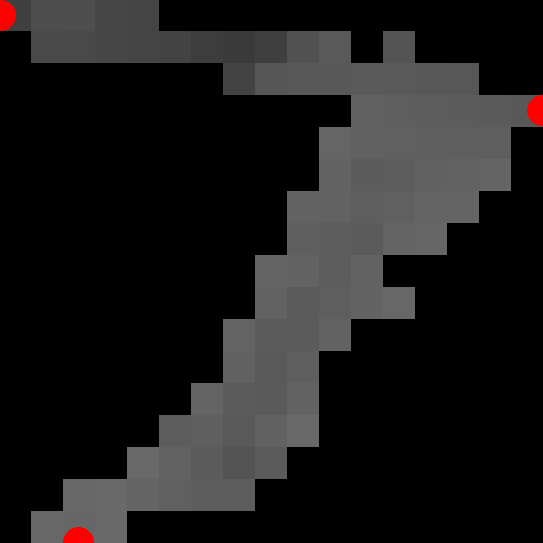

AUDv


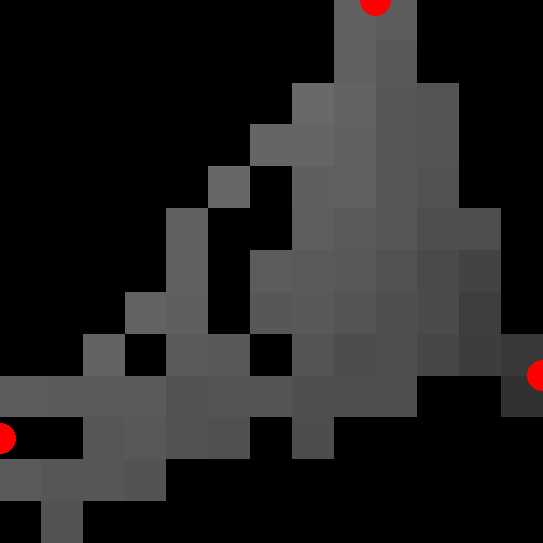

ACAv


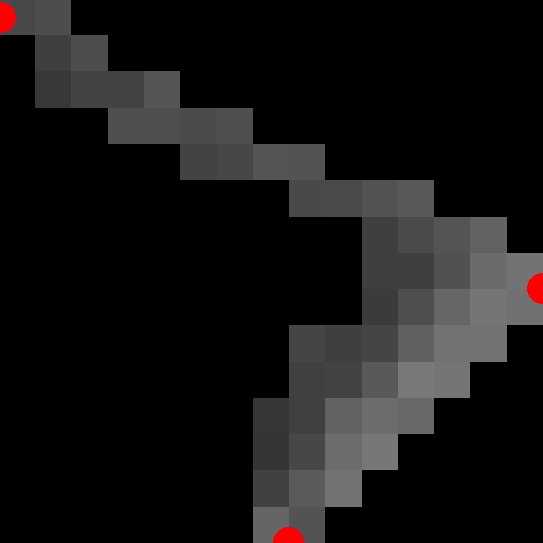

FRP


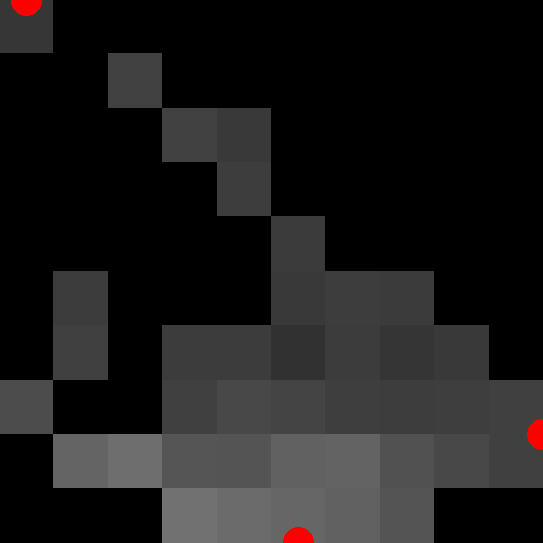

AUDpo


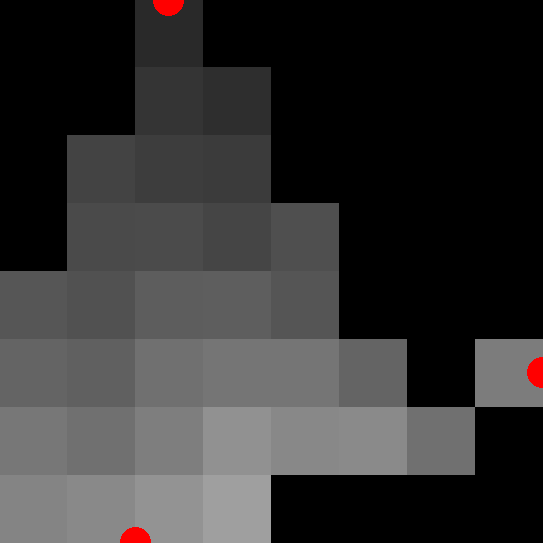

VISp


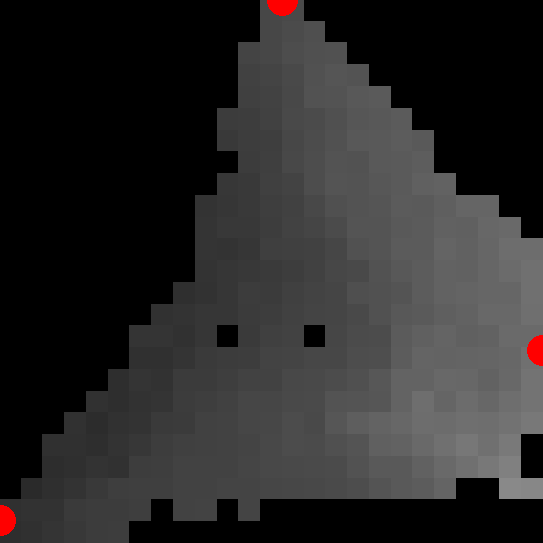

AIv


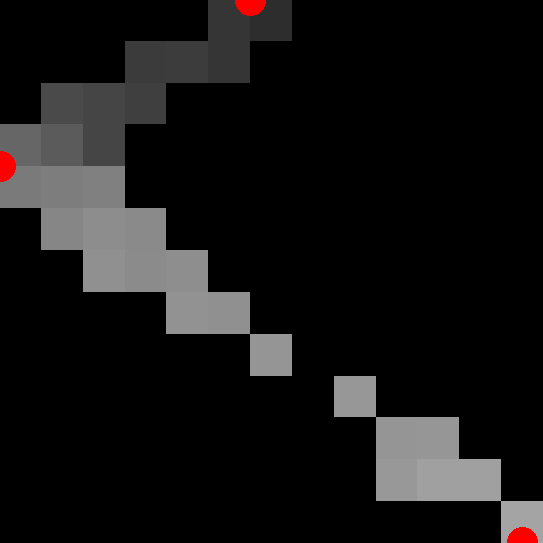

PL


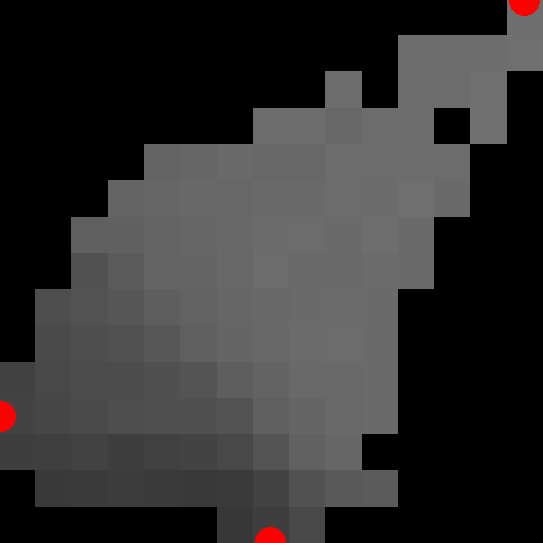

AIp


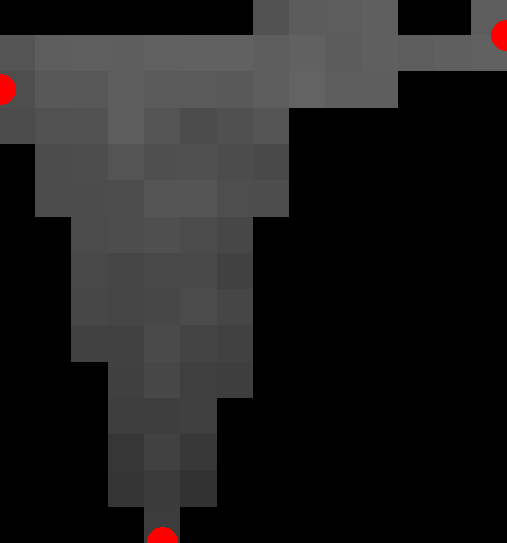

VISa


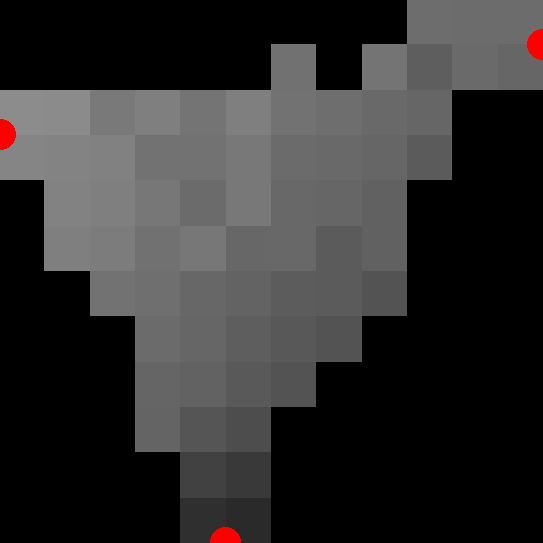

ACAd


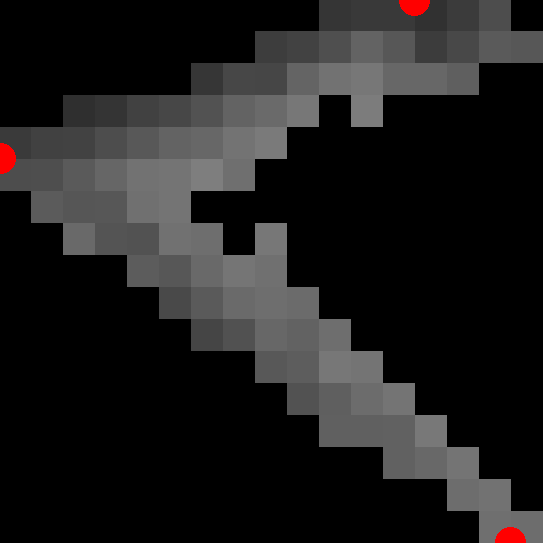

ILA


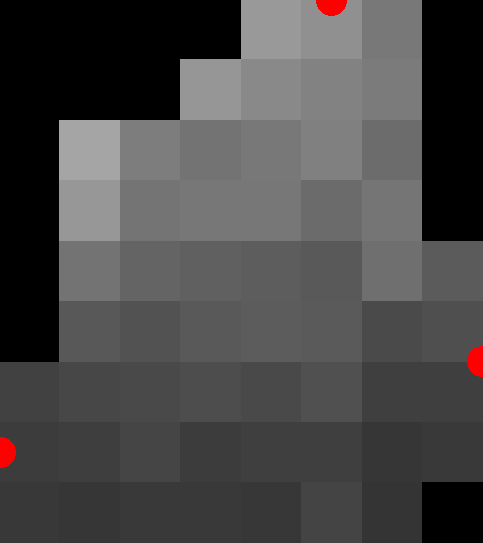

VISrl


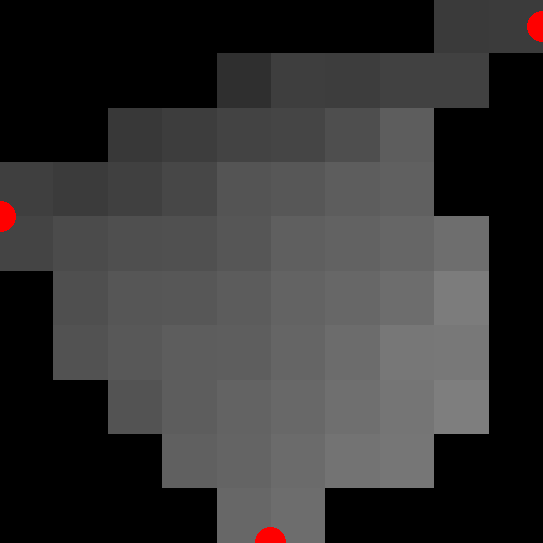

AUDd


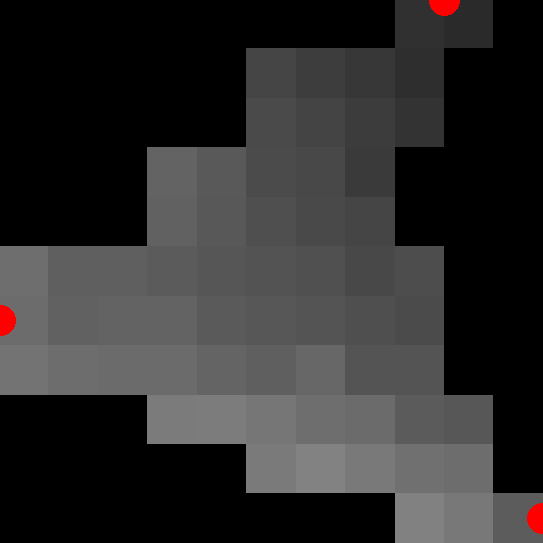

SSs


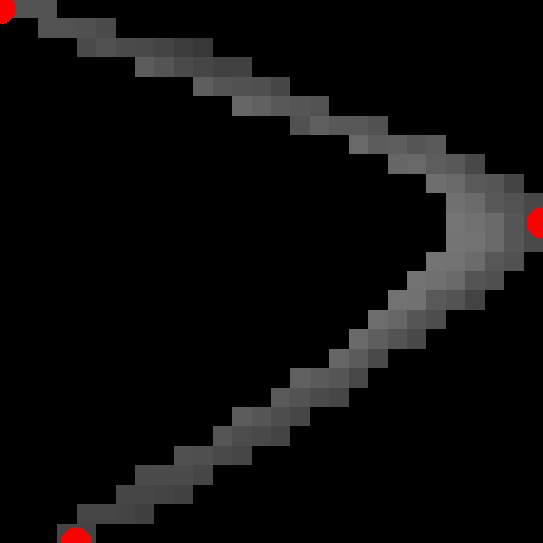

SSp-un


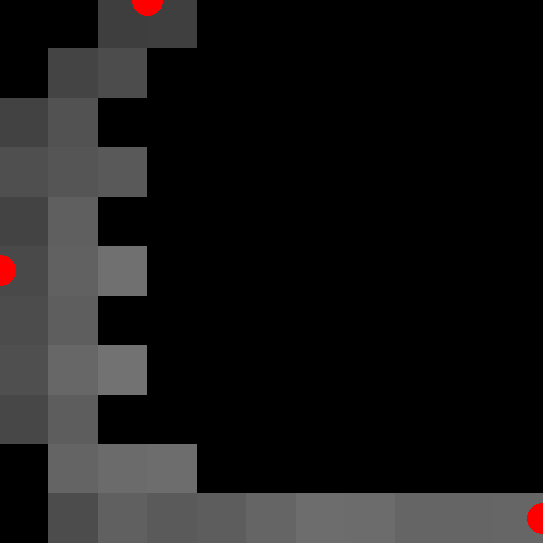

VISpor


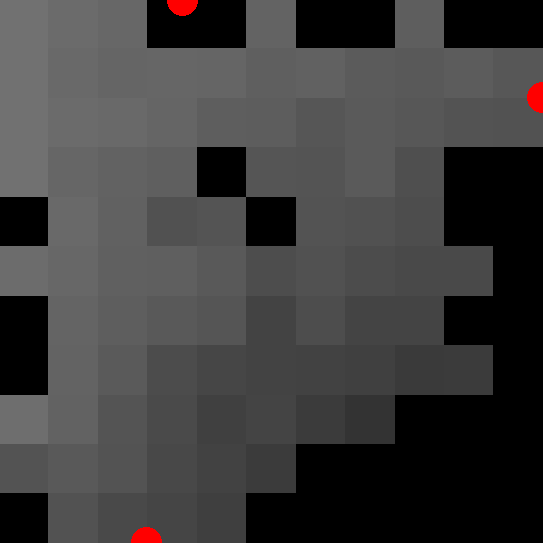

VISam


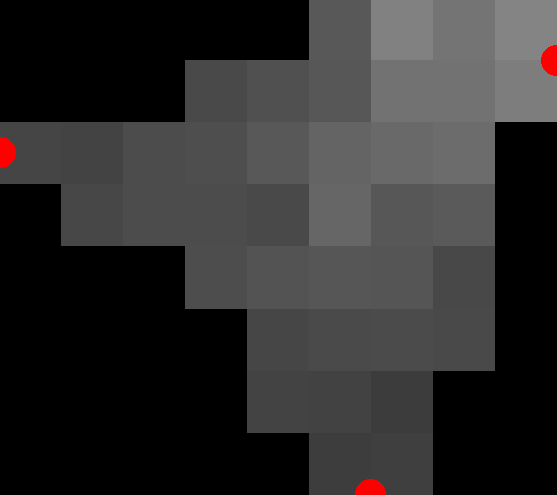

SSp-m


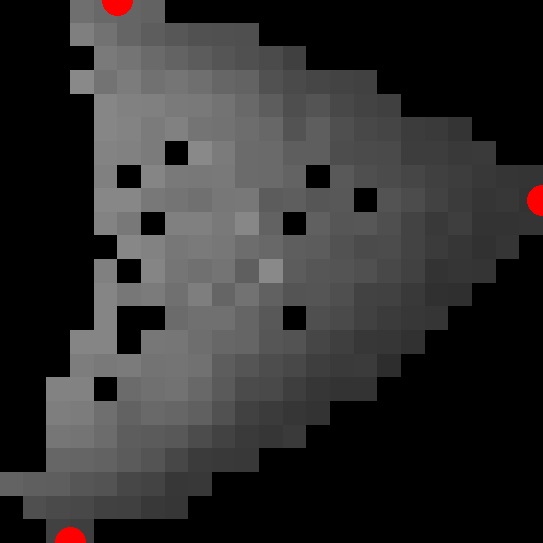

VISC


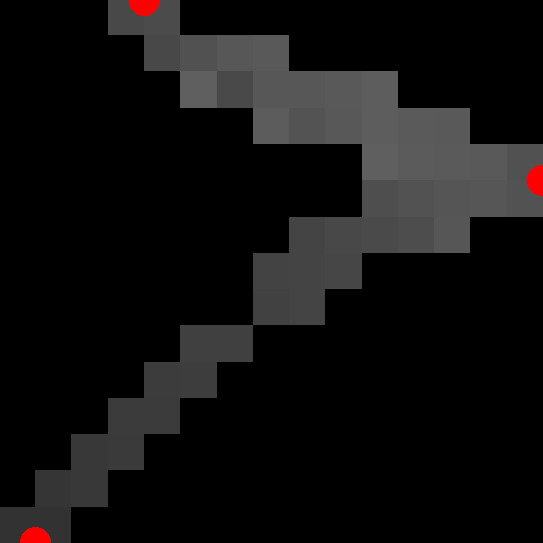

In [5]:
from PIL import ImageDraw
from IPython.display import display


def crop_pic(image):
    ''' Function to crop the pic and remove blank space and axis
    convert first in RGB and negate to remove the blank space (now black)
    then convert to gray image to avoid false negative pixel'''
    ls_pic = []
    invert_im = image.convert("RGB") 
    invert_im = ImageOps.invert(invert_im)
    imageBox = invert_im.getbbox()  
    cropped=image.crop(imageBox)
    cropped=cropped.convert("LA")
    cropped_pic = np.asarray(cropped)[:,:,0]
    # Border of y axis depends on the number of digits, 
    # this loop finds were the the value of pixel changes of 230
    for i in range(cropped_pic.shape[1]-1):
        if int(cropped_pic[0,i]) - int(cropped_pic[0,i+1]) > 230:
            border = i+1
    cropped_pic = np.delete(cropped_pic, np.s_[0:border+1], 1) # Remove pixels of y axis + frame
    cropped_pic = np.delete(cropped_pic, np.s_[0:1], 0) # Remove pixels of frame
    cropped_pic = np.delete(cropped_pic, np.s_[cropped_pic.shape[1]-1:], 1) # Remove pixels of frame
    cropped_pic = np.delete(cropped_pic, np.s_[cropped_pic.shape[0]-15:], 0) # Remove pixels of x axis 
    ls_pic.append(cropped_pic)
    return ls_pic


def find_area(ls_pic):
    '''Calculate the area between 3 extreme points, we assume that for each
    border of the frame, a pixel is touching it. Select the mean coordinate of
    these pixel, e.g. 4 pixels, and caculate the area for each combinations of
    possible triangle. Returns the biggest area and the coordinates of the 
    corners.
    '''
    pic = ls_pic[0]
    ab = np.nonzero(pic[0])
    bc = np.nonzero(pic[:,pic.shape[1]-1])
    cd = np.nonzero(pic[pic.shape[0]-1])
    da = np.nonzero(pic[:,0])
    
    coor1 = (0, round(np.mean(ab)))
    coor2 = (round(np.mean(bc)), pic.shape[1]-1)
    coor3 = (pic.shape[0]-1, round(np.mean(cd)))
    coor4 = (round(np.mean(da)), 0)
    coors = [coor1, coor2, coor3, coor4]
    ls_coor = list(itertools.combinations(coors, 3))
    ls_area = []

    for i in range(len(ls_coor)):
        AB = distance.euclidean(ls_coor[i][0],ls_coor[i][1])
        BC = distance.euclidean(ls_coor[i][1],ls_coor[i][2])
        AC = distance.euclidean(ls_coor[i][0],ls_coor[i][2])
        p = (AB+BC+AC)/2
        area = np.sqrt(p*(p-AB)*(p-BC)*(p-AC))
        ls_area.append(area)
    idx = int(np.asarray(np.where(ls_area == np.amax(ls_area))))
    # print(f"The coordinates of the triangle's corners are {ls_coor[idx]}")
    return round(np.amax(ls_area)), ls_coor[idx]

# For one map
image = Image.open('figures/CC/backward_MOs.png')
crop = crop_pic(image)
area, coords = find_area(crop)

PIL_image = Image.fromarray(np.uint8(crop[0])).convert("RGB")
draw = ImageDraw.Draw(PIL_image)
for i in range(3):
    draw.ellipse((coords[i][1]-15, coords[i][0]-15, coords[i][1]+15, coords[i][0]+15),
                 fill='red', outline ='red')
# display(PIL_image)


filelist=os.listdir('figures/CC')
for fichier in filelist[:]: # filelist[:] makes a copy of filelist.
    if not(fichier.startswith("back")):
        filelist.remove(fichier)

# For all maps
for i in filelist:
    image = Image.open(f'figures/CC/{i}')
    crop = crop_pic(image)
    area, coords = find_area(crop)
    
    PIL_image = Image.fromarray(np.uint8(crop[0])).convert("RGB")
    draw = ImageDraw.Draw(PIL_image)
    for j in range(3):
        draw.ellipse((coords[j][1]-15, coords[j][0]-15, coords[j][1]+15, coords[j][0]+15),
                     fill='red', outline ='red')
    name = i.replace('backward_', '')
    name = name.replace('.png', '') 
    print(name)
    display(PIL_image)

/gpfs/bbp.cscs.ch/home/guyonnet/venvs/my_venv/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


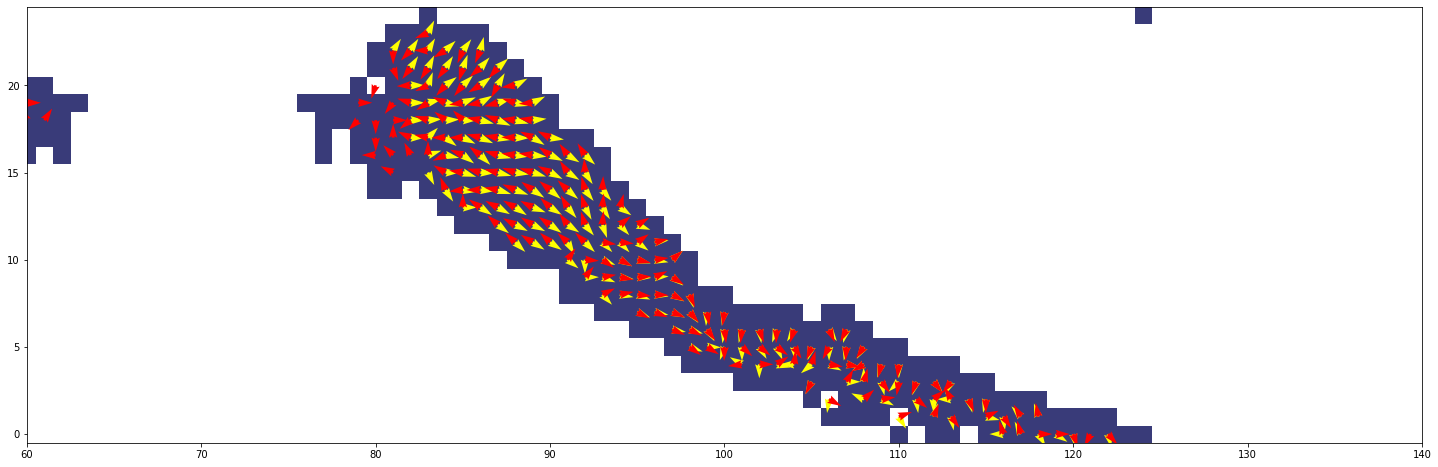

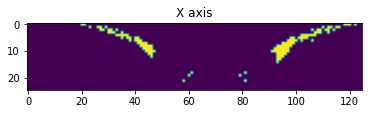

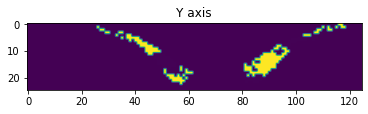

In [54]:
from PIL import Image, ImageOps, ImageDraw
from IPython.display import display
flatmap_for_pixel_positions = "./diffusion_embedding_thalamic_flatmap_plus_isocortex_v2.nrrd"
aff_flatmap_to_visualize = "./per_region_diffusion_flatmap_afferent.nrrd"
aff_flatmap_to_visualize = "../cc_db_flatmap_PP.nrrd"
# aff_flatmap_to_visualize = "../cc_db_flatmap_1_3.nrrd"

region_atlas = "../annotation_100.nrrd"
hierarchy_fn = "../hierarchy_bis.json"

somatomotor = ["SSp-ll", "SSp-ul", "SSp-n", "SSp-m", "SSp-tr", "SSp-bfd",
                        "SSp-un", "SSs", "MOp", "MOs"]
cortex_regions = ["FRP","MOs","ACAd","ACAv","PL","ILA","ORBl","ORBm","ORBvl",
                             "AId","AIv","AIp","GU","VISC",
                             "SSs","SSp-bfd","SSp-tr","SSp-ll","SSp-ul","SSp-un","SSp-n","SSp-m","MOp",
                             "VISal","VISl","VISp","VISpl","VISli","VISpor","VISrl",
                             "VISa","VISam","VISpm","RSPagl","RSPd","RSPv",
                             "AUDd","AUDp","AUDpo","AUDv","TEa","PERI","ECT"]

pxl = voxcell.VoxelData.load_nrrd(flatmap_for_pixel_positions)
aff_viz = voxcell.VoxelData.load_nrrd(aff_flatmap_to_visualize)
aff_viz.raw[numpy.isnan(aff_viz.raw) | (aff_viz.raw < 0)] = -1

ann = voxcell.VoxelData.load_nrrd(region_atlas)
hier = voxcell.Hierarchy.load_json(hierarchy_fn)

def region_image(lst_regions, pxl=pxl):
    ann_vals = ann.raw.reshape((-1,))
    xy = pxl.raw.reshape((-1, 2))
    img_xy = numpy.empty(shape=(0, 2))
    img_vals = numpy.empty(shape=(0, 1))
    for i, tgt_region in enumerate(lst_regions):
        tgt_region_ids = list(hier.collect('acronym', tgt_region, 'id'))
        sub_xy = xy[numpy.in1d(ann_vals, tgt_region_ids), :]
        img_xy = numpy.vstack([img_xy, sub_xy])
        img_vals = numpy.vstack([img_vals, i * numpy.ones((len(sub_xy), 1))])
    return coordinates_to_image(img_vals, img_xy)


def viz_as_quiver(pxl, viz, ax=None, lst_regions=cortex_regions, normalize=True):
    if ax is None:
        ax = plt.figure(figsize=(25, 25)).gca()
    ax.imshow(region_image(lst_regions, pxl=pxl), cmap="tab20b")

    mask = numpy.all((~numpy.isnan(viz.raw)) & (viz.raw > -1), axis=3)
    ann_vals = ann.raw[mask]
    xy = pxl.raw[mask]
    ab = viz.raw[mask]
    #xy = xy - numpy.nanmin(xy, axis=0, keepdims=True)
    def normalize_gradient(gX, gY):
        l = numpy.sqrt(gX ** 2 + gY ** 2)
        return gX / l, gY / l
        

    for tgt_region in lst_regions:
        try:
            tgt_region_ids = list(hier.collect('acronym', tgt_region, 'id'))
            sub_xy = xy[numpy.in1d(ann_vals, tgt_region_ids)]
            sub_ab = ab[numpy.in1d(ann_vals, tgt_region_ids)]
            tmp_img = coordinates_to_image(sub_ab, sub_xy)
            #ax.imshow(tmp_img[:, :, 0])
            gY1, gX1 = numpy.gradient(tmp_img[:, :, 0])
            gY2, gX2 = numpy.gradient(tmp_img[:, :, 1])
            if normalize:
                
                gX1, gY1 = normalize_gradient(gX1, gY1)
                gX2, gY2 = normalize_gradient(gX2, gY2)
            X, Y = numpy.meshgrid(numpy.arange(gX1.shape[1]), numpy.arange(gX1.shape[0]))
            ax.quiver(X, Y, gX1, gY1, color='yellow', scale=100); 
            ax.quiver(X, Y, gX2, gY2, color='red', scale=100)
        except:
            pass
    ax.set_xlim([60, 140])
    ax.set_ylim(sorted(ax.get_ylim()))
    # ax.set_ylim([0, 70])
    return gX1, gY1, gX2, gY2


gX1, gY1, gX2, gY2 = viz_as_quiver(pxl, aff_viz, lst_regions=['RSPd'], normalize=True)
plt.show()

a = numpy.nan_to_num(gY1, nan=0)
b = numpy.nan_to_num(gY2, nan=0)
zX = numpy.sign(numpy.nan_to_num(gX2, nan=0))
zY = numpy.sign(numpy.nan_to_num(gY2, nan=0))
im_x = Image.fromarray(numpy.uint8(zX)*255)
plt.imshow(im_x)
plt.title('X axis')
plt.show()
im_y = Image.fromarray(numpy.uint8(zY)*255)
plt.imshow(im_y)
plt.title('Y axis')
plt.show()